## Imports

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import warnings

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import  cross_val_score
from sklearn.linear_model import LinearRegression, ARDRegression, Lasso, SGDRegressor, ElasticNet, Ridge

from sklearn.ensemble import (
    StackingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    # AdaBoostRegressor,
    BaggingRegressor
)

from sklearn.linear_model import (
    HuberRegressor,
    QuantileRegressor,
    TheilSenRegressor,
    LassoCV,
    RidgeCV
)

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import root_mean_squared_error, mean_squared_error, make_scorer, root_mean_squared_error
from sklearn.model_selection import  cross_val_score, KFold, StratifiedKFold

from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans

from bayes_opt import BayesianOptimization
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNetCV
from catboost import Pool, CatBoostRegressor
from sklearn.svm import LinearSVR

## Setup

In [145]:
PATH_TRAIN = 'datasets/train.csv'
PATH_TEST = 'datasets/test.csv'

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 300)

exibe_logs = False    # Controla a exibição de logs (display_logs)

pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')


palete = sns.color_palette("Paired")

# coluna preenchinda no métogo get_dataframe()
colunas_numericas = list()

colunas_categoricas = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'GarageCond', 'GarageQual', 'GarageFinish', 
                       'KitchenQual', 'ExterQual', 'ExterCond', 'HeatingQC', 'Functional', 'Utilities', 
                       'LandContour', 'LotConfig', 'PavedDrive', 'CentralAir', 'Alley', 'Electrical']

colunas_para_transformacao_ohe = [
    'MSSubClass', 
    'MSZoning', 
    'Neighborhood', 
    'BldgType', 
    'HouseStyle', 
    'RoofStyle', 
    'RoofMatl', 
    'Foundation', 
    'Heating', 
    'GarageType', 
    'SaleType', 
    'SaleCondition',
    'conditions',
    'exteriors',
    'shape_slope',
    'bsmt_fin_types',
]

# coluna preenchida no método de processamento das colunas One Hot Encoding
colunas_transformadas_ohe = list()

# armazena todas as features criadas no processo de feature engeneering
features_criadas = list()

# preenchido quando o método set_feature_importance() é chamado
feature_importance_cols = list()

features_fortemente_correlacionadas = list()


def adicionar_features_criadas(feature: str):
    global features_criadas
    features_criadas.append(features_criadas) if feature not in features_criadas else None

def remover_feature_criada(feature: str):
    global features_criadas
    features_criadas.remove(feature) if feature in features_criadas else None

def adicionar_caracteristicas_fortemente_correlacionadas(feature: str):
    global features_fortemente_correlacionadas
    features_fortemente_correlacionadas.append(feature) if feature not in features_fortemente_correlacionadas else None


def remover_feature_fortemente_correlacionada(feature: str):
    global features_fortemente_correlacionadas
    features_fortemente_correlacionadas.remove(feature) if feature in features_fortemente_correlacionadas else None

## Funções de tratamento e processamento de dados

### Processamento de dados

In [146]:
def display_logs(log):
    if exibe_logs:
        print(f'*** {log} ***')

In [147]:
def get_dataframe(path: str) -> pd.DataFrame:
    dataframe = pd.read_csv(path)
    return dataframe

In [148]:
def obter_validacao_e_testes_concatenados():
    df_treino = get_dataframe(path=PATH_TRAIN)
    df_teste = get_dataframe(path=PATH_TEST)
    df = pd.concat([df_treino, df_teste], sort=False)
    return df

In [149]:
def separar_dataframes_validacao_e_testes(dataframe: pd.DataFrame):
    validacao = dataframe.iloc[:1460]
    testes = dataframe.iloc[1460: ]
    return validacao, testes

In [150]:
def checar_existencia_valores_nulos(dataframe: pd.DataFrame, min_index: int = 0, max_index: int = 100) -> pd.DataFrame:
    colunas_com_valores_nulos = dataframe.columns[dataframe.isna().any()]
    df = dataframe[colunas_com_valores_nulos].isna().sum()
    df = df.iloc[min_index:max_index]
    df = df.sort_values(ascending=False)
    print("\n######## COLUNAS COM VALORES NULOS ########\n")
    print(df)

In [151]:
import numpy as np

def convert_params(params):
    """
    Converte parâmetros específicos para os tipos corretos exigidos por modelos de regressão, como o SGDRegressor.

    Parâmetros:
    params (dict): Dicionário contendo os parâmetros ajustados para os modelos de regressão.

    Retorno:
    dict: Dicionário com os parâmetros convertidos para os tipos corretos.
    """
    converted_params = params.copy()

    # Convertendo parâmetros específicos para float
    float_params = ['alpha', 'l1_ratio', 'tol', 'epsilon', 'eta0', 'power_t', 'validation_fraction']
    for param in float_params:
        if param in converted_params:
            converted_params[param] = float(converted_params[param])
    
    # Convertendo parâmetros específicos para inteiro
    int_params = ['max_iter']
    for param in int_params:
        if param in converted_params:
            converted_params[param] = int(np.round(converted_params[param]))

    # Convertendo parâmetros específicos para booleanos
    bool_params = ['early_stopping', 'shuffle']
    for param in bool_params:
        if param in converted_params:
            converted_params[param] = bool(round(converted_params[param]))

    # Convertendo o parâmetro 'average' especificamente
    if 'average' in converted_params:
        if 0 <= converted_params['average'] <= 1:
            # Se o valor de 'average' estiver entre 0 e 1, converter para booleano
            converted_params['average'] = bool(round(converted_params['average']))
        else:
            # Caso contrário, converter para inteiro
            converted_params['average'] = int(np.round(converted_params['average']))

    # Convertendo parâmetros específicos para valores categóricos
    categorical_params = {
        'penalty': {0: None, 1: 'l2', 2: 'l1', 3: 'elasticnet'},  # Ajuste aqui para None em vez de 'none'
        'learning_rate': {0: 'constant', 1: 'optimal', 2: 'invscaling', 3: 'adaptive'}
    }
    for param, mapping in categorical_params.items():
        if param in converted_params:
            value = int(np.round(converted_params[param]))
            if value in mapping:
                converted_params[param] = mapping[value]
    
    return converted_params



### Tratamento de dados ausentes


#### Análise e preenchimento de dados ausentes

Iremos processar os valores nulos utilizando a concatenação dos dataframes de treino e testes. Sei que isso não é muito recomendado, mas devido a quantidade de erros de processamento resolvi processá-los juntos.

In [152]:
df = obter_validacao_e_testes_concatenados()

Percentuais de valores nulos 

In [153]:
cols = df.columns[df.isna().any()]
(df[cols].isna().sum() / df.shape[0]).sort_values(ascending=False)

PoolQC         0.9966
MiscFeature    0.9640
Alley          0.9322
Fence          0.8044
MasVnrType     0.6050
SalePrice      0.4998
FireplaceQu    0.4865
LotFrontage    0.1665
GarageCond     0.0545
GarageYrBlt    0.0545
GarageFinish   0.0545
GarageQual     0.0545
GarageType     0.0538
BsmtExposure   0.0281
BsmtCond       0.0281
BsmtQual       0.0277
BsmtFinType2   0.0274
BsmtFinType1   0.0271
MasVnrArea     0.0079
MSZoning       0.0014
Functional     0.0007
BsmtHalfBath   0.0007
BsmtFullBath   0.0007
Utilities      0.0007
KitchenQual    0.0003
TotalBsmtSF    0.0003
BsmtUnfSF      0.0003
GarageCars     0.0003
GarageArea     0.0003
BsmtFinSF2     0.0003
BsmtFinSF1     0.0003
Exterior2nd    0.0003
Exterior1st    0.0003
SaleType       0.0003
Electrical     0.0003
dtype: float64

##### PoolQC

Baseado nas informações acima, podemos descartar a coluna PoolQC, dada a grande quantidade de valores nulos (0.9966%). Essa remoção será condificada em uma função chamada processar_pool_qc()

In [154]:
df.drop(columns=['PoolQC'], inplace=True)

##### MiscFeature

MiscFeature possui informações de itens "premium".

In [155]:
df[~df.MiscFeature.isna()]['MiscFeature'].value_counts()

MiscFeature
Shed    95
Gar2     5
Othr     4
TenC     1
Name: count, dtype: int64

Iremos criar uma uma nova feature que indicará a presença (0) ou ausência (1) de itens "premium". Após isso, faremos a remoção da MiscFeature. Os passos abaixo serão consolidados na função processar_misc_feature()

In [156]:
df['has_items_premium'] = df['MiscFeature'].map(lambda x: 0 if x in ['Shed', 'Gar2', 'Othr', 'TenC'] else 1)
df.drop(columns=['MiscFeature'], inplace=True)

In [157]:
df[['has_items_premium', 'SalePrice']].corr(method='spearman')

has_items_premium  SalePrice
has_items_premium             1.0000     0.0694
SalePrice                     0.0694     1.0000

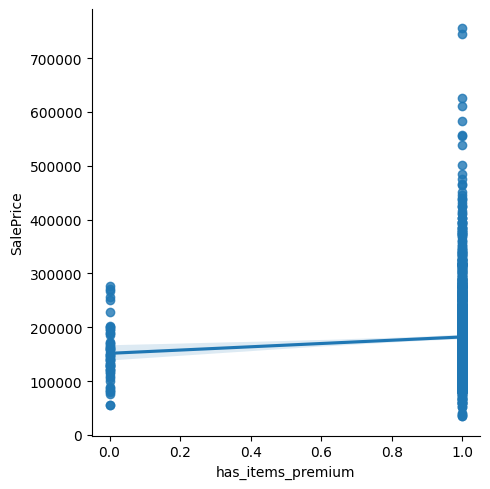

In [158]:
sns.lmplot(data=df, x='has_items_premium', y='SalePrice')

Conforme esperado, o range de SalePrice para imóveis que não possuem itens "premium" é maior, dada a baixa quantidade de valores preenchidos. Há uma baixa correlação com com SalePrice. Posteriormente, será analisada a possibilidade de remoção ou manutenção dessa feature. 

##### Alley

In [159]:
df.Alley.value_counts()

Alley
Grvl    120
Pave     78
Name: count, dtype: int64

<Axes: xlabel='Alley', ylabel='SalePrice'>

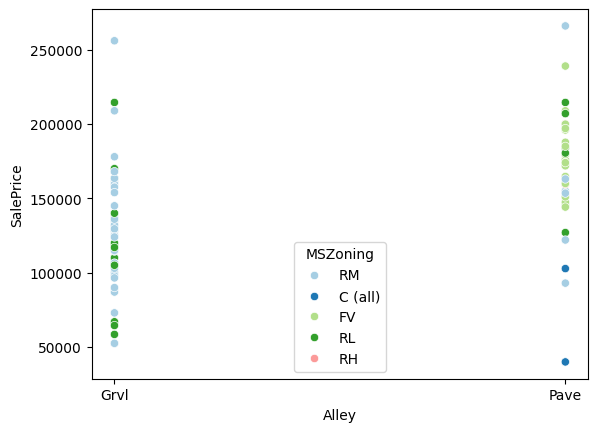

In [160]:
sns.scatterplot(data=df[~df.Alley.isna()], x='Alley', y='SalePrice', hue='MSZoning', palette=palete)

In [161]:
df['has_alley'] = df.Alley.map(lambda x: 0 if x in ['Grvl', 'Pave'] else 1)
df.drop(columns='Alley', inplace=True)

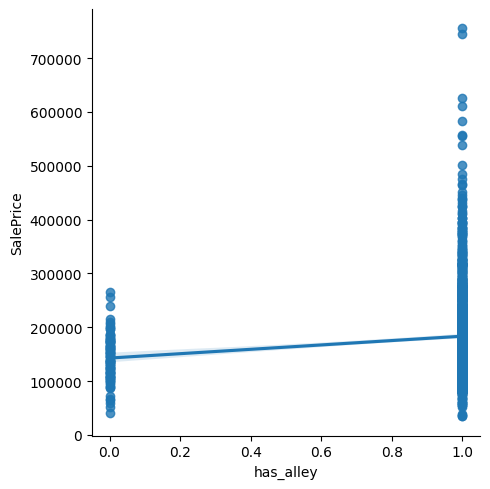

In [162]:
sns.lmplot(data=df, x='has_alley', y='SalePrice')

In [163]:
df[['has_alley', 'SalePrice']].corr(method='spearman')

has_alley  SalePrice
has_alley     1.0000     0.1263
SalePrice     0.1263     1.0000

##### Fence

In [164]:
df.Fence.value_counts()

Fence
MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: count, dtype: int64

<Axes: xlabel='Fence', ylabel='SalePrice'>

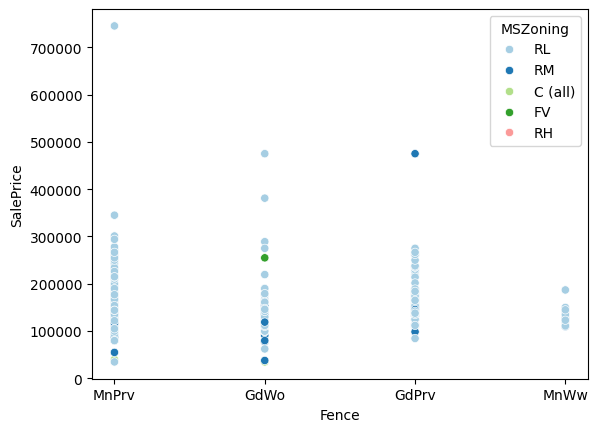

In [165]:
sns.scatterplot(data=df[~df.Fence.isna()], x='Fence', y='SalePrice', hue='MSZoning', palette=palete)

Há algo interessante aqui! A presença de cercas está muito correlacionada à imóveis localizados em zonas que possuem residenciais de baixa densidade. A exemplo do que foi feito com Alley e Miscfeature, iremos criar uma feature para indicar se existe ou não uma cerca. Após isso, removeremos a feature Fence. 

In [166]:
df['has_fence'] = df.Fence.map(lambda x: 0 if x in ['GdPrv', 'MnPrv', 'GdWo', 'MnWw'] else 1)
df.drop(columns='Fence', inplace=True)

In [167]:
df[['SalePrice', 'has_fence']].corr(method='spearman')

SalePrice  has_fence
SalePrice     1.0000     0.1988
has_fence     0.1988     1.0000

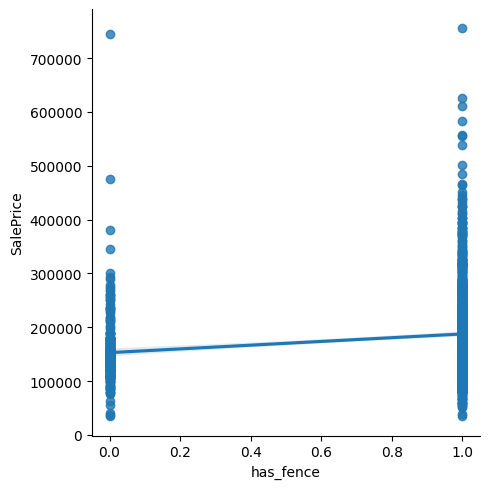

In [168]:
sns.lmplot(data=df, x='has_fence', y='SalePrice')

Embora possua uma correlação fraca, a feature é informativa. 

##### MasVnrType e MasVnrArea

Os atributos MasVnrArea e MasVnrType são relacionados. Se MasVnrArea for igual a zero, não faz sentido a coluna MasVnrType ter sido preenchida. 

In [169]:
df[(df['MasVnrArea']==0) & (~df['MasVnrType'].isna())][['MasVnrArea', 'MasVnrType']]

MasVnrArea MasVnrType
688       0.0000    BrkFace
1241      0.0000      Stone
859       0.0000    BrkFace

Também não faz sentido df['MasVnrArea'] > 0 e df['MasVnrType'].isna(). Também é curioso o fato de termos MasVnrArea com valor de 1 metro quadrado.

In [170]:
df[ (df['MasVnrArea'] > 0) & (df['MasVnrType'].isna())][['MasVnrArea', 'MasVnrType']]

MasVnrArea MasVnrType
624     288.0000        NaN
773       1.0000        NaN
1230      1.0000        NaN
1300    344.0000        NaN
1334    312.0000        NaN
209     285.0000        NaN
992       1.0000        NaN
1150    198.0000        NaN

In [171]:
df[df['MasVnrArea'] == 1]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
773    774          20       RL      70.0000    10150   Pave      Reg   
1230  1231          90       RL          NaN    18890   Pave      IR1   
992   2453          20       RM      52.0000     8626   Pave      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
773          Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1230         Lvl    AllPub    Inside       Gtl       Sawyer      Feedr   
992          Lvl    AllPub    Inside       Gtl      OldTown       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
773        Norm     1Fam     1Story            5            5       1958   
1230       RRAe   Duplex     1.5Fin            5            5       1977   
992        Norm     1Fam     1Story            4            6       1956   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
773           1958     Gable  CompShg     Wd Sdng     Wd Sdng        NaN   
1230          1977      Shed  CompShg     Plywood     Plywood        NaN   
992           1956     Gable  CompShg     MetalSd     MetalSd        NaN   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
773       1.0000        TA        TA     CBlock       TA       TA   
1230      1.0000        TA        TA     CBlock       Gd       TA   
992       1.0000        TA        TA     CBlock      NaN      NaN   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
773            No          Rec    456.0000          Unf      0.0000   
1230           No          GLQ    498.0000          Rec    211.0000   
992           NaN          NaN      0.0000          NaN      0.0000   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
773    456.0000     912.0000    GasA        Ex          Y      FuseA   
1230   652.0000    1361.0000    GasA        Ex          Y      SBrkr   
992      0.0000       0.0000    GasA        Gd          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
773        912         0             0        912        0.0000        0.0000   
1230      1361      1259             0       2620        0.0000        0.0000   
992        968         0             0        968        0.0000        0.0000   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
773          1         0             2             1          TA   
1230         2         2             4             2          TA   
992          1         0             2             1          TA   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
773              5        Typ           0         NaN     Attchd    1958.0000   
1230            12        Typ           1          TA    BuiltIn    1977.0000   
992              5        Typ           0         NaN     Attchd    1956.0000   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
773           RFn      1.0000    275.0000         TA         TA          Y   
1230          RFn      2.0000    600.0000         TA         TA          N   
992           Unf      1.0000    331.0000         Fa         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
773            0            0              0          0            0   
1230         155           24            145          0            0   
992            0            0              0          0            0   

      PoolArea  MiscVal  MoSold  YrSold SaleType SaleCondition   SalePrice  \
773          0        0       7    2007      COD        Normal 114500.0000   
1230         0     8300       8    2007       WD        Normal 190000.0000   
992          0        0       5    2007       WD        Normal         NaN   

      has_items_premium  has_alley  has_fence  
773                   1          1          1  
1230                  0

In [172]:
df.MasVnrArea.isna().sum() / df.shape[0]

0.0078794107571086

In [173]:
df[['SalePrice', 'MasVnrArea']].corr(method='spearman')

SalePrice  MasVnrArea
SalePrice      1.0000      0.4213
MasVnrArea     0.4213      1.0000

Considerando o baixo percentual de valores nulos para a coluna MasVnrArea (0.0078794107571086) e sua correlação com SalePrice, podemos fazer o preenchimento de valores nulos com a média agrupada pelo atributo de maior correlação. 

In [174]:
df[df.select_dtypes(include=['number']).columns].corr(method='spearman')['MasVnrArea'][:6].sort_values(ascending=False)

OverallQual    0.4276
LotFrontage    0.2738
LotArea        0.2034
MSSubClass    -0.0062
Id            -0.0279
OverallCond   -0.1831
Name: MasVnrArea, dtype: float64

In [175]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(df.groupby('OverallQual')['MasVnrArea'].transform('mean'))

Agora, temos outro problema para resolver. MasVnrArea possui 3 linhas com valor 0, mas possuem o MasVnrType diferente de NA. Iremos preencher esses valores com a média. MasVnrArea também possuimos 3 linhas com valor 1, mas com MasVnrType igual a NA. Para ambas as situações, substituiremos os valores pela média. 

In [176]:
masvnr_indices = df[(df['MasVnrArea'] <= 1) & (~df['MasVnrType'].isna())].index
mean_masvnr_area = df.groupby('OverallQual')['MasVnrArea'].transform('mean')
df.loc[masvnr_indices, 'MasVnrArea'] = df.loc[masvnr_indices, 'OverallQual'].map(mean_masvnr_area.to_dict())
df[(df['MasVnrArea'] <= 0) & (~df['MasVnrType'].isna())]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, has_items_premium, has_alley, has_fence]
Index: []

In [177]:
temp = df.copy()
temp['MasVnrType'] = LabelEncoder().fit_transform(temp[['MasVnrType']])

In [178]:
temp[['MasVnrType', 'MasVnrArea', 'SalePrice']].corr(method='spearman')

MasVnrType  MasVnrArea  SalePrice
MasVnrType      1.0000     -0.9194    -0.3410
MasVnrArea     -0.9194      1.0000     0.4266
SalePrice      -0.3410      0.4266     1.0000

Após fazer label encoder da feature MasVnrType, observamos que ela tem correlação muito forte com MasVnrArea. Em razão de possuir muitos valores nulos e ser altamente correlacionada com MasVnrArea, iremos removê-la.

In [179]:
df.drop(columns=['MasVnrType'], inplace=True)

##### Fireplaces e FireplaceQU

<Axes: xlabel='Fireplaces', ylabel='count'>

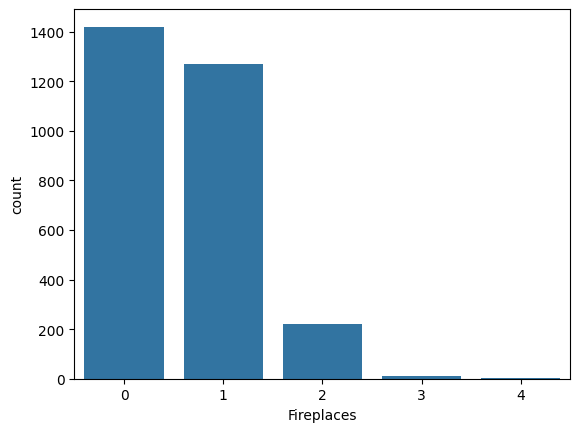

In [180]:
sns.barplot(df.Fireplaces.value_counts())

Não há fireplaces com valor nulo, mas há muitos imóveis que não possuem fireplaces. Vamos checar a consistência entre os campos Fireplaces e FireplaceQU.

In [181]:
df[ (df.Fireplaces == 0) & (~df.FireplaceQu.isna())]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, has_items_premium, has_alley, has_fence]
Index: []

In [182]:
df[ (df.Fireplaces > 0) & (df.FireplaceQu.isna())]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, has_items_premium, has_alley, has_fence]
Index: []

Há consistência entre Fireplaces e FireplaceQu.Isso significa que FireplaceQu deverá receber NA em todas as linhas em que Fireplaces for igual a zero.

In [183]:
condicao_fireplaces = df['Fireplaces'] == 0
df['FireplaceQu'] = df.FireplaceQu.mask(condicao_fireplaces, 'NA')
df['FireplaceQu'].isna().sum()

0

##### LotFrontage

In [184]:
df[['LotFrontage', 'LotArea', 'SalePrice']].corr()

LotFrontage  LotArea  SalePrice
LotFrontage       1.0000   0.4899     0.3518
LotArea           0.4899   1.0000     0.2638
SalePrice         0.3518   0.2638     1.0000

LotFrontage e LotArea tem correlação moderada, mas LotArea está em metros quadrados, enquanto LotFrontage está em metros lineares. Vamos fazer uma transformação e verificar se a correlação melhora.

In [185]:
dfc = df.copy()
dfc['sqrt_lot_area'] = np.log1p(dfc['LotArea'])
dfc[['LotFrontage', 'sqrt_lot_area', 'LotArea', 'SalePrice']].corr(method='spearman')

LotFrontage  sqrt_lot_area  LotArea  SalePrice
LotFrontage         1.0000         0.6571   0.6571     0.4091
sqrt_lot_area       0.6571         1.0000   1.0000     0.4565
LotArea             0.6571         1.0000   1.0000     0.4565
SalePrice           0.4091         0.4565   0.4565     1.0000

Muito bem, agora LotFrontage e sqrt_lot_area possuem correlação moderada. Iremos analisar essa combinação em gráficos de dispersão e reta de regressão.	

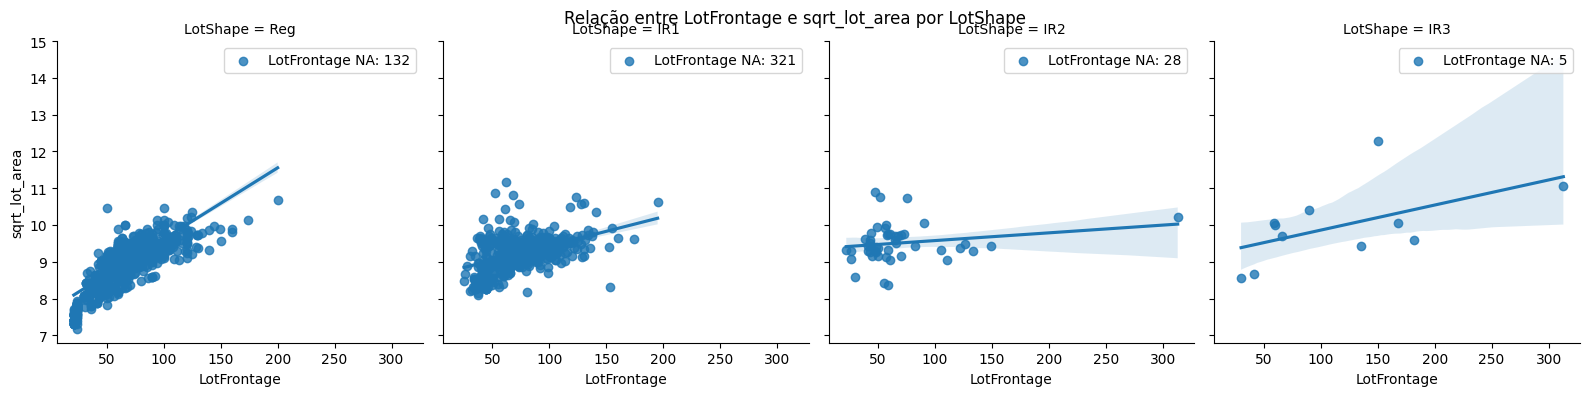

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calcular o número de valores NA em LotFrontage por LotShape
na_counts = dfc['LotFrontage'].isna().groupby(dfc['LotShape']).sum()

# Criar o FacetGrid
g = sns.FacetGrid(data=dfc[~dfc['LotFrontage'].isna()], col='LotShape', col_wrap=4, height=4)

# Aplicar o regplot a cada subplot
g.map(sns.regplot, 'LotFrontage', 'sqrt_lot_area')

# Adicionar a legenda com a contagem de NAs
for ax, title in zip(g.axes.flat, g.col_names):
    count_na = na_counts[title]
    ax.legend([f'LotFrontage NA: {int(count_na)}'], loc='upper right')

# Ajustar o layout
plt.subplots_adjust(top=0.9)
g.figure.suptitle('Relação entre LotFrontage e sqrt_lot_area por LotShape')

plt.show()

Utilizando regressão para preencher valores nulos de LotFrontage reg e ir1. Meu palpite é que quanto mais regular for o shape do lote, mais provável é que ele tenha uma forma de quadrado ou retângulo, fato que favorece a correlaçaõ entre lotfrontage transformado e a área do lote.

In [187]:
dfc[(dfc.LotFrontage.isna() & dfc.LotShape.isin(['Reg', 'IR1']))].shape[0]

453

In [188]:
# # Reseta o índice do DataFrame para garantir que seja único
# dfc.reset_index(drop=True, inplace=True)

# # Filtra os lotes regulares para preencher e para treino novamente
# lotes_regulares_para_preencher = dfc[(dfc.LotFrontage.isna()) & (dfc.LotShape == 'Reg')]
# lotes_regulares_para_treino = dfc[(~dfc.LotFrontage.isna()) & (dfc.LotShape == 'Reg')]

# # Prepara os dados de treino
# X_treino = lotes_regulares_para_treino[['sqrt_lot_area']]
# y_treino = lotes_regulares_para_treino['LotFrontage']

# # Inicializa e treina o modelo
# estimator = LinearRegression()
# estimator.fit(X_treino, y_treino)

# # Verifica o desempenho do modelo
# score = estimator.score(X_treino, y_treino)
# print(f"R^2 Score: {score}")

# # Prepara os dados para preenchimento
# X_preencher = lotes_regulares_para_preencher[['sqrt_lot_area', 'OverallQual', 'OverallCond']]

# # Faz a predição para 'LotFrontage'
# pre_lot_frontage_shape_reg = estimator.predict(X_preencher)

# # Converte o array de predições para uma Série com o mesmo índice que 'lotes_regulares_para_preencher'
# pre_lot_frontage_shape_reg_series = pd.Series(pre_lot_frontage_shape_reg, index=lotes_regulares_para_preencher.index)

# # Preenche os valores ausentes em 'LotFrontage' no DataFrame original
# dfc.loc[pre_lot_frontage_shape_reg_series.index, 'LotFrontage'] = pre_lot_frontage_shape_reg_series

In [189]:
dfc[(dfc.LotFrontage.isna() & dfc.LotShape.isin(['Reg', 'IR1']))].shape[0]

453

In [190]:
# # Reseta o índice do DataFrame para garantir que seja único
# dfc.reset_index(drop=True, inplace=True)

# # Filtra os lotes regulares para preencher e para treino novamente
# lotes_ir1_para_preencher = dfc[(dfc.LotFrontage.isna()) & (dfc.LotShape == 'IR1')]
# lotes_ir1_para_treino = dfc[(~dfc.LotFrontage.isna()) & (dfc.LotShape == 'IR1')]

# # Prepara os dados de treino
# X_treino = lotes_ir1_para_treino[['sqrt_lot_area', 'OverallQual', 'OverallCond']]
# y_treino = lotes_ir1_para_treino['LotFrontage']

# # Inicializa e treina o modelo
# estimator = XGBRegressor()
# estimator.fit(X_treino, y_treino)

# # Verifica o desempenho do modelo
# score = estimator.score(X_treino, y_treino)
# print(f"R^2 Score: {score}")

# # Prepara os dados para preenchimento
# X_preencher = lotes_ir1_para_preencher[['sqrt_lot_area', 'OverallQual', 'OverallCond']]

# # Faz a predição para 'LotFrontage'
# pred_lotes_ir1 = estimator.predict(X_preencher)

# # Converte o array de predições para uma Série com o mesmo índice que 'lotes_regulares_para_preencher'
# pre_lot_frontage_shape_irl_series = pd.Series(pred_lotes_ir1, index=lotes_ir1_para_preencher.index)

# # Preenche os valores ausentes em 'LotFrontage' no DataFrame original
# dfc.loc[pre_lot_frontage_shape_irl_series.index, 'LotFrontage'] = pre_lot_frontage_shape_irl_series

In [191]:
# dfc[(dfc.LotFrontage.isna() & dfc.LotShape.isin(['Reg', 'IR1']))].shape[0]

Agora, vamos analisar as retas de tendência de LotFrontage em conjunto com as classes de MSZoning.

In [192]:
# # Calcular o número de valores NA em LotFrontage por MSZoning
# na_counts = dfc['LotFrontage'].isna().groupby(dfc['MSZoning']).sum()

# # Função auxiliar para adicionar a legenda customizada
# def add_na_legend(na_counts, **kwargs):
#     plt.legend(title='LotFrontage NA count', labels=[f'{zone}: {int(count)}' for zone, count in na_counts.items()])

# # Criar o FacetGrid
# g = sns.FacetGrid(data=dfc[~dfc['LotFrontage'].isna()], col='MSZoning', col_wrap=3, height=4)

# # Aplicar o regplot a cada subplot
# g.map(sns.regplot, 'LotFrontage', 'sqrt_lot_area')

# # Adicionar a legenda com a contagem de NAs
# g.figure.legend(
#     handles=[plt.Line2D([], [], color='none') for _ in na_counts],  # Linhas invisíveis para a legenda
#     labels=[f'{zone}: {int(count)} NA' for zone, count in na_counts.items()],
#     title='LotFrontage NA count',
#     loc='upper right'
# )

# # Ajustar o layout
# plt.subplots_adjust(top=0.9)
# g.figure.suptitle('Relação entre LotFrontage e sqrt_lot_area por MSZoning')

# plt.show()

MSZoning RM e FV tem uma inclinação de reta muito próxima, como também os dados estão dispersos em torno da reta de forma similar. Por essa razão, iremos processá-los juntos.

In [193]:
# # Reseta o índice do DataFrame para garantir que seja único
# dfc.reset_index(drop=True, inplace=True)

# # Filtra os lotes regulares para preencher e para treino novamente
# para_preencher = dfc[(dfc.LotFrontage.isna()) & (dfc.MSZoning.isin(['RM', 'FV']))]
# para_treino = dfc[(~dfc.LotFrontage.isna()) & (dfc.MSZoning.isin(['RM', 'FV']))]

# # Prepara os dados de treino
# X_treino = para_treino[['sqrt_lot_area', 'OverallQual', 'OverallCond']]
# y_treino = para_treino['LotFrontage']

# # Inicializa e treina o modelo
# estimator = XGBRegressor()
# estimator.fit(X_treino, y_treino)

# # Verifica o desempenho do modelo
# score = estimator.score(X_treino, y_treino)
# print(f"R^2 Score: {score}")

# # Prepara os dados para preenchimento
# X_preencher = para_preencher[['sqrt_lot_area', 'OverallQual', 'OverallCond']]

# # Faz a predição para 'LotFrontage'
# pred_lot_frontage = estimator.predict(X_preencher)

# # Converte o array de predições para uma Série com o mesmo índice que 'lotes_regulares_para_preencher'
# pred_lot_frontage_series = pd.Series(pred_lot_frontage, index=para_preencher.index)

# # Preenche os valores ausentes em 'LotFrontage' no DataFrame original
# dfc.loc[pred_lot_frontage_series.index, 'LotFrontage'] = pred_lot_frontage_series

In [194]:
# dfc[(dfc.LotFrontage.isna() & dfc.MSZoning.isin(['RM', 'FV']))].shape[0]

Após isso, iremos processar MSZoning == RL

In [195]:
# # Reseta o índice do DataFrame para garantir que seja único
# dfc.reset_index(drop=True, inplace=True)

# # Filtra os lotes regulares para preencher e para treino novamente
# para_preencher = dfc[(dfc.LotFrontage.isna()) & (dfc.MSZoning.isin(['RL']))]
# para_treino = dfc[(~dfc.LotFrontage.isna()) & (dfc.MSZoning.isin(['RL']))]

# # Prepara os dados de treino
# X_treino = para_treino[['sqrt_lot_area', 'OverallQual', 'OverallCond']]
# y_treino = para_treino['LotFrontage']

# # Inicializa e treina o modelo
# estimator = XGBRegressor()
# estimator.fit(X_treino, y_treino)

# # Verifica o desempenho do modelo
# score = estimator.score(X_treino, y_treino)
# print(f"R^2 Score: {score}")

# # Prepara os dados para preenchimento
# X_preencher = para_preencher[['sqrt_lot_area', 'OverallQual', 'OverallCond']]

# # Faz a predição para 'LotFrontage'
# pred_lot_frontage = estimator.predict(X_preencher)

# # Converte o array de predições para uma Série com o mesmo índice que 'lotes_regulares_para_preencher'
# pred_lot_frontage_series = pd.Series(pred_lot_frontage, index=para_preencher.index)

# # Preenche os valores ausentes em 'LotFrontage' no DataFrame original
# dfc.loc[pred_lot_frontage_series.index, 'LotFrontage'] = pred_lot_frontage_series

In [196]:
# dfc[(dfc.LotFrontage.isna() & dfc.MSZoning.isin(['RM', 'FV']))].shape[0]

Após todo esse tratamento de dados, não há mais valores nulos. 

In [197]:
# dfc.LotShape.isna().sum()

##### Garage

In [198]:
df[['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType', 'GarageCars', 'GarageArea']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageQual    2760 non-null   object 
 1   GarageCond    2760 non-null   object 
 2   GarageFinish  2760 non-null   object 
 3   GarageType    2762 non-null   object 
 4   GarageCars    2918 non-null   float64
 5   GarageArea    2918 non-null   float64
dtypes: float64(2), object(4)
memory usage: 224.2+ KB


Vamos iniciar a análise das features checando possíveis inconsistências entre a GarageArea e as demais features.

In [199]:
df[ (df.GarageArea==0) & (df.GarageCars==0)][['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType', 'GarageCars', 'GarageArea', 'GarageYrBlt']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 39 to 1457
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageQual    0 non-null      object 
 1   GarageCond    0 non-null      object 
 2   GarageFinish  0 non-null      object 
 3   GarageType    0 non-null      object 
 4   GarageCars    157 non-null    float64
 5   GarageArea    157 non-null    float64
 6   GarageYrBlt   0 non-null      float64
dtypes: float64(3), object(4)
memory usage: 9.8+ KB


Faz todo sentido que os valores de GarageQual, GarageCond, GarageFinish e GarageType estejam com todos os valores nulos quando não houver garagem (GarageArea==0). Por essa razão, devem ser preenchidos com os valores indicados no data_description fornecido pelo kaggle.

In [200]:
condition = df.GarageArea == 0    
df[['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']] = df[['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']].mask(condition, 'NA')
df['GarageArea'] = df['GarageArea'].mask(condition, 0)

Verificando se ainda existem valores nulos.

In [201]:
df[['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType', 'GarageCars']].isna().sum()

GarageQual      2
GarageCond      2
GarageFinish    2
GarageType      0
GarageCars      1
dtype: int64

In [202]:
df['GarageQual'] = df['GarageArea'].fillna(df.GarageQual.mode()[0])
df['GarageCond'] = df['GarageYrBlt'].fillna(df.GarageCond.mode()[0])
df['GarageFinish'] = df['GarageFinish'].fillna(df.GarageFinish.mode()[0])

In [203]:
df[['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']].isna().sum()

GarageQual      0
GarageCond      0
GarageFinish    0
GarageType      0
dtype: int64

In [204]:
df[df.GarageArea==0][['GarageArea', 'GarageYrBlt']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 39 to 1457
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GarageArea   157 non-null    float64
 1   GarageYrBlt  0 non-null      float64
dtypes: float64(2)
memory usage: 3.7 KB


Todos os valores de GarageYrBlt são nulos quando GarageArea==0. Isso faz todo sentido, mas temos um problema. Qual o valor que será utilizado para preencher os 157 linhas nulas? Não seria melhor remover?

In [205]:
df[['GarageArea', 'GarageYrBlt', 'SalePrice']].corr()

GarageArea  GarageYrBlt  SalePrice
GarageArea       1.0000       0.5558     0.6234
GarageYrBlt      0.5558       1.0000     0.4864
SalePrice        0.6234       0.4864     1.0000

Iremos preencher os valores nulos de GarageYrBlt com 0. 

In [206]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

In [207]:
df[['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType', 'GarageYrBlt', 'GarageArea']].isna().sum()

GarageQual      0
GarageCond      0
GarageFinish    0
GarageType      0
GarageYrBlt     0
GarageArea      1
dtype: int64

O único valor nulo de GarageArea será preenchido com a média da coluna.

In [208]:
df['GarageArea'] = df['GarageArea'].fillna(df['GarageArea'].mean())

##### Basement

In [209]:
cols = ['BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
df[cols].isna().sum()


BsmtCond        82
BsmtQual        81
BsmtExposure    82
BsmtFinType1    79
BsmtFinType2    80
BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
dtype: int64

Vamos iniciar checando a existência de ausentes a partir de TotalBsmtSF.

In [210]:
df[(df.TotalBsmtSF == 0)][cols].isna().sum()

BsmtCond        78
BsmtQual        78
BsmtExposure    78
BsmtFinType1    78
BsmtFinType2    78
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
BsmtFullBath     1
BsmtHalfBath     1
dtype: int64

Todas as linhas das colunas 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' deverão ser preenchidas com NA.

In [211]:
condition01 = df['TotalBsmtSF'] == 0
cols = ['BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
df[cols] = df[cols].mask(condition01, 'NA')

In [212]:
df.BsmtFullBath = df.BsmtFullBath.fillna(0)
df.BsmtHalfBath = df.BsmtHalfBath.fillna(0)

Agora, os valores resituais serão preenchidos com a moda ou a média, dada a baixa quantidade de registros.

In [213]:
df[cols].isna().sum()

BsmtCond        4
BsmtQual        3
BsmtExposure    4
BsmtFinType1    1
BsmtFinType2    2
dtype: int64

In [214]:
df.TotalBsmtSF = df.TotalBsmtSF.fillna(df.TotalBsmtSF.mean())
df.BsmtFinSF1 = df.BsmtFinSF1.fillna(df.BsmtFinSF1.mean())
df.BsmtFinSF2 = df.BsmtFinSF2.fillna(df.BsmtFinSF2.mean())
df.BsmtUnfSF = df.BsmtUnfSF.fillna(df.BsmtUnfSF.mean())

In [215]:
df[cols].isna().sum()

BsmtCond        4
BsmtQual        3
BsmtExposure    4
BsmtFinType1    1
BsmtFinType2    2
dtype: int64

In [216]:
mode_cols = ['BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for col in mode_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [217]:
df[cols].isna().sum()

BsmtCond        0
BsmtQual        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64

#### Funções

In [218]:
def processar_pool_qc(dataframe: pd.DataFrame, deletar: bool = True) -> pd.DataFrame:   
    dataframe.drop(columns=['PoolQC'], inplace=True)
    return dataframe

In [219]:
def processar_misc_feature(dataframe: pd.DataFrame) -> pd.DataFrame:   
    # dataframe['has_items_premium'] = dataframe['MiscFeature'].map(lambda x: 0 if x in ['Shed', 'Gar2', 'Othr', 'TenC'] else 1)
    dataframe.drop(columns=['MiscFeature'], inplace=True)
    return dataframe

In [220]:
def processar_alley(dataframe: pd.DataFrame, operacao: int = 1) -> pd.DataFrame:
    # dataframe['has_alley'] = dataframe.Alley.map(lambda x: 0 if x in ['Grvl', 'Pave'] else 1)
    dataframe.drop(columns='Alley', inplace=True)
    return dataframe

In [221]:
def processar_fence(dataframe: pd.DataFrame) -> pd.DataFrame:   
    # dataframe['has_fence'] = dataframe.Fence.map(lambda x: 0 if x in ['GdPrv', 'MnPrv', 'GdWo', 'MnWw'] else 1)
    dataframe.drop(columns='Fence', inplace=True)
    return dataframe

In [222]:
def processar_mas_vn_area_mas_vnr_type(dataframe: pd.DataFrame) -> pd.DataFrame:   
    qtd_nulos = dataframe.MasVnrArea.isna().sum()
    
    # Preenchendo valores nulos com a média
    dataframe.MasVnrArea = dataframe.groupby(by=['OverallQual'])['MasVnrArea'].transform('mean')

    # preenchendo com a média valores de df['MasVnrArea'] == 0 que possuem MasVnrType válido
    masvnr_indices = dataframe[(dataframe['MasVnrArea'] == 0) & (~dataframe['MasVnrType'].isna())].index
    mean_masvnr_area = dataframe.groupby('OverallQual')['MasVnrArea'].transform('mean')
    dataframe.loc[masvnr_indices, 'MasVnrArea'] = dataframe.loc[masvnr_indices, 'OverallQual'].map(mean_masvnr_area.to_dict())    

    # dataframe.drop(columns=['MasVnrType'], inplace=True)
    dataframe.MasVnrType = LabelEncoder().fit_transform(dataframe[['MasVnrType']])
    dataframe.MasVnrArea = np.log1p(dataframe.MasVnrArea)

    display_logs(f"MasVnrArea - {qtd_nulos} valores preenchidos com a média. A coluna MasVnrType foi removida.")
    
    return dataframe

In [223]:
def processar_fireplace_qual(dataframe: pd.DataFrame) -> pd.DataFrame:   
    condicao_fireplaces = dataframe['Fireplaces'] == 0
    dataframe['FireplaceQu'] = dataframe.FireplaceQu.mask(condicao_fireplaces, 'NA')
        
    return dataframe

In [224]:
def processar_lot_frontage_shape_reg_ir1(dataframe: pd.DataFrame) -> pd.DataFrame:

    dataframe['lot_area_log1p'] =  np.log1p(dataframe['LotArea'])

    for shape in ['Reg', 'IR1']:
        # Filtra os lotes para preencher e para treino novamente
        to_fill = dataframe[(dataframe.LotFrontage.isna()) & (dataframe.LotShape == shape)]
        to_train = dataframe[(~dataframe.LotFrontage.isna()) & (dataframe.LotShape == shape)]

        # Prepara os dados de treino
        X_train = to_train[['lot_area_log1p', 'OverallQual', 'OverallCond']]
        y_train = to_train['LotFrontage']

        # Inicializa e treina o modelo
        estimator = LinearRegression()
        estimator.fit(X_train, y_train)

        # Itera sobre cada entrada a ser preenchida
        for index, row in to_fill.iterrows():
            # Prepara os dados para preenchimento
            X_fill = row[['lot_area_log1p', 'OverallQual', 'OverallCond']].values.reshape(1, -1)

            # Faz a predição para 'LotFrontage'
            pred = estimator.predict(X_fill)[0]

            # Preenche o valor ausente em 'LotFrontage' no DataFrame original
            dataframe.at[index, 'LotFrontage'] = pred

    dataframe.drop(columns=['lot_area_log1p'], inplace=True)

    return dataframe

In [225]:
def processar_lot_frontage_shape_mszoning(dataframe: pd.DataFrame) -> pd.DataFrame:

    dataframe['lot_area_log1p'] =  np.log1p(dataframe['LotArea'])

    for zoning in ['RM', 'FV', 'RL']:
        # Filtra os lotes para preencher e para treino novamente
        to_fill = dataframe[(dataframe.LotFrontage.isna()) & (dataframe.MSZoning == zoning)]
        to_train = dataframe[(~dataframe.LotFrontage.isna()) & (dataframe.MSZoning == zoning)]

        # Prepara os dados de treino
        X_train = to_train[['lot_area_log1p', 'OverallQual', 'OverallCond']]
        y_train = to_train['LotFrontage']

        # Inicializa e treina o modelo
        estimator = LinearRegression()
        estimator.fit(X_train, y_train)

        for index, row in to_fill.iterrows():
            # Prepara os dados para preenchimento
            X_fill = row[['lot_area_log1p', 'OverallQual', 'OverallCond']].values.reshape(1, -1)

            # Faz a predição para 'LotFrontage'
            pred = estimator.predict(X_fill)[0]

            # Preenche o valor ausente em 'LotFrontage' no DataFrame original
            dataframe.at[index, 'LotFrontage'] = pred
    
    dataframe.drop(columns=['lot_area_log1p'], inplace=True)

    return dataframe

In [226]:
def processar_garagens(dataframe: pd.DataFrame) -> pd.DataFrame:
    condition = dataframe.GarageArea == 0    
    dataframe[['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']] = dataframe[['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']].mask(condition, 'NA')   
    dataframe['GarageArea'] = dataframe['GarageArea'].mask(condition, 0)

    dataframe['GarageQual'] = dataframe['GarageQual'].fillna(dataframe.GarageQual.mode()[0])
    dataframe['GarageCond'] = dataframe['GarageYrBlt'].fillna(dataframe.GarageCond.mode()[0])
    dataframe['GarageFinish'] = dataframe['GarageFinish'].fillna(dataframe.GarageFinish.mode()[0])
    dataframe['GarageYrBlt'] = dataframe['GarageYrBlt'].fillna(0)
    dataframe['GarageCars'] = dataframe['GarageCars'].fillna(dataframe['GarageCars'].mode()[0])
    dataframe['GarageArea'] = dataframe['GarageCars'].fillna(dataframe['GarageArea'].mean())

    return dataframe

In [227]:
def processar_basement(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    condition01 = dataframe['TotalBsmtSF'] == 0
    cols = ['BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    dataframe[cols] = dataframe[cols].mask(condition01, 'NA')

    dataframe.BsmtFullBath = dataframe.BsmtFullBath.fillna(0)
    dataframe.BsmtHalfBath = dataframe.BsmtHalfBath.fillna(0)

    area_quadrada_nulos = dataframe.TotalBsmtSF.isna().sum()
    display_logs(f"['BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] - {area_quadrada_nulos} registros preenchidos com NA se TotalBsmtSF igual a 0")

    dataframe.TotalBsmtSF = dataframe.TotalBsmtSF.fillna(dataframe.TotalBsmtSF.mean())
    dataframe.BsmtFinSF1 = dataframe.BsmtFinSF1.fillna(dataframe.BsmtFinSF1.mean())
    dataframe.BsmtFinSF2 = dataframe.BsmtFinSF2.fillna(dataframe.BsmtFinSF2.mean())
    dataframe.BsmtUnfSF = dataframe.BsmtUnfSF.fillna(dataframe.BsmtUnfSF.mean())

    dataframe['bsmt_fin_types'] = dataframe[['BsmtFinType1', 'BsmtFinType2']].apply(lambda row: f'{row.BsmtFinType1}-{row.BsmtFinType2}', axis=1)
    dataframe['bsmt_fin_types_count'] = dataframe.groupby(by=['BsmtQual'])['bsmt_fin_types'].transform('count')

    mode_cols = ['BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    for col in mode_cols:
        dataframe[col] = dataframe[col].fillna(dataframe[col].mode()[0])

    return dataframe

In [228]:
def preencher_com_moda(series):
    if series.isna().all():
        return series  # Retorna a série como está se todos os valores são nulos
    mode_value = series.mode()[0] if not series.mode().empty else series
    return series.fillna(mode_value)

In [229]:
def processar_electrical(dataframe: pd.DataFrame) -> pd.DataFrame:
    qtd_nulos = dataframe['Electrical'].isna().sum()
    moda = dataframe['Electrical'].mode()[0]  # Pega o primeiro valor da moda
    dataframe['Electrical'] = dataframe['Electrical'].fillna(moda)
    display_logs(f"Electrical: {qtd_nulos} valores nulos processados com a moda '{moda}'")
    return dataframe

In [230]:
def processar_utilities(dataframe: pd.DataFrame) -> pd.DataFrame:

    df = dataframe.copy()
    qtde_nulos = df.Utilities.isna().sum()
    
    if qtde_nulos > 0:
        df['Utilities'] = df.groupby(by=['MSZoning', 'OverallQual'])['Utilities'].transform(preencher_com_moda)
        display_logs(f'Utilities: {qtde_nulos} registros preenchidos com a moda.')

        # Preenchendo valores residuais, caso existam
        df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])

    return df

In [231]:
def processar_functional(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    qtde_nulos = dataframe.Functional.isna().sum()
    
    if qtde_nulos > 0:
        dataframe['Functional'] = dataframe['Functional'].fillna('Typ')
        display_logs(f'Functional: {qtde_nulos} registros preenchidos')

    return dataframe

In [232]:
def processar_kitchen_qual(dataframe: pd.DataFrame) -> pd.DataFrame:
    qtde_nulos = dataframe.KitchenQual.isna().sum()
    dataframe['KitchenQual'] = dataframe.groupby(by=['OverallQual', 'GrLivArea', 'KitchenAbvGr'])['KitchenQual'].transform(preencher_com_moda)
    display_logs(f'KitchenQual: {qtde_nulos} registros preenchidos com a moda')

    return dataframe

In [233]:
def processar_sale_type(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    qtde_nulos = dataframe.SaleType.isna().sum()
    
    if qtde_nulos > 0:
        dataframe['SaleType'] = dataframe['SaleType'].fillna(dataframe['SaleType'].mode()[0])
        display_logs(f'SaleType: {qtde_nulos} registros preenchidos com KNN')

    return dataframe

In [234]:
def processar_lot_frontage(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe.LotFrontage = dataframe.LotFrontage.fillna(dataframe.groupby(['LotShape', 'Neighborhood'])['LotFrontage'].transform('mean'))
    dataframe.LotFrontage = dataframe.LotFrontage.fillna(dataframe.LotFrontage.median())
    dataframe.lot_frontage_log1p = np.log1p(dataframe.LotFrontage)
    adicionar_caracteristicas_fortemente_correlacionadas('LotFrontage')
    return dataframe

### Encodings

In [235]:
def processar_encodings_com_gradacao(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    d1 = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
    d2 = {'GLQ': 6, 'ALQ':  5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}

    dataframe['BsmtQual'] = dataframe['BsmtQual'].replace(d1).astype('Int64')
    dataframe['BsmtCond'] = dataframe['BsmtCond'].replace(d1).astype('Int64')
    dataframe['BsmtExposure'] = dataframe['BsmtExposure'].replace({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}).astype('Int64') 
    # dataframe['BsmtFinType1'] = dataframe['BsmtFinType2'].replace(d2).astype('Int64')  
    # dataframe['BsmtFinType2'] = dataframe['BsmtFinType2'].replace(d2).astype('Int64')
    
    dataframe['GarageCond'] = dataframe['GarageCond'].replace(d1).astype('Int64')
    dataframe['GarageQual'] = dataframe['GarageQual'].replace(d1).astype('Int64')
    dataframe['GarageFinish'] = dataframe['GarageFinish'].replace({'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}).astype('Int64')
    
    dataframe['KitchenQual'] = dataframe['KitchenQual'].replace(d1).astype('Int64')
    dataframe['ExterQual'] = dataframe['ExterQual'].replace(d1).astype('Int64')
    dataframe['ExterCond'] = dataframe['ExterCond'].replace(d1).astype('Int64')
    
    dataframe['HeatingQC'] = dataframe['HeatingQC'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}).astype('Int64')
    dataframe['Functional'] = dataframe['Functional'].replace({'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1}).astype('Int64')
    dataframe['Utilities'] = dataframe['Utilities'].replace({'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1}) 

    dataframe['FireplaceQu'] = dataframe['FireplaceQu'].replace(d1).astype('Int64')

    # Os atributos abaixo podem ser processados com One-Hot Encoding, caso necessário.
    dataframe['LandSlope'] = dataframe['LandSlope'].replace({'Gtl': 3, 'Mod': 2, 'Sev': 1}).astype('Int64')
    dataframe['LandContour'] = dataframe['LandContour'].replace({'Lvl': 4, 'Bnk': 3, 'HLS': 2, 'Low': 1}).astype('Int64')
    dataframe['LotShape'] = dataframe['LotShape'].replace({'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1}).astype('Int64')
    dataframe['LotConfig'] = dataframe['LotConfig'].replace({'CulDSac': 5, 'FR3': 4, 'Corner': 3, 'FR2': 2, 'Inside': 1}).astype('Int64') 
    dataframe['PavedDrive'] = dataframe['PavedDrive'].replace({'Y': 3, 'P': 2, 'N': 1}).astype('Int64')
    dataframe['CentralAir'] = dataframe['CentralAir'].replace({'Y': 1, 'N': 0}).astype('Int64')
    dataframe['Electrical'] = dataframe['Electrical'].replace({'SBrkr': 5, 'FuseA': 4, 'Mix': 3, 'FuseF': 2, 'FuseP': 1}).astype('Int64')
    

    # dataframe['PoolQC'] = dataframe['PoolQC'].replace({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0}).astype('Int64')
    # dataframe['FireplaceQu'] = dataframe['FireplaceQu'].replace(d1).astype('Int64')
    # dataframe['Street'] = dataframe['Street'].replace({'Grvl': 1, 'Pave': 2}).astype('Int64')

    display_logs("Processando encodings com gradação ...")

    return dataframe

In [236]:
def processar_one_hot_encoding(dataframe: pd.DataFrame, columns_to_ohe: list) -> pd.DataFrame:
    # Armazena as colunas originais
    colunas_originais = set(dataframe.columns)

    # Converte as colunas selecionadas para o tipo 'category'
    for feature in columns_to_ohe:
        dataframe[feature] = dataframe[feature].astype('category')
    
    # Aplica o One Hot Encoding
    df_encoded = pd.get_dummies(data=dataframe, columns=columns_to_ohe, drop_first=True)

    # Armazena as colunas após a transformação
    colunas_apos_transformacao = set(df_encoded.columns)

    # Identifica as colunas adicionadas
    global colunas_transformadas_ohe
    colunas_transformadas_ohe = list(colunas_apos_transformacao - colunas_originais)

    # Converte colunas booleanas para inteiros
    for col in df_encoded.select_dtypes(include=['bool']).columns:
        df_encoded[col] = df_encoded[col].astype(int)

    # Exibe logs
    display_logs(f"One Hot Encoding processado para: {columns_to_ohe}")
    
    return df_encoded


### Criação de Features

In [237]:
def obter_dataframe_preco_metro_quadrado(df: pd.DataFrame, col: str) -> pd.DataFrame:

    dataframe = df.copy()

    # Calcular a área total (substitua 'LotArea' pelo nome da coluna correta)
    if 'total_area' not in dataframe.columns:
        dataframe['total_area'] = dataframe['GrLivArea'] + dataframe['TotalBsmtSF']  
    
    col_name = f'preco_metro_quadrado_{col}'

    # Calcular o preço por metro quadrado
    dataframe[col_name] = dataframe['SalePrice'] / dataframe['total_area']
    
    # Agrupar por bairro e calcular a média
    series_mean = dataframe.groupby(by=[col])[col_name].mean()
    
    # Transformar em DataFrame e ajustar o nome da coluna
    df_preco_m2_por_categoria = pd.DataFrame(series_mean).reset_index()
    
    df_preco_m2_por_categoria[col_name] = df_preco_m2_por_categoria[col_name].fillna(series_mean.mean())

    return df_preco_m2_por_categoria


In [238]:
def adicionar_preco_metro_quadrado(dataframe: pd.DataFrame, col: str) -> pd.DataFrame:
    df_preco_metro_quadrado = obter_dataframe_preco_metro_quadrado(df=dataframe, col=col)
    dataframe = pd.merge(left=dataframe, right=df_preco_metro_quadrado, how='left', on=[col, col])
    display_logs("Feature adicionada: preco_metro_quadrado")
    return dataframe

In [239]:
def criar_area_total(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['total_area'] = dataframe['GrLivArea'] + dataframe['TotalBsmtSF']
    display_logs("Feature total_area adicionada")
    global features_criadas
    features_criadas.append('total_area')
    return dataframe

In [240]:
def remover_outliers(dataframe: pd.DataFrame) -> pd.DataFrame:
    try:
        outliers = dataframe[dataframe['TotalBsmtSF'] > 3000]
        dataframe.drop(index=outliers.index, inplace=True)
    except:
        pass

    try:
        outliers = dataframe[dataframe.GrLivArea > 4000]
        dataframe = dataframe.drop(index=outliers.index)
    except:
        pass
    
    try:
        outliers = dataframe[dataframe.LotArea > 100000]
        dataframe.drop(index=outliers.index)
    except:
        pass

    return dataframe

In [241]:
def processar_gr_liv_area(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    # dataframe['GrLivArea_log1p'] = np.log1p(dataframe['GrLivArea'])
    dataframe['perc_grlivarea_high_qual'] = (dataframe.GrLivArea - dataframe.LowQualFinSF / dataframe.GrLivArea) * (dataframe.OverallQual + dataframe.OverallCond)

    dataframe.drop(columns=['1stFlrSF', '2ndFlrSF'], inplace=True)
    dataframe.drop(columns=['LowQualFinSF'], inplace=True)

    dataframe['perc_grlivarea_high_qual_log1p'] = np.log1p(dataframe['perc_grlivarea_high_qual'])
    adicionar_caracteristicas_fortemente_correlacionadas('perc_grlivarea_high_qual')
    
    adicionar_features_criadas('perc_grlivarea_high_qual_log1p')
    adicionar_caracteristicas_fortemente_correlacionadas('GrLivArea')
    # adicionar_features_criadas('GrLivArea_log1p')

    return dataframe

In [242]:
def calc_perc_bsmt_finish(row: pd.Series):
    finished = row.TotalBsmtSF - row.BsmtUnfSF
    perc = np.nan_to_num(finished/row.TotalBsmtSF) * np.exp2((row.BsmtQual  + row.BsmtCond))
    return perc 

In [243]:
def processar_basement_atributos(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    dataframe['perc_bsmt_finish'] = dataframe[['TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtQual', 'BsmtCond', 'BsmtExposure']].apply(calc_perc_bsmt_finish, axis=1)
    adicionar_features_criadas('perc_bsmt_finish')

    dataframe['bsmt_fin_types'] = dataframe[['BsmtFinType1', 'BsmtFinType2']].apply(lambda row: f'{row.BsmtFinType1}-{row.BsmtFinType2}', axis=1)
    dataframe['bsmt_fin_types_count'] = dataframe.groupby(by=['BsmtQual'])['bsmt_fin_types'].transform('count')

    # dataframe['bsmt_exposure_count'] = dataframe.groupby(by=['BsmtQual'])['BsmtExposure'].transform('count')

    adicionar_caracteristicas_fortemente_correlacionadas('BsmtFinSF1')
    adicionar_caracteristicas_fortemente_correlacionadas('BsmtFinSF2')
    adicionar_features_criadas('perc_bsmt_finish')

    # adicionar_caracteristicas_fortemente_correlacionadas('BsmtCond')
    # adicionar_caracteristicas_fortemente_correlacionadas('BsmtQual')


    return dataframe

In [244]:
def processar_atributos_qualidade(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    dataframe['OverallQual'] = dataframe['OverallQual'].replace({1: 2, 10: 9})
    dataframe['BsmtQual'] = dataframe['BsmtQual'].replace({0: 2})
    dataframe['BsmtCond'] = dataframe['BsmtCond'].replace({0: 1})
    dataframe['OverallCond'] = dataframe['OverallCond'].replace({9: 7, 8: 7, 6: 7, 5: 7, 4: 7, 3: 7})
    dataframe['ExterCond'] = dataframe['ExterCond'].replace({5: 4, 3: 4})

    dataframe['index_qual_global'] = dataframe.OverallQual + dataframe.ExterQual + dataframe.BsmtQual + (dataframe.KitchenQual * dataframe.KitchenAbvGr) + (dataframe.GarageQual * dataframe.GarageCars)
    dataframe['index_cond_global'] = dataframe.OverallCond + dataframe.ExterCond + dataframe.BsmtCond + dataframe.GarageCond
    
    adicionar_features_criadas('index_qual_global')
    adicionar_caracteristicas_fortemente_correlacionadas('OverallQual')
    adicionar_caracteristicas_fortemente_correlacionadas('ExterQual')
    adicionar_caracteristicas_fortemente_correlacionadas('BsmtQual')

    adicionar_caracteristicas_fortemente_correlacionadas('KitchenQual')
    adicionar_caracteristicas_fortemente_correlacionadas('GarageQual')

    adicionar_caracteristicas_fortemente_correlacionadas('OverallCond')
    adicionar_caracteristicas_fortemente_correlacionadas('ExterCond')
    adicionar_caracteristicas_fortemente_correlacionadas('BsmtCond')
    adicionar_caracteristicas_fortemente_correlacionadas('GarageCond')

    return dataframe

In [245]:
def get_age_cat(age_house):
    if age_house <= 5:
        return 5
    elif age_house <= 15:
        return 4
    elif age_house <= 30:
        return 3
    elif age_house <= 50:
        return 2
    elif age_house < 200:
        return 1
    else:
        return 0

In [246]:
def processar_atributos_de_tempo(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['age_house'] = dataframe[['YrSold', 'YearBuilt']].apply(lambda x: x[0] - x[1] if x[0] != x[1] else 0.1, axis=1)
    dataframe['age_remode'] = dataframe[['YrSold', 'YearRemodAdd', 'age_house']].apply(lambda x: x[0] - x[1] if (x[0] != x[1] and x[1] > 0) else x[2], axis=1)

    dataframe['index_qual_area'] = (np.sqrt( dataframe['GrLivArea'] + dataframe['TotalBsmtSF']) / dataframe['age_house']) * dataframe['OverallQual']
    dataframe['age_cat'] = dataframe['age_house'].map(get_age_cat)
    dataframe['age_cat'] = dataframe.groupby(by=['age_cat'])['age_cat'].transform('count')

    adicionar_caracteristicas_fortemente_correlacionadas('age_house')
    adicionar_caracteristicas_fortemente_correlacionadas('age_remode')

    return dataframe

In [247]:
def processar_garagem_atributos(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['index_garage_area'] = np.nan_to_num(dataframe.GarageArea * dataframe.GarageCars * dataframe.GarageCond)
    adicionar_caracteristicas_fortemente_correlacionadas('GarageArea')
    adicionar_caracteristicas_fortemente_correlacionadas('GarageCars')
    adicionar_caracteristicas_fortemente_correlacionadas('GarageCond')

    return dataframe

In [248]:
def processar_atributos_comodos(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['total_rooms_abvgr'] = dataframe.TotRmsAbvGrd + dataframe['FullBath'] + (dataframe['HalfBath'])
    dataframe['total_bath_rooms'] = (dataframe.BsmtFullBath) + dataframe.BsmtHalfBath + (dataframe.FullBath) + dataframe.HalfBath
    dataframe['bedrooms_per_totalrooms'] = dataframe.BedroomAbvGr / dataframe.TotRmsAbvGrd
    
    dataframe['total_generic_rooms'] = (
        dataframe.TotRmsAbvGrd + 
        dataframe.FullBath + 
        dataframe.HalfBath +
        dataframe.BsmtFullBath + 
        dataframe.BsmtHalfBath +
        dataframe.KitchenAbvGr + 
        dataframe.GarageCars 
    )

    # dataframe['bedrooms_per_totalrooms'] = dataframe.BedroomAbvGr / dataframe.TotRmsAbvGrd
    # dataframe['total_full_half_bathroom_ponderados'] = dataframe['FullBath'] + (0.5 * dataframe['HalfBath']) + dataframe['BsmtFullBath'] + (0.5 * dataframe['BsmtHalfBath'])
    # dataframe['gr_liv_area_per_rooms_abgr'] = dataframe.GrLivArea / dataframe.TotRmsAbvGrd

    adicionar_caracteristicas_fortemente_correlacionadas('TotalBsmtSF')
    adicionar_caracteristicas_fortemente_correlacionadas('HalfBath')
    adicionar_caracteristicas_fortemente_correlacionadas('FullBath')
    adicionar_caracteristicas_fortemente_correlacionadas('BsmtHalfBath')
    adicionar_caracteristicas_fortemente_correlacionadas('BsmtFullfBath')
    
    return dataframe

In [249]:
def processar_atributos_area(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    dataframe['diff_gr_liv_area_lot_area'] = np.nan_to_num(np.log1p((dataframe.GrLivArea - dataframe.LotArea) / dataframe.GrLivArea))
    # dataframe['lot_area_per_lot_frontage'] = np.nan_to_num(np.log1p(dataframe.LotArea / dataframe.LotFrontage))
    
    return dataframe

In [250]:
def processar_features_diversas(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['total_area_freq'] = dataframe.groupby(by=['index_qual_global'])['total_area'].transform('count')
    
    dataframe = adicionar_preco_metro_quadrado(dataframe=dataframe, col='Neighborhood')

    dataframe['foundation_count'] = dataframe.groupby(by=['MSSubClass', 'MSZoning'])['Id'].transform('count')
    dataframe['foundation_count'] = dataframe['foundation_count'].fillna(dataframe['foundation_count'].mean())

    dataframe['LotFrontage_log1p'] = np.log1p(dataframe['LotFrontage'])
    dataframe['LotArea_log1p'] = np.log1p(dataframe['LotArea'])

    dataframe['perc_bsmtUnfSF'] = np.nan_to_num(dataframe['BsmtUnfSF'] / (dataframe['TotalBsmtSF'] + dataframe['GrLivArea']))

    adicionar_caracteristicas_fortemente_correlacionadas('LotArea')
    adicionar_caracteristicas_fortemente_correlacionadas('LotFrontage')
    adicionar_caracteristicas_fortemente_correlacionadas('BsmtUnfSF')

    return dataframe

In [251]:
def create_smoothed_price_per_sq_meter_feature(df, categorical_columns, target_column, area_column, n_splits=5, m=5):
    df_encoded = df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_mean = df[target_column].mean() / df[area_column].mean()

    # Inicializa a nova coluna para o preço por metro quadrado
    df_encoded['price_per_sq_meter'] = np.nan
    
    for train_idx, test_idx in kf.split(df):
        train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]
        
        # Calcula o preço por metro quadrado no conjunto de treinamento
        train_data['price_per_sq_meter'] = train_data[target_column] / train_data[area_column]
        
        # Calcula a contagem e a média do preço por metro quadrado agrupado pelas colunas categóricas
        group_stats = train_data.groupby(categorical_columns)['price_per_sq_meter'].agg(['mean', 'count'])
        
        # Calcula a média suavizada
        group_stats['smoothed'] = (group_stats['count'] * group_stats['mean'] + m * global_mean) / (group_stats['count'] + m)
        
        # Mapeia os valores suavizados para o conjunto de teste
        df_encoded.loc[test_idx, 'price_per_sq_meter'] = test_data[categorical_columns].apply(
            lambda x: group_stats.loc[tuple(x), 'smoothed'] if tuple(x) in group_stats.index else global_mean,
            axis=1
        )

        df.price_per_sq_meter  = df.price_per_sq_meter * df.total_area
    
    return df_encoded

In [252]:
import pandas as pd

def criar_smooth_target_encoding(dataframe_treino: pd.DataFrame, 
                                 dataframe_teste: pd.DataFrame, 
                                 target_col: str, 
                                 cat_col: str, 
                                 m: int = 5):
    """
    Aplica target encoding suavizado a uma coluna categórica no DataFrame de treino e testa.

    Parâmetros:
    - dataframe_treino: DataFrame contendo os dados de treino.
    - dataframe_teste: DataFrame contendo os dados de teste.
    - target_col: Nome da coluna alvo (string).
    - cat_col: Nome da coluna categórica a ser codificada (string).
    - m: Parâmetro de suavização (valor padrão = 5).

    Retorna:
    - DataFrames de treino e teste com a nova coluna codificada adicionada.
    """
    # Média geral da coluna alvo no DataFrame de treino
    overall_mean = dataframe_treino[target_col].mean()

    # Estatísticas por categoria no DataFrame de treino
    category_stats = dataframe_treino.groupby(cat_col)[target_col].agg(['mean', 'count'])

    # Cálculo do peso para cada categoria
    category_stats['weight'] = category_stats['count'] / (category_stats['count'] + m)

    # Cálculo do target encoding suavizado
    category_stats['smooth_encoded'] = (
        category_stats['weight'] * category_stats['mean'] + 
        (1 - category_stats['weight']) * overall_mean
    )

    # Criar um dicionário de encoding a partir do DataFrame de treino
    encoding_dict = category_stats['smooth_encoded'].to_dict()

    # Nome da nova coluna
    smooth_encoded_col_name = f"{cat_col}_smooth_encoded"

    # Aplicar o encoding ao DataFrame de treino
    dataframe_treino[smooth_encoded_col_name] = dataframe_treino[cat_col].map(encoding_dict).fillna(overall_mean)

    # Aplicar o encoding ao DataFrame de teste
    dataframe_teste[smooth_encoded_col_name] = dataframe_teste[cat_col].map(encoding_dict).fillna(overall_mean)

    return dataframe_treino, dataframe_teste

In [253]:
def processar_misc_feature_and_pool(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Corrigindo as condições e aplicando diretamente
    dataframe['has_pool'] = dataframe['PoolArea'].apply(lambda x: True if x > 0 else False)

    # Remover as colunas originais
    dataframe.drop(columns=['PoolArea'], inplace=True)

    return dataframe


In [254]:
def processar_conditions(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['conditions'] = dataframe[['Condition1', 'Condition2']].apply(lambda row: f'{row.Condition1}-{row.Condition2}', axis=1)
    dataframe['conditions_count'] = dataframe.groupby(by=['OverallQual'])['conditions'].transform('count')
    dataframe.drop(columns=['Condition1', 'Condition2'], inplace=True)
    return dataframe

In [255]:
def processar_exteriors(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['exteriors'] = dataframe[['Exterior1st', 'Exterior2nd']].apply(lambda row: f'{row.Exterior1st}-{row.Exterior2nd}', axis=1)
    dataframe['exteriors_count'] = dataframe.groupby(by=['OverallQual'])['exteriors'].transform('count')
    dataframe.drop(columns=['Exterior1st', 'Exterior2nd'], inplace=True)
    return dataframe

In [256]:
def processar_lotconfig_lotshape_lotslope(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['shape_slope'] = dataframe[['LotShape', 'LandSlope']].apply(lambda row: f'{row.LotShape}-{row.LandSlope}', axis=1)
    dataframe['shape_slope_count'] = dataframe.groupby(by=['OverallQual'])['shape_slope'].transform('count')
    return dataframe


### obter_dataframe_processado()

In [257]:
def processar_dados_ausentes_e_encodes_de_gradacao(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = processar_pool_qc(dataframe=dataframe, deletar=False)
    dataframe = processar_misc_feature(dataframe=dataframe)
    dataframe = processar_alley(dataframe=dataframe, operacao=1)
    dataframe = processar_fence(dataframe=dataframe)
    dataframe = processar_mas_vn_area_mas_vnr_type(dataframe=dataframe)
    dataframe = processar_fireplace_qual(dataframe=dataframe)
    # dataframe = processar_lot_frontage_shape_reg_ir1(dataframe=dataframe)
    # dataframe = processar_lot_frontage_shape_mszoning(dataframe=dataframe)
    dataframe = processar_lot_frontage(dataframe=dataframe)
    dataframe = processar_garagens(dataframe=dataframe)
    dataframe = processar_basement(dataframe=dataframe)
    dataframe = processar_electrical(dataframe=dataframe)
    dataframe = processar_utilities(dataframe=dataframe)
    dataframe = processar_functional(dataframe=dataframe)
    dataframe = processar_kitchen_qual(dataframe=dataframe)
    dataframe = processar_sale_type(dataframe=dataframe)
    dataframe = processar_encodings_com_gradacao(dataframe=dataframe)
    
    dataframe['MSZoning'] = dataframe['MSZoning'].fillna(dataframe['MSZoning'].mode()[0])
    dataframe['Exterior1st'] = dataframe['Exterior1st'].fillna(dataframe['Exterior1st'].mode()[0])
    dataframe['Exterior2nd'] = dataframe['Exterior2nd'].fillna(dataframe['Exterior2nd'].mode()[0])    
    
    return dataframe

In [258]:
def processar_criacao_features(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = processar_conditions(dataframe=dataframe)
    dataframe = processar_exteriors(dataframe=dataframe)
    dataframe = processar_lotconfig_lotshape_lotslope(dataframe=dataframe)
    dataframe = criar_area_total(dataframe=dataframe)
    dataframe = processar_gr_liv_area(dataframe=dataframe)
    dataframe = processar_basement_atributos(dataframe=dataframe)
    dataframe = processar_garagem_atributos(dataframe=dataframe)
    dataframe = processar_atributos_qualidade(dataframe=dataframe)
    dataframe = processar_atributos_de_tempo(dataframe=dataframe)
    dataframe = processar_atributos_comodos(dataframe=dataframe)
    dataframe = processar_atributos_area(dataframe=dataframe)
    dataframe = processar_features_diversas(dataframe=dataframe)
    dataframe['total_area'] = np.log1p(dataframe.total_area)

    return dataframe

In [259]:
def obter_dataframe_processado() -> pd.DataFrame:

    dataframe = obter_validacao_e_testes_concatenados()
    dataframe = processar_dados_ausentes_e_encodes_de_gradacao(dataframe=dataframe)
    dataframe = processar_criacao_features(dataframe=dataframe)
    dataframe = processar_one_hot_encoding(dataframe=dataframe, columns_to_ohe=colunas_para_transformacao_ohe)

    dataframe.drop(columns=['MoSold'], inplace=True)

    treino, teste = separar_dataframes_validacao_e_testes(dataframe=dataframe)
    
    treino = remover_outliers(dataframe=treino) 
    
    treino['SalePrice_log1p'] = np.log1p(treino['SalePrice'])
    
    return treino, teste

In [260]:
# treino, teste = obter_dataframe_processado()
# checar_existencia_valores_nulos(treino)
# checar_existencia_valores_nulos(teste)

## Funções de avaliação: cross-validation e validation

In [261]:

estimators = [
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    # AdaBoostRegressor(),
    LGBMRegressor(verbose=-1),
    XGBRegressor(),
    HistGradientBoostingRegressor(),
    BaggingRegressor(DecisionTreeRegressor(), n_estimators=20)
    # KNeighborsRegressor(),
    # HuberRegressor(),
    # QuantileRegressor(),
    # TheilSenRegressor(),
    # SVR(),
    # LassoCV(),
    # RidgeCV()
    # Ridge(),
    # Lasso()
    # SGDRegressor()
    # ElasticNet(),
    # MLPRegressor()
]

In [262]:
def display_stats(d: dict):
    dataframe = pd.DataFrame.from_dict(d)
    dataframe.sort_values(by=['score', 'std'], ascending=[True, True], inplace=True)
    print("\n################################  STATS ########################################\n")
    print(dataframe)

In [263]:
# Divide o dataframe em conjunto de treinamento e validação
def get_train_test_split(dataframe: pd.DataFrame):
    y = dataframe['SalePrice']
    X = dataframe.drop(columns=['SalePrice', 'Id'])
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

In [264]:
def log_rmse(y_true, y_pred):
    # Verificar a presença de valores infinitos e NaN
    assert not np.any(np.isinf(y_true)) and not np.any(np.isinf(y_pred)), "Valores infinitos encontrados"
    assert not np.any(np.isnan(y_true)) and not np.any(np.isnan(y_pred)), "Valores NaN encontrados"
    
    # Substituir valores zero ou negativos por um pequeno valor positivo para evitar logaritmos inválidos
    y_true = np.maximum(y_true, 1e-9)
    y_pred = np.maximum(y_pred, 1e-9)

    # Calcule o log_rmse
    log_y_true = np.log(y_true)
    log_y_pred = np.log(y_pred)
    
    score = np.sqrt(mean_squared_error(log_y_true, log_y_pred))
    return score

# Criar o scorer para uso com modelos de validação cruzada
rmse_log_scorer = make_scorer(log_rmse, greater_is_better=False)

In [265]:
def avaliar_modelos_em_validacao_cruzada(X, y, estimators: list = estimators, n_splits=10):
    # Inicializando o dicionário para armazenar os resultados
    d = {'models': [], 'score': [], 'std': [], 'r2_score': []}
    
    # Configurando o KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Avaliando cada modelo fornecido
    for estimator in estimators:
        # Realizando validação cruzada com RMSE Log
        scores = cross_val_score(estimator=estimator, X=X, y=y, cv=kf, scoring=rmse_log_scorer)
        
        # Realizando validação cruzada com R2
        r2_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=kf, scoring='r2')

        # Armazenando os resultados
        d['models'].append(type(estimator).__name__)
        d['score'].append(-np.mean(scores))  # Convertendo RMSE Log de negativo para positivo
        d['std'].append(np.std(scores))
        d['r2_score'].append(np.mean(r2_scores))
    
    # Exibindo estatísticas
    display_stats(d)
    
    return d

In [266]:
import os

def persistir_resultados(d: dict, prefixo: str):
    """
    Persistir resultados em um arquivo CSV, adicionando novas colunas a cada persistência.
    
    :param d: Dicionário com os resultados a serem adicionados.
    :param prefixo: Prefixo para as novas colunas (por exemplo, 'v1', 'v2', etc.).
    """
    # Nome do arquivo CSV
    nome_arquivo = "performance_modelos.csv"
    
    # Verifica se o arquivo CSV já existe
    if os.path.exists(nome_arquivo):
        # Carrega o DataFrame existente
        resultados = pd.read_csv(nome_arquivo)
        
        # Cria um DataFrame com as novas colunas a serem adicionadas
        novas_colunas = pd.DataFrame(d)
        novas_colunas = novas_colunas.drop(columns=['models'])
        
        # Renomeia as colunas para incluir o prefixo
        novas_colunas = novas_colunas.rename(columns=lambda x: f"{x}_{prefixo}")
   
        # Adiciona as novas colunas ao DataFrame existente
        resultados = pd.concat([resultados, novas_colunas], axis=1)
    else:
        # Cria um novo DataFrame com os dados e adiciona o prefixo
        resultados = pd.DataFrame(d)
        resultados.columns = [f"{col}_{prefixo}" for col in resultados.columns]
    
    # Salva o DataFrame atualizado no arquivo CSV
    resultados.to_csv(nome_arquivo, index=False)

## Análise exploratória dos dados

In [268]:
df = processar_dados_ausentes_e_encodes_de_gradacao(get_dataframe(PATH_TRAIN))

#### Funções Utlitárias

In [137]:
def construir_mutual_information_score(X, y) -> pd.Series:
    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    return mi_scores

In [138]:
def plot_scores(dataframe=pd.DataFrame, columns: list = ['MIScore', 'Pearson', 'Spearman']):
    # Calcula o número de subplots (linhas e colunas)
    num_plots = len(columns)
    fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(num_plots*5, 5))  # Ajusta o tamanho da figura

    for i, col in enumerate(columns):
        scores = dataframe[col].dropna()
        scores = scores.sort_values(ascending=True)
    
        width = np.arange(len(scores))
        ticks = list(scores.index)

        # Acessa o eixo correto
        ax = axes[i]
        ax.barh(width, scores)
        ax.set_yticks(width)
        ax.set_yticklabels(ticks)
        ax.set_title(f"{col} Scores")

    plt.tight_layout()  # Ajusta o layout automaticamente
    plt.show()

In [139]:
def get_best_features_dataframe(X: pd.DataFrame, y: pd.Series, top=0, remover_colunas_altamente_correlacionadas: bool = False) -> pd.DataFrame:

    X = X[X.select_dtypes(include=['number']).columns]

    # Calculando os MI Scores
    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_scores = pd.Series(mi_scores, index=X.columns)
    
    # Calculando as correlações de Pearson e Spearman
    Pearson = X.corrwith(y)
    Spearman = X.corrwith(y, method='spearman')

    # Criando o DataFrame com as melhores features
    df_best_features = pd.DataFrame({
        'MIScore': mi_scores, 
        'Pearson': Pearson,
        'Spearman': Spearman
    })

    # Ordenando pelo MIScore, Feature Importance, Pearson e Spearman
    df_best_features.sort_values(by=['Spearman', 'MIScore', 'Pearson'], ascending=False, inplace=True)

    # Removendo a coluna 'SalePrice', se presente (assumindo que y seja 'SalePrice')
    cols_to_drop = ['SalePrice_log1p', 'SalePrice', 'Id']
    for col in cols_to_drop:
        if col in df_best_features.index:
            df_best_features.drop(index=[col], inplace=True)

    if remover_colunas_altamente_correlacionadas and features_fortemente_correlacionadas:
        for cfr in features_fortemente_correlacionadas:
            if cfr in df_best_features.index:
                df_best_features.drop(index=[cfr], inplace=True)

    # Retornando os top N melhores features

    top = df_best_features.shape[0] if top == 0 or top >= df_best_features.shape[0] else top

    return df_best_features.head(top)


In [140]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

def set_feature_importance(X_train, y_train, num_features: int = 10):
    
    # Treinando o modelo e obtendo as importâncias das features
    clf = GradientBoostingRegressor().fit(X_train, y_train)
    importances = clf.feature_importances_
    
    feature_names = X_train.columns
    indices = np.argsort(importances)[::-1]  # Ordena as importâncias em ordem decrescente

    # Preparando a lista de features mais importantes
    feature_importance = feature_names[indices][:num_features].to_list()
    
    targets = ['SalePrice', 'SalePrice_log1p']
    for target in targets:
        if targets in feature_importance:
            feature_importance.remove(target)
    
    global feature_importance_cols
    feature_importance_cols = feature_importance

    # Plotando o gráfico de importâncias das features
    plt.figure(figsize=(15, 6))
    plt.title("Feature Importances")
    bars = plt.bar(range(num_features), importances[indices][:num_features], color="r", align="center")
    plt.xticks(range(num_features), feature_names[indices][:num_features], rotation=90)
    plt.xlim([-1, num_features])
    plt.tight_layout()
    
    # Adicionando a pontuação de importância como anotações nas barras
    for bar, importance in zip(bars, importances[indices][:num_features]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{importance:.4f}',  # Formato da pontuação com 4 casas decimais
            ha='center',
            va='bottom',
            fontsize=10
        )
    
    plt.show()

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

def plot_elbow(data, max_clusters=10, random_state=42):
    """
    Gera o gráfico de cotovelo para determinar o número ideal de clusters.

    :param data: numpy array ou DataFrame com os dados para clustering.
    :param max_clusters: Número máximo de clusters a serem testados.
    :param random_state: Semente para o gerador de números aleatórios do KMeans.
    :return: None
    """
    
    data = MinMaxScaler().fit_transform(data)

    sse = []
    k_values = range(1, max_clusters + 1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    # Plotando o gráfico de cotovelo
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, sse, marker='o')
    plt.title('Gráfico de Cotovelo')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Soma dos Erros Quadráticos (SSE)')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

In [142]:
def plot_heatmap(corr): 
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, 
                mask=mask, 
                cmap=cmap, 
                vmax=1, 
                center=0,
                square=True, 
                linewidths=.5, 
                cbar_kws={"shrink": .5},
                annot=True, 
                fmt=".2f")
    plt.show()

In [143]:
def plot_stats_features(df: pd.DataFrame, num_features: int = 10, remover_colunas_altamente_correlacionadas: bool = True):
    n_features = num_features if num_features < df.shape[0] else df.shape[0]
    best_features = get_best_features_dataframe(df[df.select_dtypes(include=['number']).columns], df['SalePrice'], remover_colunas_altamente_correlacionadas=remover_colunas_altamente_correlacionadas)
    set_feature_importance(df[df[best_features.index].columns], df['SalePrice'], num_features=n_features)
    best_features.sort_values(by='Spearman', ascending=False).head(n_features)
    print(best_features.head(num_features))

#### Linha de base de avaliação

Antes de prosseguir na análise dos dados, avaliar do desempenho dos modelos utilizando todas as características numéricas do dataframe e outra avaliação com apenas 10 features.

In [136]:
best_features = get_best_features_dataframe(df[df.select_dtypes(include=['number']).columns], df.SalePrice, len(colunas_numericas))
# resultados = avaliar_modelos_em_validacao_cruzada(X[best_features.index], y) 
# persistir_resultados(resultados, 'tfn')                                         
pd.read_csv('performance_modelos.csv').sort_values(by='score_tfn', ascending=True)

models_tfn  score_tfn  std_tfn  r2_score_tfn  \
2      GradientBoostingRegressor     0.1355   0.0103        0.8760   
6  HistGradientBoostingRegressor     0.1413   0.0071        0.8598   
4                  LGBMRegressor     0.1420   0.0088        0.8569   
1            ExtraTreesRegressor     0.1444   0.0093        0.8574   
5                   XGBRegressor     0.1482   0.0098        0.8682   
0          RandomForestRegressor     0.1493   0.0064        0.8480   
7               BaggingRegressor     0.1563   0.0084        0.8429   
3              AdaBoostRegressor     0.2034   0.0095        0.7988   

   score_top10fn  std_top10fn  r2_score_top10fn  score_score_top10fn_v1  \
2         0.1578       0.0092            0.8553                  0.1420   
6         0.1612       0.0122            0.8364                  0.1465   
4         0.1623       0.0120            0.8313                  0.1451   
1         0.1629       0.0096            0.8434                  0.1479   
5         0.1695       0.0120            0.8324                  0.1533   
0         0.1636       0.0084            0.8319                  0.1431   
7         0.1676       0.0084            0.8255                  0.1475   
3         0.2134       0.0101            0.7830                  0.1902   

   std_score_top10fn_v1  r2_score_score_top10fn_v1  score_v1  std_v1  \
2                0.0126                     0.8757    0.1420  0.0126   
6                0.0146                     0.8702    0.1465  0.0146   
4                0.0154                     0.8674    0.1451  0.0154   
1                0.0163                     0.8692    0.1479  0.0163   
5                0.0181                     0.8459    0.1533  0.0181   
0                0.0161                     0.8703    0.1431  0.0161   
7                0.0175                     0.8656    0.1475  0.0175   
3                0.0235                     0.8239    0.1902  0.0235   

   r2_score_v1  score_v1.1  std_v1.1  r2_score_v1.1  
2       0.8757      0.1420    0.0126         0.8757  
6       0.8702      0.1465    0.0146         0.8702  
4       0.8674      0.1451    0.0154         0.8674  
1       0.8692      0.1479    0.0163         0.8692  
5       0.8459      0.1533    0.0181         0.8459  
0       0.8703      0.1431    0.0161         0.8703  
7       0.8656      0.1475    0.0175         0.8656  
3       0.8239      0.1902    0.0235         0.8239

In [137]:
# best_features = get_best_features_dataframe(X[colunas_numericas], y, 10)
# resultados = avaliar_modelos_em_validacao_cruzada(X[best_features.index], y) 
# persistir_resultados(resultados, 'top10fn')
pd.read_csv('performance_modelos.csv').sort_values(by='score_top10fn')

models_tfn  score_tfn  std_tfn  r2_score_tfn  \
2      GradientBoostingRegressor     0.1355   0.0103        0.8760   
6  HistGradientBoostingRegressor     0.1413   0.0071        0.8598   
4                  LGBMRegressor     0.1420   0.0088        0.8569   
1            ExtraTreesRegressor     0.1444   0.0093        0.8574   
0          RandomForestRegressor     0.1493   0.0064        0.8480   
7               BaggingRegressor     0.1563   0.0084        0.8429   
5                   XGBRegressor     0.1482   0.0098        0.8682   
3              AdaBoostRegressor     0.2034   0.0095        0.7988   

   score_top10fn  std_top10fn  r2_score_top10fn  score_score_top10fn_v1  \
2         0.1578       0.0092            0.8553                  0.1420   
6         0.1612       0.0122            0.8364                  0.1465   
4         0.1623       0.0120            0.8313                  0.1451   
1         0.1629       0.0096            0.8434                  0.1479   
0         0.1636       0.0084            0.8319                  0.1431   
7         0.1676       0.0084            0.8255                  0.1475   
5         0.1695       0.0120            0.8324                  0.1533   
3         0.2134       0.0101            0.7830                  0.1902   

   std_score_top10fn_v1  r2_score_score_top10fn_v1  score_v1  std_v1  \
2                0.0126                     0.8757    0.1420  0.0126   
6                0.0146                     0.8702    0.1465  0.0146   
4                0.0154                     0.8674    0.1451  0.0154   
1                0.0163                     0.8692    0.1479  0.0163   
0                0.0161                     0.8703    0.1431  0.0161   
7                0.0175                     0.8656    0.1475  0.0175   
5                0.0181                     0.8459    0.1533  0.0181   
3                0.0235                     0.8239    0.1902  0.0235   

   r2_score_v1  score_v1.1  std_v1.1  r2_score_v1.1  
2       0.8757      0.1420    0.0126         0.8757  
6       0.8702      0.1465    0.0146         0.8702  
4       0.8674      0.1451    0.0154         0.8674  
1       0.8692      0.1479    0.0163         0.8692  
0       0.8703      0.1431    0.0161         0.8703  
7       0.8656      0.1475    0.0175         0.8656  
5       0.8459      0.1533    0.0181         0.8459  
3       0.8239      0.1902    0.0235         0.8239

Em primeira análise, é possível observar que GrLivArea(Térreo + andares superiores) está no topo da pontuação MI e Correlação. Por óbvio, quanto maior o imóvel, sua qualidade e estado de conservação, maior o preço de venda. irei criar alguns atributos baseados nessa feature para tentar melhorar sua correlação e MI com o preço de venda. Todas as features serão criadas por meio de métodos e serão processadas no método obter_dataframe_processado().

#### Analisando os dados

##### SalePrice

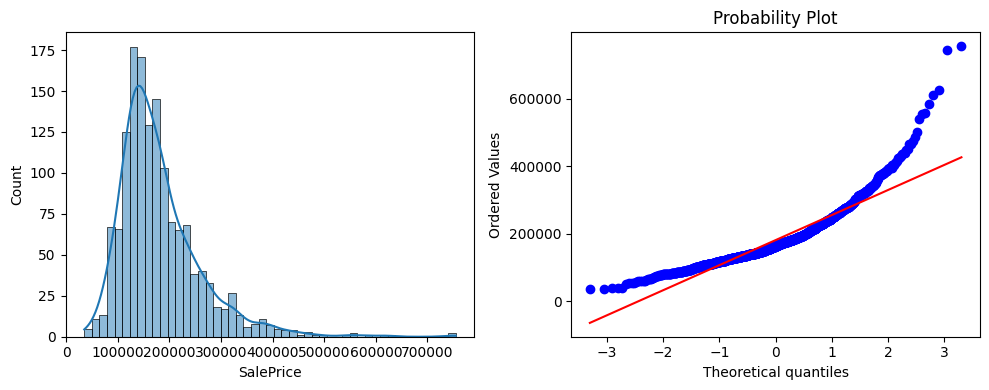

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.histplot(data=df, x='SalePrice', kde=True, ax=axes[0])
stats.probplot(df['SalePrice'], dist=stats.norm, plot=axes[1])

plt.tight_layout()

plt.show()

1. Analisando os gráficos acima, é possível observar que os valores de SalePrice não são normalmente distribuídos. Observa-se pelo gráfico à esquerda que há um alargamento da cauda para a direita, o que indica que existem imóveis sendo vendidos por um preço abaixo da média e que moda > mediana > média. O fato da curva ser "pontiaguda", pode ser um indicativo ve outliliers.

2. O gráfico QQ Plot faz a comparação da distribuição real (pontos em azul) com a distribuição teórica, que em nosso caso é a distribuição normal de probabilidade. Se os dados fossem normalmente distribuídos, a linha da distribuiçao teórica estaria ajustada a linha de distribuição teórica. 

In [139]:
stat, p_value = stats.shapiro(df.SalePrice)

print(f"Os dados não são normalmente distribuídos. p_value={p_value}")if p_value < 0.05  else print("Os dados estão normalmente distribuídos.")

Os dados não são normalmente distribuídos. p_value=3.2061412312021656e-33


In [140]:
print("Skewness: ", df.SalePrice.skew())
print("Kurtosis: ", df.SalePrice.kurt())

Skewness:  1.8828757597682129
Kurtosis:  6.536281860064529


Outra forma de avaliar a normalidade de uma distribuição é utilizando os valores de <b>Skewness</b> e <b>Kurtosis</b>.
 
1. <b>Skewness.</b> Mede a assimetria dos dados em torno da média. Em uma distribuição normal, o valor do skewness é 0. Se o seu valor variar em torno de 0.5, podemos admitir que os dados são normalmente distribuídos. Por óbvio, valores de skewness positivos indicam uma cauda alondaga à direita, e valores negativos uma cauda alondaga à esqueda. 

2. <b>Kurtosis.</b> Avalia o quão "pontiaguda" é a distribuição quando comparada com a Normal, que possui Kurtosis igual a 3. Valores positivos e maiores que 3 sugerem a presença de outliers.

In [141]:
df['SalePrice_log1p'] = np.log1p(df['SalePrice'])
adicionar_features_criadas('SalePrice_log1p')

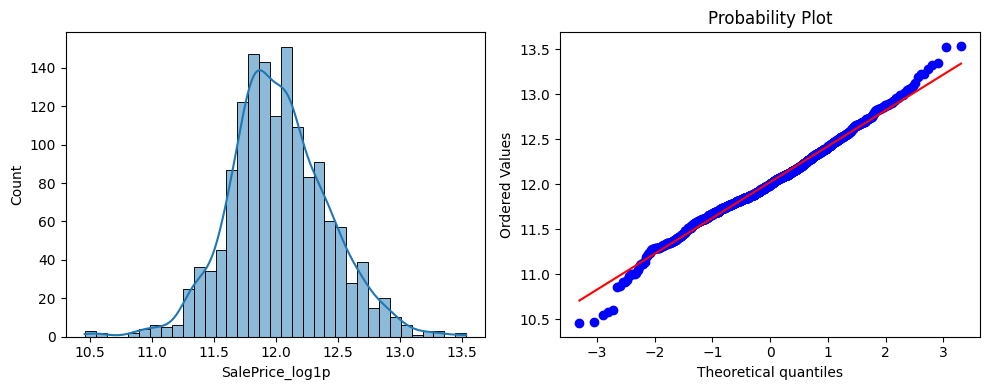

In [142]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.histplot(data=df, x='SalePrice_log1p', kde=True, ax=axes[0])
stats.probplot(df['SalePrice_log1p'], dist=stats.norm, plot=axes[1])
plt.tight_layout()
plt.show()

In [143]:
df[df.select_dtypes(include=['number']).columns].corr()[['SalePrice', 'SalePrice_log1p']].sort_values(by=['SalePrice_log1p'], ascending=False)[:20]

SalePrice  SalePrice_log1p
SalePrice_log1p     0.9484           1.0000
SalePrice           1.0000           0.9484
OverallQual         0.7910           0.8172
MasVnrArea          0.7107           0.7642
GrLivArea           0.7086           0.7009
GarageArea          0.6404           0.6806
GarageCars          0.6404           0.6806
ExterQual           0.6826           0.6788
KitchenQual         0.6596           0.6679
BsmtQual            0.5852           0.6158
TotalBsmtSF         0.6136           0.6121
GarageFinish        0.5492           0.6049
1stFlrSF            0.6059           0.5970
FullBath            0.5607           0.5948
YearBuilt           0.5229           0.5866
YearRemodAdd        0.5071           0.5656
FireplaceQu         0.5204           0.5464
TotRmsAbvGrd        0.5337           0.5344
Fireplaces          0.4669           0.4894
HeatingQC           0.4276           0.4738

##### GrLivArea

In [144]:
df['GrLivArea_log1p'] = np.log1p(df['GrLivArea'])

adicionar_caracteristicas_fortemente_correlacionadas('GrLivArea')
adicionar_features_criadas('GrLivArea_log1p')

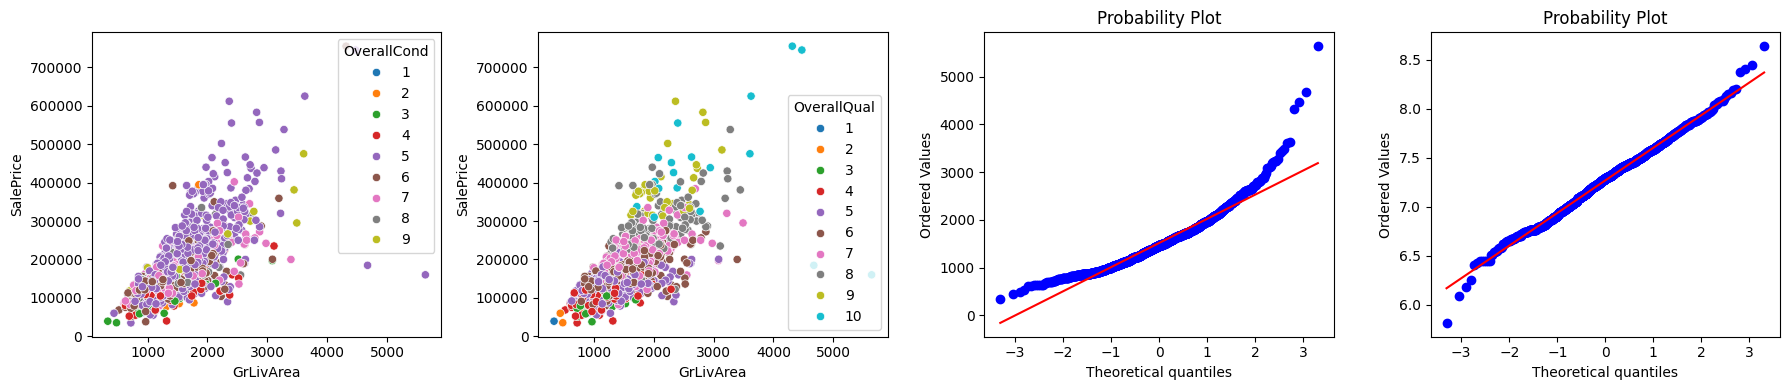

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice', hue='OverallCond', palette='tab10', ax=axes[0])
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice', hue='OverallQual', palette='tab10', ax=axes[1])
stats.probplot(df['GrLivArea'], dist=stats.norm, plot=axes[2])
stats.probplot(df['GrLivArea_log1p'], dist=stats.norm, plot=axes[3])
plt.tight_layout()
plt.show()

1. Ao analisar os gráficos acima, é possível enxergar uma tendência de incremento de preço à medida que a área aumenta. Entretanto, há grande variabilidade no preço a partir dos valores de 2500 metros quadrados. Ao que parece, OverallCond os imóveis de maneira mais homogênea, mas também possui alta variabilidade de preço. Também há uma grande quantidade de imóvies com OverallCond igual a 5.

2. Quando olhamos a distribuição do preço x área x OverallQual, há uma maior variabilidade de preços nos imóveis de maior qualidade.  

3. Há um fato curioso. Os dois imóveis localizados à direita dos gráficos possuem OverallQual igual a 5 e OverallQual igual a 10. Como também há dois imóveis na parte superior do gráfico que possuem OveallCond de 5 e 6, OverallQuall igual a 10.

4. Os dados não estão normalmente distribuídos.

Removendo os outliers

In [146]:
outliers = df[df.GrLivArea > 4000]
df = df.drop(index=outliers.index)
df.iloc[outliers.index]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street  LotShape  \
524    525          60       RL      95.0000    11787   Pave         3   
693    694          30       RL      60.0000     5400   Pave         4   
1185  1186          50       RL      60.0000     9738   Pave         4   
1302  1303          60       RL      92.0000    10120   Pave         4   

      LandContour  Utilities  LotConfig  LandSlope Neighborhood Condition1  \
524             4          4          1          3      NoRidge       Norm   
693             4          4          3          1      OldTown       Norm   
1185            4          4          1          3      Edwards       Norm   
1302            4          4          1          3      NoRidge       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
524        Norm     1Fam     2Story            7            5       1996   
693        Norm     1Fam     1Story            5            6       1921   
1185       Norm     1Fam     1.5Fin            5            7       1924   
1302       Norm     1Fam     2Story            8            5       1994   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  MasVnrType  \
524           1997     Gable  CompShg     VinylSd     VinylSd           1   
693           1968     Gable  CompShg     MetalSd     MetalSd           3   
1185          1950     Gable  CompShg     AsbShng     AsbShng           3   
1302          1994       Hip  CompShg     VinylSd     VinylSd           1   

      MasVnrArea  ExterQual  ExterCond Foundation  BsmtQual  BsmtCond  \
524       4.6701          4          3      PConc         4         3   
693       3.8073          3          3     BrkTil         3         3   
1185      3.8073          3          4     BrkTil         3         3   
1302      5.3591          4          3      PConc         4         3   

      BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
524              1          GLQ         719          Unf           0   
693              1          Unf           0          Unf           0   
1185             1          BLQ         392          Unf           0   
1302             1          GLQ         740          Unf           0   

      BsmtUnfSF  TotalBsmtSF Heating  HeatingQC  CentralAir  Electrical  \
524         660         1379    GasA          5           1           5   
693        1073         1073    GasA          5           1           5   
1185        392          784    GasA          4           1           5   
1302        425         1165    GasA          5           1           5   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
524       1383      1015             0       2398             1             0   
693       1073         0             0       1073             0             0   
1185       949       272             0       1221             1             0   
1302      1203      1323             0       2526             1             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  \
524          2         1             3             1            4   
693          1         0             2             1            3   
1185         1         0             4             1            3   
1302         2         1             4             1            4   

      TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu GarageType  \
524              8           8           1            3     Attchd   
693              4           8           0            0     Detchd   
1185             7           8           0            0     Attchd   
1302             8           8           1            3     Attchd   

      GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  \
524     1996.0000             3           3           3           3   
693     1968.0000             1           1           1           3   
1185    1965.0000             1           1           1     

O dicionário de dados informa que GrLivArea é a área total constuída "acima do solo". Pelo que entendi, GrLivArea é igual 1stFlrSF + 2ndFlrSF. Vamos checar isso.

In [147]:
temp = df.copy()
temp['soma_1s_2n'] = temp['1stFlrSF'] + temp['2ndFlrSF']
temp['diff_para_GrLivArea'] = temp['GrLivArea'] - temp['soma_1s_2n']
temp[['GrLivArea', 'soma_1s_2n', 'diff_para_GrLivArea', '1stFlrSF', '2ndFlrSF']].head(5)

GrLivArea  soma_1s_2n  diff_para_GrLivArea  1stFlrSF  2ndFlrSF
0       1710        1710                    0       856       854
1       1262        1262                    0      1262         0
2       1786        1786                    0       920       866
3       1717        1717                    0       961       756
4       2198        2198                    0      1145      1053

In [148]:
temp[temp.diff_para_GrLivArea > 0][['GrLivArea', 'soma_1s_2n', 'diff_para_GrLivArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']]

GrLivArea  soma_1s_2n  diff_para_GrLivArea  1stFlrSF  2ndFlrSF  \
51         1176         816                  360       816         0   
88         1526        1013                  513      1013         0   
125         754         520                  234       520         0   
170        1382         854                  528       854         0   
185        3608        3036                  572      1518      1518   
187        1656        1512                  144       808       704   
197        3112        2720                  392      1360      1360   
198        2229        1858                  371       929       929   
263        1316         926                  390       926         0   
267        2192        1772                  420      1052       720   
406        1639        1166                  473      1166         0   
589         935         779                  156       779         0   
635        3395        2880                  515      1440      1440   
729        1208         848                  360       848         0   
829        1223        1143                   80       520       623   
831        1200        1120                   80       520       600   
868        2320        2267                   53      1547       720   
873        1268        1036                  232      1036         0   
883        2230        1749                  481       954       795   
945        1869        1749                  120      1188       561   
1009       1522        1008                  514      1008         0   
1031       3082        2685                  397      1687       998   
1173       3086        2607                  479      1636       971   
1349       2358        2153                  205       938      1215   
1364       1200        1120                   80       520       600   
1440       2555        2171                  384      1423       748   

      LowQualFinSF  
51             360  
88             513  
125            234  
170            528  
185            572  
187            144  
197            392  
198            371  
263            390  
267            420  
406            473  
589            156  
635            515  
729            360  
829             80  
831             80  
868             53  
873            232  
883            481  
945            120  
1009           514  
1031           397  
1173           479  
1349           205  
1364            80  
1440           384

1. Existem 26 registros com aparente inconsistência. Após fazer testes, identifiquei que LowQualFinSF é a feature que faltava em nossa equação. Considerando que 1stFlrSF e 2ndFlrSF são equivalentes a GrLivArea, iremos removê-las para evitar problemas de multicolinearidade.

2. Iremos checar a correlação de LowQualFinSF com GrLivArea e SalePrice. Criaremos uma feature para será um índice de baixa qualidade para GrLivArea.

In [149]:
df.drop(columns=['1stFlrSF', '2ndFlrSF'], inplace=True)

In [150]:
df['perc_grlivarea_high_qual'] = (df.GrLivArea - df.LowQualFinSF / df.GrLivArea) * (df.OverallQual + df.OverallCond)

In [151]:
df['perc_low_qual_gr'] = (df.LowQualFinSF / (df.GrLivArea + df.LowQualFinSF)) * (df.OverallQual + df.OverallCond)

In [152]:
df.drop(columns=['LowQualFinSF'], inplace=True)

Agora, iremos avaliar as features criadas avaliando as pontuações de correlação e importância.

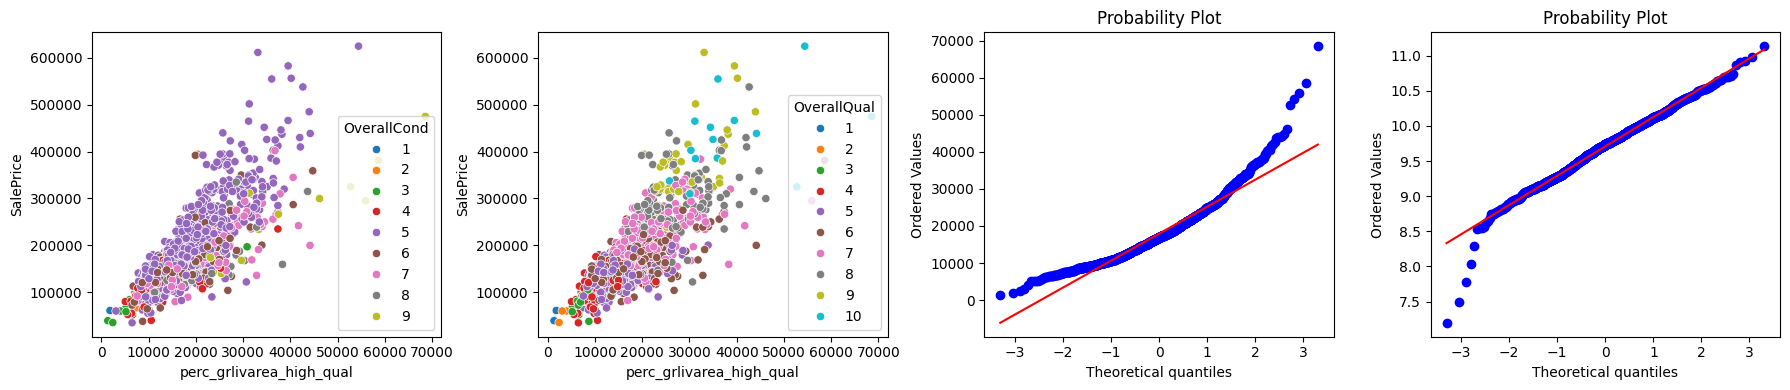

In [153]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
sns.scatterplot(data=df, x='perc_grlivarea_high_qual', y='SalePrice', hue='OverallCond', palette='tab10', ax=axes[0])
sns.scatterplot(data=df, x='perc_grlivarea_high_qual', y='SalePrice', hue='OverallQual', palette='tab10', ax=axes[1])
stats.probplot(df['perc_grlivarea_high_qual'], dist=stats.norm, plot=axes[2])
stats.probplot(np.log(df['perc_grlivarea_high_qual']), dist=stats.norm, plot=axes[3])
plt.tight_layout()
plt.show()

Aplicando a transformação logaritimica sobre a feature recém criada e avaliando a importância das features e seu desempenho em validação cruzada.

In [154]:
df['perc_grlivarea_high_qual_log1p'] = np.log1p(df['perc_grlivarea_high_qual'])
adicionar_caracteristicas_fortemente_correlacionadas('perc_grlivarea_high_qual')
adicionar_features_criadas('perc_grlivarea_high_qual_log1p')

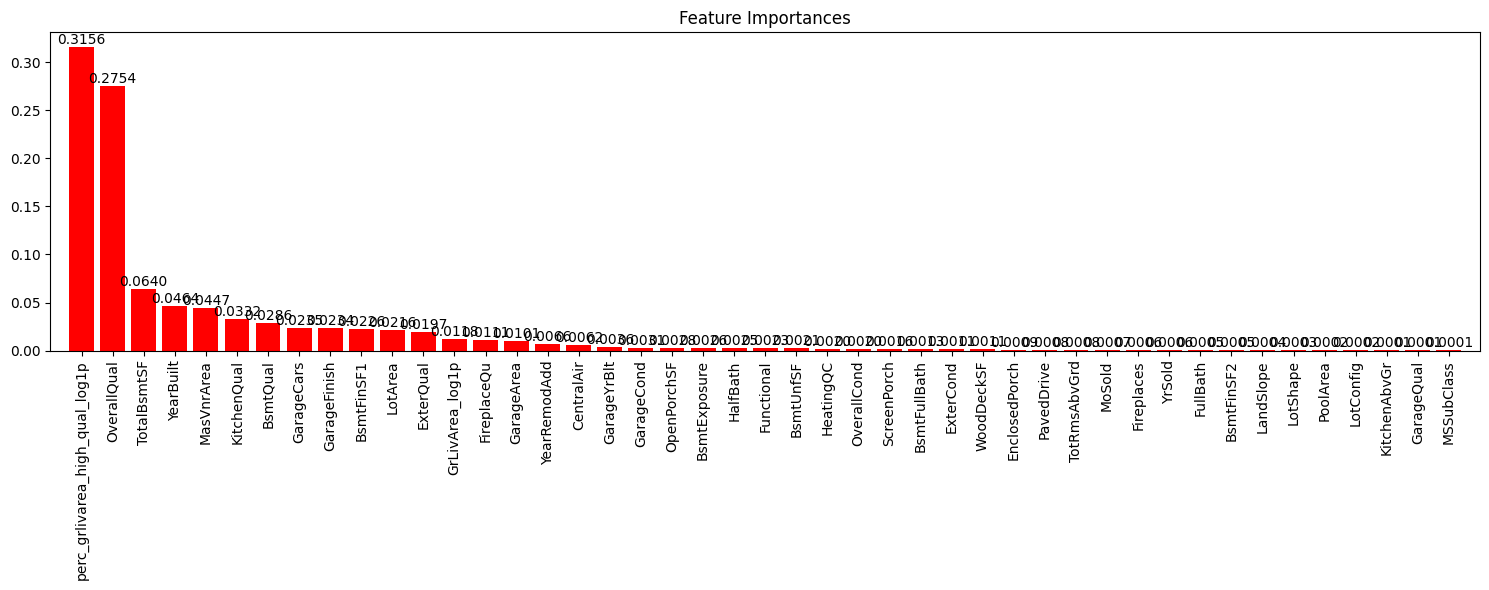

In [155]:
best_features = get_best_features_dataframe(df[df.select_dtypes(include=['number']).columns], df['SalePrice_log1p'], top=55, remover_colunas_altamente_correlacionadas=True)
set_feature_importance(df[df[best_features.index].columns], df['SalePrice_log1p'], num_features=45)

In [156]:
best_features

MIScore  Pearson  Spearman
OverallQual                      0.5610   0.8192    0.8103
MasVnrArea                       0.5608   0.7651    0.8092
perc_grlivarea_high_qual_log1p   0.6389   0.8126    0.8069
GrLivArea_log1p                  0.4751   0.7328    0.7312
GarageArea                       0.3746   0.6804    0.6897
GarageCars                       0.3739   0.6804    0.6897
ExterQual                        0.3316   0.6809    0.6841
BsmtQual                         0.3248   0.6152    0.6776
KitchenQual                      0.3326   0.6672    0.6724
YearBuilt                        0.3528   0.5890    0.6534
GarageYrBlt                      0.2612   0.3510    0.6349
GarageCond                       0.2588   0.3511    0.6349
FullBath                         0.2596   0.5909    0.6346
GarageFinish                     0.2726   0.6049    0.6335
TotalBsmtSF                      0.3581   0.6416    0.6020
YearRemodAdd                     0.2337   0.5690    0.5727
FireplaceQu                      0.2161   0.5466    0.5371
TotRmsAbvGrd                     0.2178   0.5334    0.5314
Fireplaces                       0.1679   0.4871    0.5180
HeatingQC                        0.1576   0.4742    0.4905
OpenPorchSF                      0.1547   0.3270    0.4775
LotArea                          0.1675   0.2589    0.4550
WoodDeckSF                       0.1104   0.3306    0.3519
GarageQual                       0.0704   0.3655    0.3513
BsmtExposure                     0.0784   0.3540    0.3430
HalfBath                         0.0872   0.3112    0.3411
CentralAir                       0.0704   0.3537    0.3134
BsmtFinSF1                       0.1472   0.3827    0.2993
Electrical                       0.0477   0.2835    0.2985
PavedDrive                       0.0504   0.3062    0.2805
BsmtCond                         0.0445   0.2766    0.2699
BedroomAbvGr                     0.0736   0.2041    0.2321
BsmtFullBath                     0.0356   0.2389    0.2256
BsmtUnfSF                        0.1267   0.2232    0.1846
Functional                       0.0070   0.1364    0.1351
LotConfig                        0.0110   0.1262    0.1021
ScreenPorch                      0.0160   0.1239    0.1011
MoSold                           0.0000   0.0622    0.0707
3SsnPorch                        0.0000   0.0561    0.0659
PoolArea                         0.0015   0.0407    0.0497
Utilities                        0.0049   0.0126    0.0167
ExterCond                        0.0183   0.0511    0.0124
MSSubClass                       0.2732  -0.0751    0.0057
BsmtHalfBath                     0.0112  -0.0150   -0.0167
LandContour                      0.0305  -0.0600   -0.0256
YrSold                           0.0069  -0.0343   -0.0284
BsmtFinSF2                       0.0129   0.0064   -0.0379
LandSlope                        0.0079  -0.0401   -0.0510
MiscVal                          0.0034  -0.0198   -0.0624
perc_low_qual_gr                 0.0027  -0.0576   -0.0681
OverallCond                      0.1188  -0.0368   -0.1296
KitchenAbvGr                     0.0313  -0.1479   -0.1646
EnclosedPorch                    0.0274  -0.1486   -0.2178
LotShape                         0.0825  -0.2859   -0.3194
MasVnrType                       0.0890  -0.3106   -0.3414

In [157]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1420 0.0126    0.8757
0          RandomForestRegressor 0.1431 0.0161    0.8703
4                  LGBMRegressor 0.1451 0.0154    0.8674
6  HistGradientBoostingRegressor 0.1465 0.0146    0.8702
7               BaggingRegressor 0.1475 0.0175    0.8656
1            ExtraTreesRegressor 0.1479 0.0163    0.8692
5                   XGBRegressor 0.1533 0.0181    0.8459
3              AdaBoostRegressor 0.1902 0.0235    0.8239

A variável perc_grlivarea_high_qual_log1p níveis altos de correlação e importância para a variável SalePrice. Iremos adicionar esse passo a passo em um método que será chamado pelo obter_dataframe_processado.

##### TotalBsmtSF

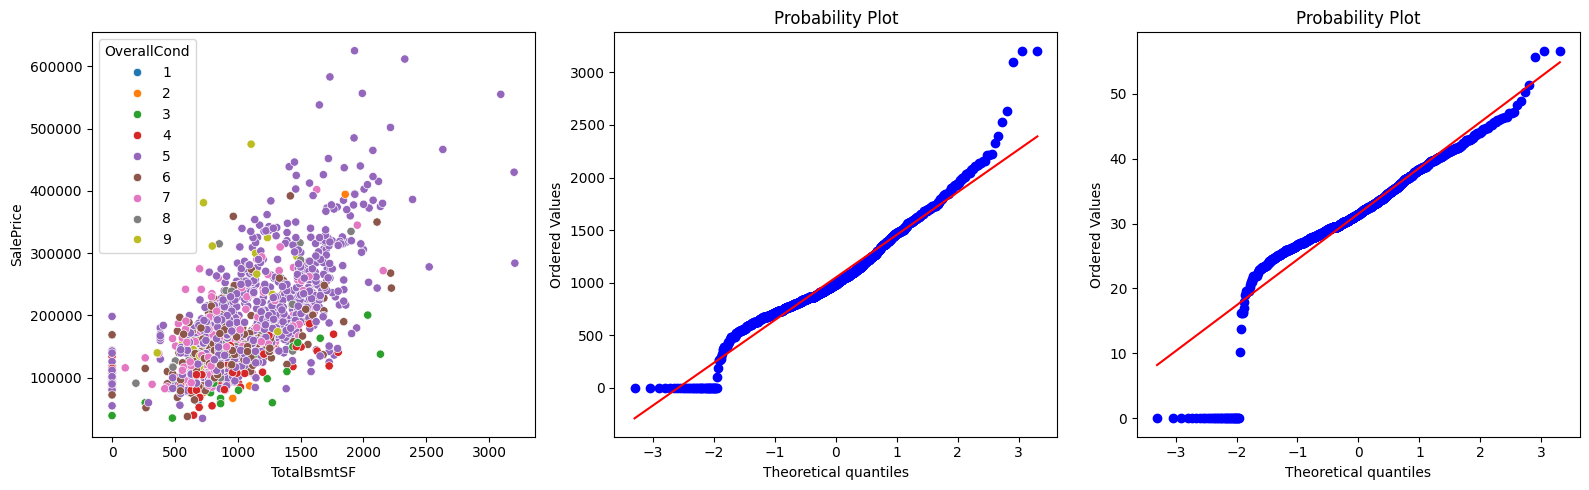

In [158]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
sns.scatterplot(data=df, x='TotalBsmtSF', y='SalePrice', hue='OverallCond', palette='tab10', ax=axes[0])
stats.probplot(df['TotalBsmtSF'], dist=stats.norm, plot=axes[1])
stats.probplot(np.sqrt(df['TotalBsmtSF']), dist=stats.norm, plot=axes[2])
plt.tight_layout()
plt.show()

1. Os gráficos acima nos mostram que a a distribuição dos dados do basement são bem peculiares. Isso porque há uma quantidade de imóveis que não possuem basement, o que é indicado em todos os gráficos. Apliquei uma transformação de raíz quadrada para tentar aproximar a curva da distribuição teórica e manter a os zeros (0) para indicar que não existe basement.

2. Uma transformação de raiz quadrada não pareceu promissora.

3. Há grande variabilidade de área e preço para OverallCond igual a 5. 

4. Iremos remover os outliers localizados à direita do gráfico, valores de TotalBsmtSF > 3000.

In [159]:
outliers = df[df['TotalBsmtSF'] > 3000]
outliers

Id  MSSubClass MSZoning  LotFrontage  LotArea Street  LotShape  \
332  333          20       RL      85.0000    10655   Pave         3   
440  441          20       RL     105.0000    15431   Pave         4   
496  497          20       RL      95.8095    12692   Pave         3   

     LandContour  Utilities  LotConfig  LandSlope Neighborhood Condition1  \
332            4          4          1          3      NridgHt       Norm   
440            4          4          1          3      NridgHt       Norm   
496            4          4          1          3      NoRidge       Norm   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
332       Norm     1Fam     1Story            8            5       2003   
440       Norm     1Fam     1Story           10            5       2008   
496       Norm     1Fam     1Story            8            5       1992   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  MasVnrType  \
332          2004     Gable  CompShg     VinylSd     VinylSd           1   
440          2008       Hip  CompShg     VinylSd     VinylSd           2   
496          1993       Hip  CompShg     BrkFace     BrkFace           3   

     MasVnrArea  ExterQual  ExterCond Foundation  BsmtQual  BsmtCond  \
332      5.3591          4          3      PConc         4         3   
440      6.2920          5          3      PConc         5         3   
496      5.3591          4          3      PConc         4         3   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
332             1          GLQ        1124          Unf         479   
440             4          GLQ        1767          ALQ         539   
496             1          GLQ        1231          Unf           0   

     BsmtUnfSF  TotalBsmtSF Heating  HeatingQC  CentralAir  Electrical  \
332       1603         3206    GasA          5           1           5   
440        788         3094    GasA          5           1           5   
496       1969         3200    GasA          5           1           5   

     GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
332       1629             1             0         2         0             3   
440       2402             1             0         2         0             2   
496       3228             1             0         3         0             4   

     KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  \
332             1            4             7           8           1   
440             1            5            10           8           2   
496             1            4            10           8           1   

     FireplaceQu GarageType  GarageYrBlt  GarageFinish  GarageCars  \
332            4     Attchd    2003.0000             2           3   
440            4     Attchd    2008.0000             3           3   
496            4     Attchd    1992.0000             2           2   

     GarageArea  GarageQual  GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  \
332           3           3        2003           3           0            0   
440           3           3        2008           3           0           72   
496           2           3        1992           3         264           75   

     EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
332              0          0            0         0        0      10    2009   
440              0          0          170         0        0       4    2009   
496            291          0            0         0        0       5    2007   

    SaleType SaleCondition  SalePrice  SalePrice_log1p  GrLivArea_log1p  \
332       WD        Normal     284000          12.5567           7.3963   
440       WD        Normal     555000          13.2267           7.7845   
496       WD        Normal     430000          12.9715           8.0799   

     perc_grlivarea_high_qual  perc_low_qual_gr  \
332                21177.0000            0

In [160]:
df.drop(index=outliers.index, inplace=True)

Agora, vamos dar uma olhada nos atributos de área relacionados a TotalBsmtSF, seguindo a mesma abordagem de GrLivArea.

In [161]:
temp = df.copy()
temp[['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2']]= temp[['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2']].fillna(0)

temp['soma_SF1_SF2'] = temp['BsmtFinSF1'] + temp['BsmtFinSF2']
temp['diff'] = temp['TotalBsmtSF'] - temp['soma_SF1_SF2']

temp[['BsmtFinSF1', 'BsmtFinSF2', 'soma_SF1_SF2', 'TotalBsmtSF', 'diff', 'BsmtUnfSF']].head(5)

BsmtFinSF1  BsmtFinSF2  soma_SF1_SF2  TotalBsmtSF  diff  BsmtUnfSF
0         706           0           706          856   150        150
1         978           0           978         1262   284        284
2         486           0           486          920   434        434
3         216           0           216          756   540        540
4         655           0           655         1145   490        490

In [162]:
temp[temp['diff'] != temp['BsmtUnfSF']]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, SalePrice_log1p, GrLivArea_log1p, perc_grlivarea_high_qual, perc_low_qual_gr, perc_grlivarea_high_qual_log1p, soma_SF1_SF2, diff]
Index: []

A exemplo do que ocorreu com GrLivArea, iremos criar novas features. Mas antes, vamos dar uma olhada no heatmap das features relaionadas aos basements e obter alguns insigths de novas features.

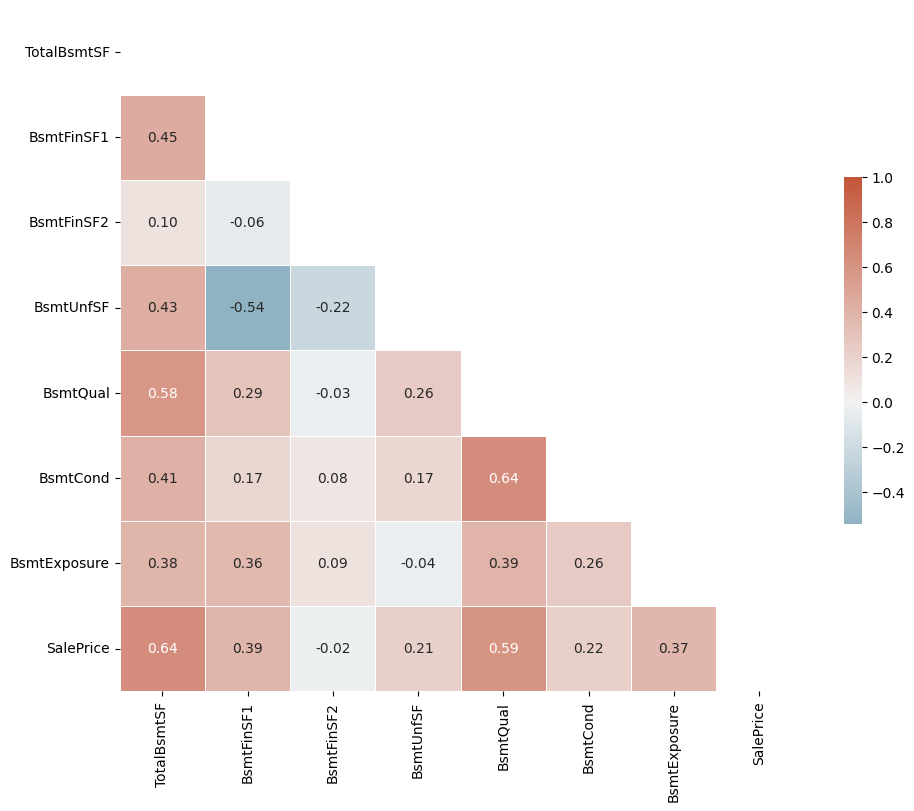

In [163]:
corr = df[['TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtQual', 'BsmtCond', 'BsmtExposure',  'SalePrice']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            annot=True, 
            fmt=".2f")
plt.show()

1. Há correlação moderada entre BsmtQual (altura) e BsmtCond (estado de conservação). Iremos testar a combinação de ambas para e analisar os resultados.
2. Há uma correlação quaser forte entre BsmtFinSF2 e BsmtFinType1 e 2. Iremos avaliar a remoção de uma ou ambas.
3. Ao analisar as descrições das features BsmtFinType1 e BsmtFinType2, percebi que elas parecem ser complementares. Além disso, esssas features parecem avaliar aspectos diferentes de um basement. No início de do projeto, optei por codificá-las em uma variável categórica com gradação de qualidade. Porém, após essa análise mais aprofundada, acredito que One Hot Encoding seja a melhor forma de codificá-las.

In [164]:
def calc_perc_bsmt_finish(row: pd.Series):
    finished = row.TotalBsmtSF - row.BsmtUnfSF
    perc = np.nan_to_num(finished/row.TotalBsmtSF) * np.exp2((row.BsmtQual  + row.BsmtCond))
    return perc 

In [165]:
df['perc_bsmt_finish'] = df[['TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtQual', 'BsmtCond', 'BsmtExposure']].apply(calc_perc_bsmt_finish, axis=1)
adicionar_features_criadas('perc_bsmt_finish')

df['total_area'] = np.log1p(df['GrLivArea'] + df['TotalBsmtSF'])
adicionar_features_criadas('total_area')

adicionar_caracteristicas_fortemente_correlacionadas('BsmtFinSF1')
adicionar_caracteristicas_fortemente_correlacionadas('BsmtFinSF2')

# adicionar_caracteristicas_fortemente_correlacionadas('BsmtCond')
# adicionar_caracteristicas_fortemente_correlacionadas('BsmtQual')

adicionar_features_criadas('total_area')
adicionar_features_criadas('perc_bsmt_finish')

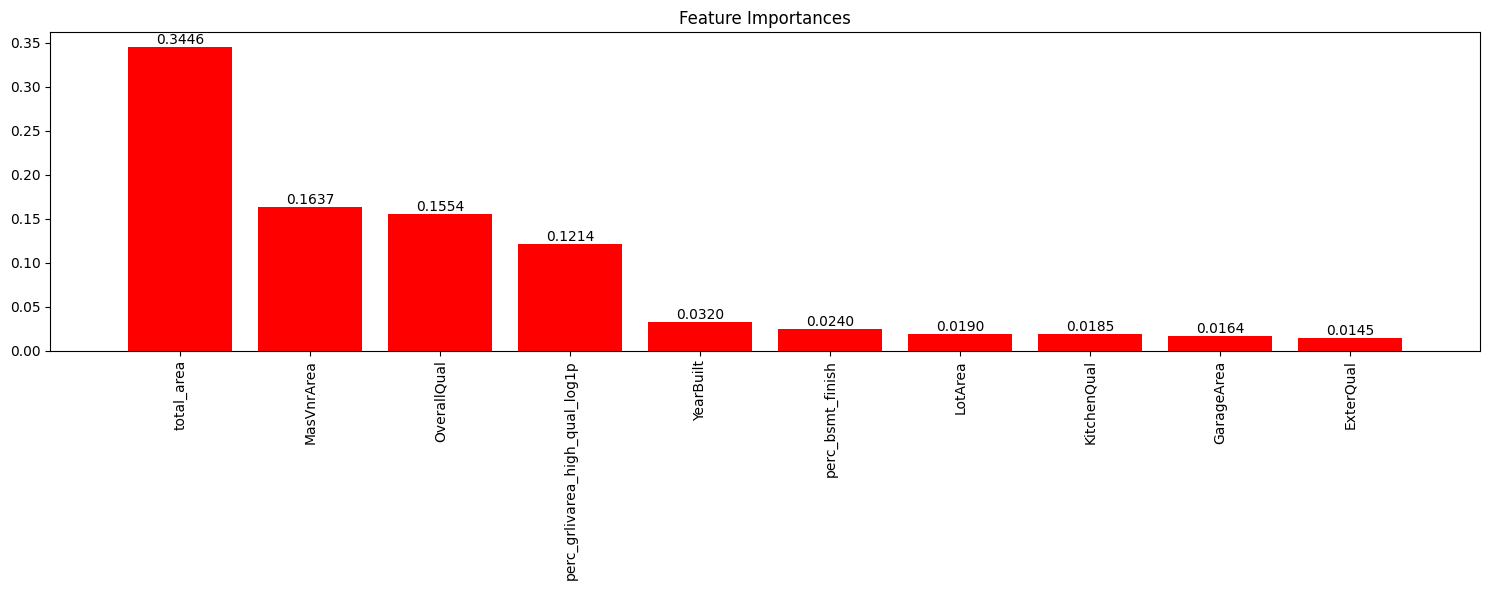

MIScore  Pearson  Spearman
total_area                       0.6602   0.7681    0.8144
OverallQual                      0.5635   0.8002    0.8092
MasVnrArea                       0.5592   0.7182    0.8081
perc_grlivarea_high_qual_log1p   0.6130   0.7624    0.8061
GrLivArea_log1p                  0.4886   0.6996    0.7303
GarageArea                       0.3650   0.6509    0.6888
GarageCars                       0.3618   0.6509    0.6888
ExterQual                        0.3306   0.6929    0.6825
BsmtQual                         0.3245   0.5926    0.6766
KitchenQual                      0.3299   0.6660    0.6712

In [166]:
best_features = get_best_features_dataframe(df[df.select_dtypes(include=['number']).columns], df['SalePrice'], remover_colunas_altamente_correlacionadas=True)
set_feature_importance(df[df[best_features.index].columns], df['SalePrice'], num_features=10)
best_features.sort_values(by='Spearman', ascending=False).head(10)

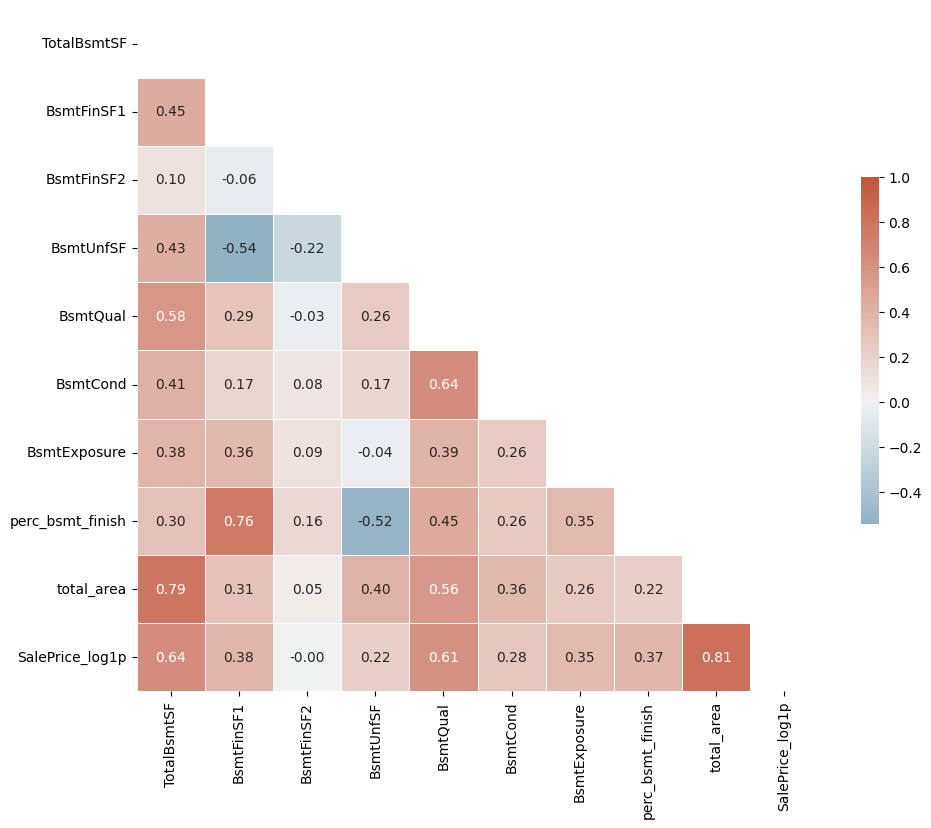

In [167]:
plot_heatmap(df[['TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtQual', 'BsmtCond', 
                'BsmtExposure', 'perc_bsmt_finish', 'total_area', 'SalePrice_log1p']].corr()
)

In [168]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1279 0.0136    0.9049
6  HistGradientBoostingRegressor 0.1322 0.0138    0.8957
0          RandomForestRegressor 0.1327 0.0141    0.8925
4                  LGBMRegressor 0.1329 0.0132    0.8974
7               BaggingRegressor 0.1356 0.0139    0.8862
1            ExtraTreesRegressor 0.1358 0.0132    0.8894
5                   XGBRegressor 0.1389 0.0114    0.8755
3              AdaBoostRegressor 0.1778 0.0213    0.8424

##### Qualidade

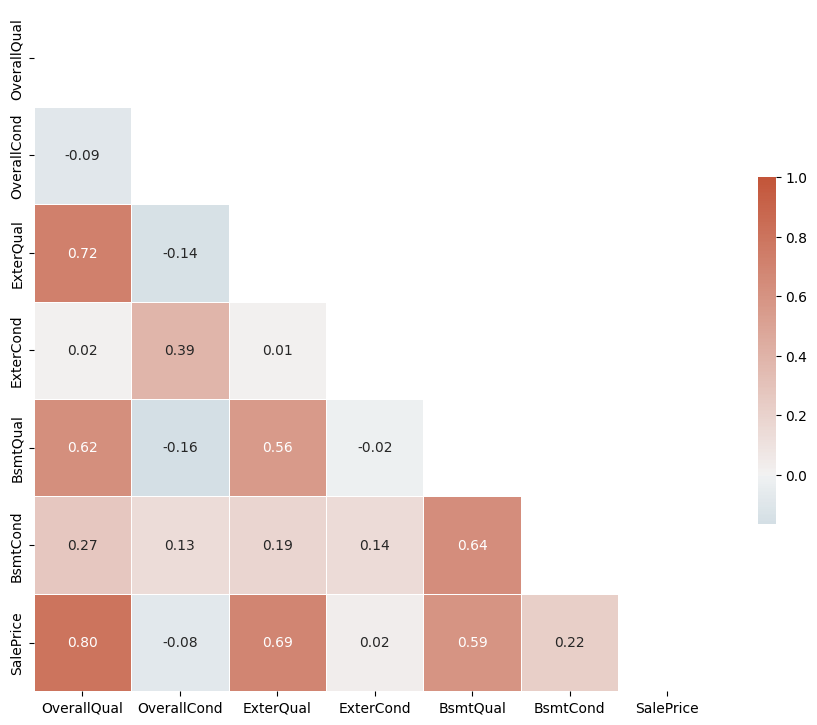

In [169]:
plot_heatmap(df[['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'SalePrice']].corr())

1. Dando uma olhada no heatmap de todos os atributos relacionados à qualidade e condições, podemos perceber que OverallQual e ExterQual possuem entre si uma correlação moderada e com SalePrice. 
2. O mesmop fato se aplica a BsmtQual e BsmtCond, que possuem correlação moderada entre si e com SalePrice. 
3. OverallQual e OverallCond não possuem correlação levemente negativa. 

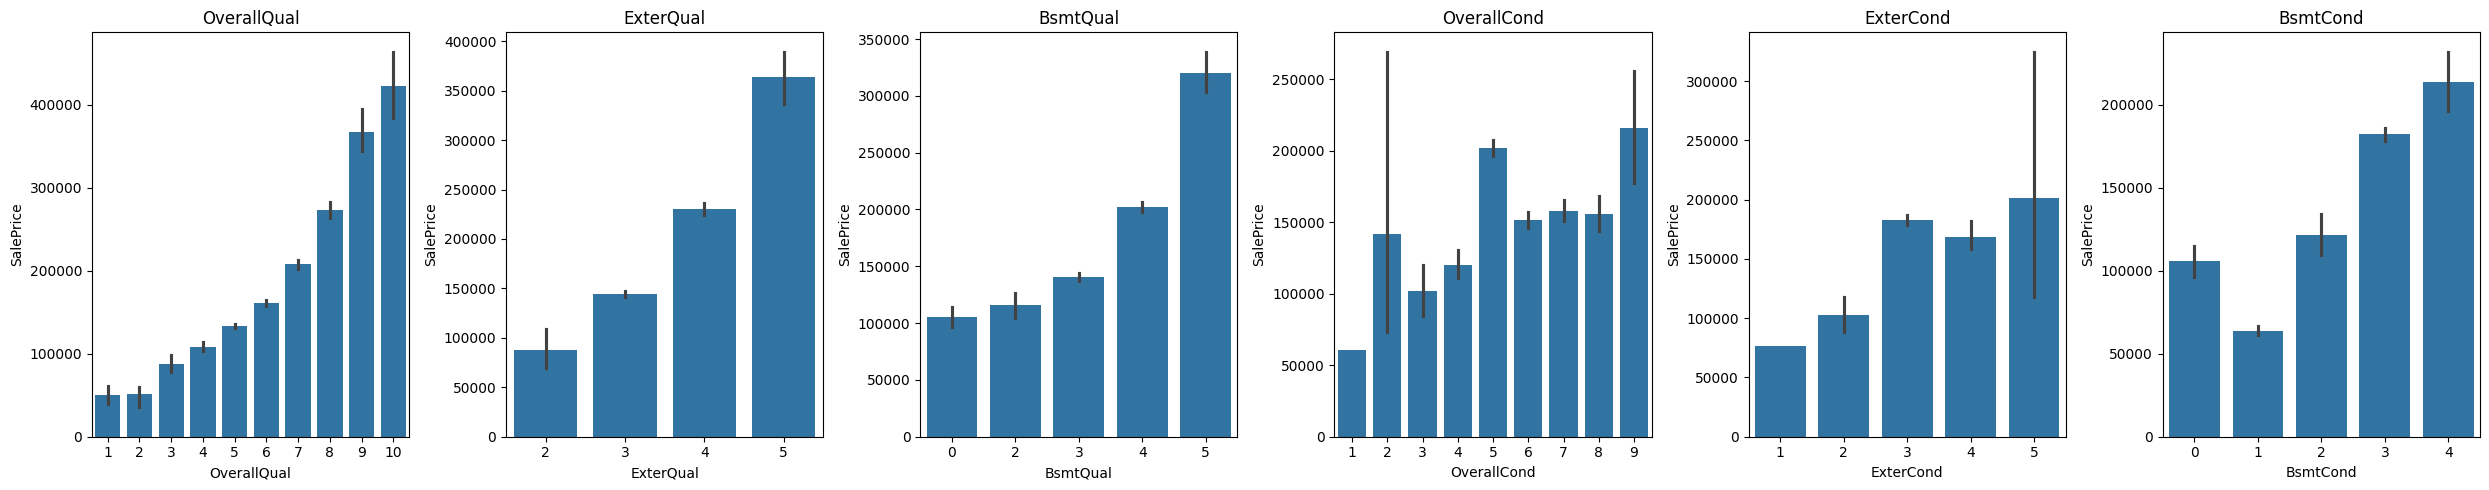

In [170]:
features = ['OverallQual', 'ExterQual', 'BsmtQual', 'OverallCond', 'ExterCond', 'BsmtCond']
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(25, 5))

for index, feature in enumerate(features):
    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[index]) 
    axes[index].set_title(feature) 

plt.tight_layout()
plt.show()


A partir da análise dos gráficos acima, podemos perceber que:
1. claramente que há uma tendência de aumento de preço à medida que a qualidade aumenta ('OverallQual', 'OverallCond', 'ExterQual')
2. Embora as condições do imóvel influenciem o preço, não há uma relação clara de que melhores condições conduzam à preços maiores. 

Iremos fazer alguns ajustes nas categorias para ver se sua correlação e importância melhoram.

In [171]:
df['OverallQual'] = df['OverallQual'].replace({1: 2, 10: 9})
df['BsmtQual'] = df['BsmtQual'].replace({0: 2})
df['BsmtCond'] = df['BsmtCond'].replace({0: 1})
df['OverallCond'] = df['OverallCond'].replace({9: 7, 8: 7, 6: 7, 5: 7, 4: 7, 3: 7})
df['ExterCond'] = df['ExterCond'].replace({5: 4, 3: 4})

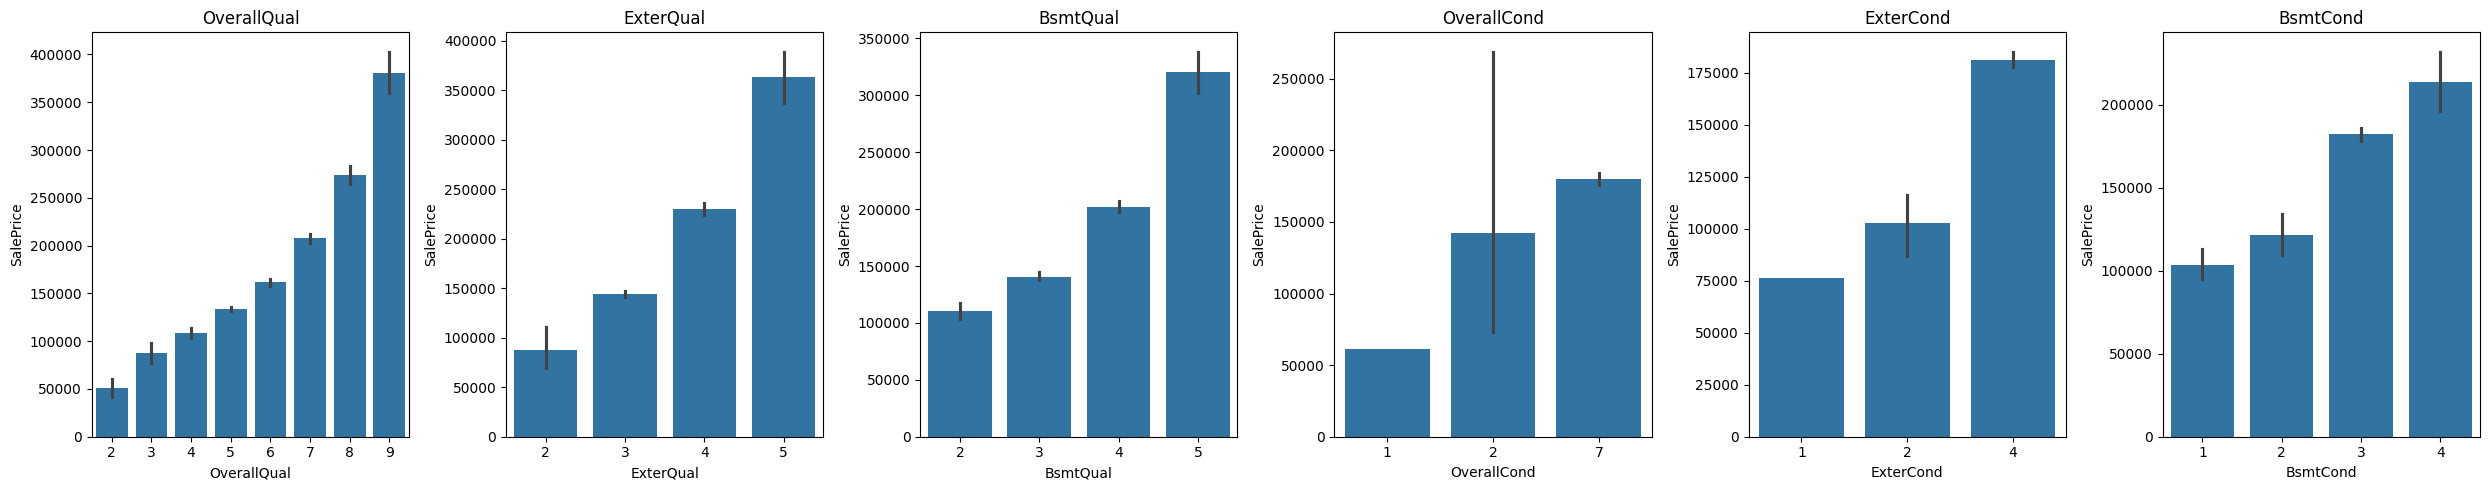

In [172]:
features = ['OverallQual', 'ExterQual', 'BsmtQual', 'OverallCond', 'ExterCond', 'BsmtCond']
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(25, 5))

for index, feature in enumerate(features):
    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[index]) 
    axes[index].set_title(feature) 

plt.tight_layout()
plt.show()

In [173]:
df['index_qual_global'] = df.OverallQual + df.ExterQual + df.BsmtQual
df['index_cond_global'] = df.OverallCond + df.ExterCond + df.BsmtCond

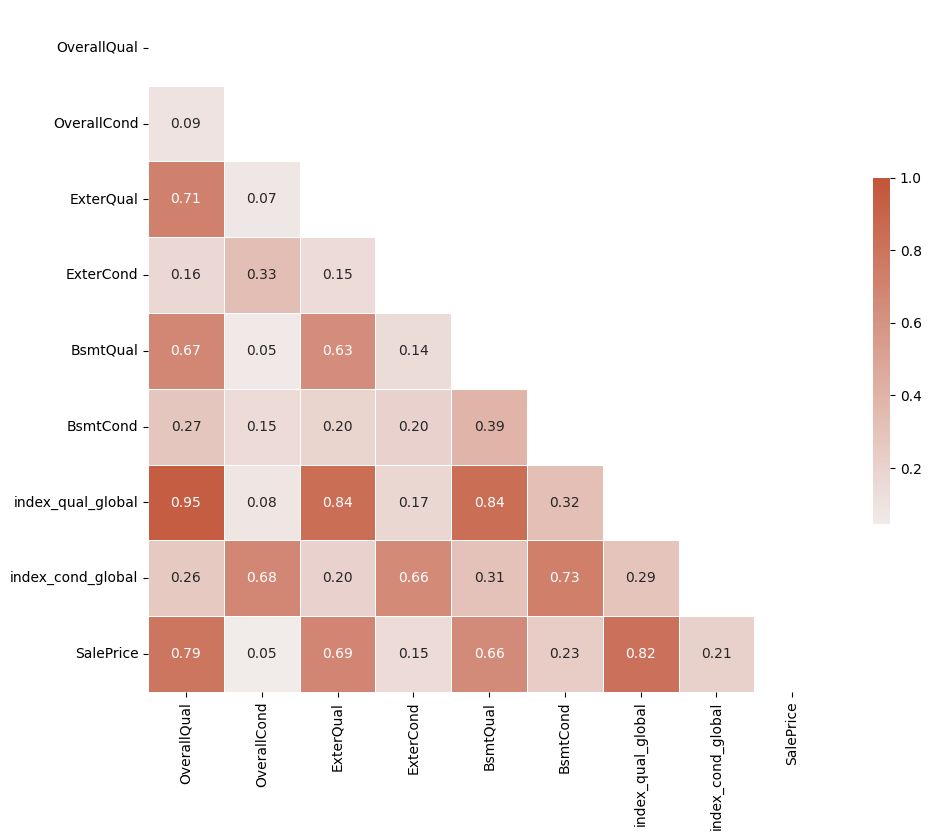

In [174]:
plot_heatmap(df[['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'index_qual_global', 'index_cond_global', 'SalePrice']].corr())

In [175]:
adicionar_features_criadas('index_qual_global')
adicionar_caracteristicas_fortemente_correlacionadas('OverallQual')
adicionar_caracteristicas_fortemente_correlacionadas('ExterQual')
adicionar_caracteristicas_fortemente_correlacionadas('BsmtQual')

adicionar_caracteristicas_fortemente_correlacionadas('OverallCond')
adicionar_caracteristicas_fortemente_correlacionadas('ExterCond')
adicionar_caracteristicas_fortemente_correlacionadas('BsmtCond')

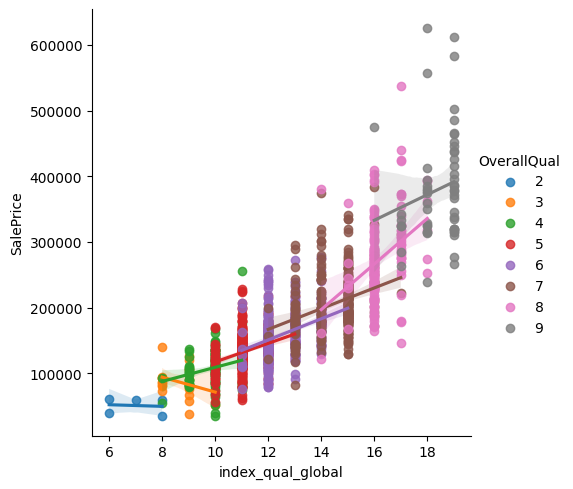

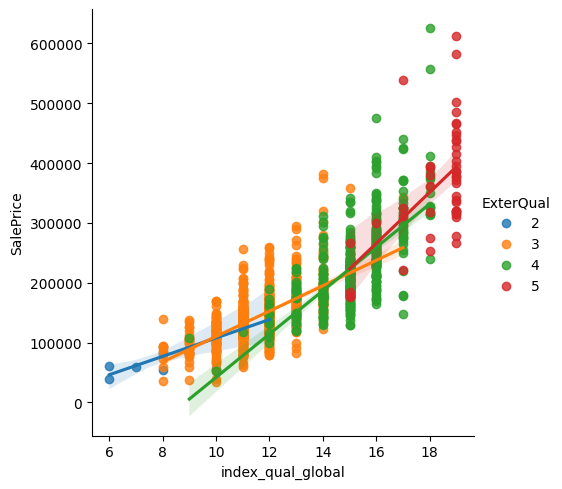

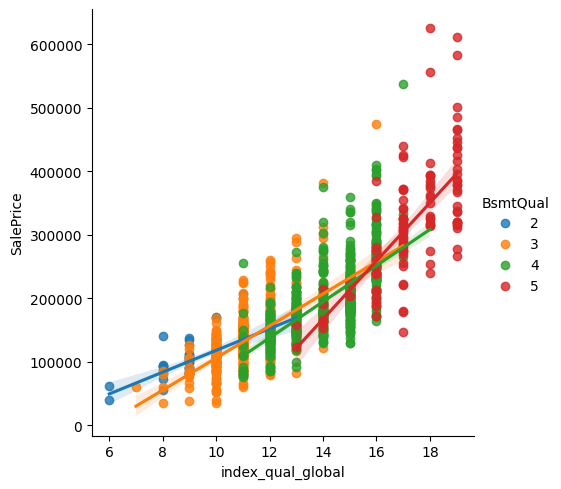

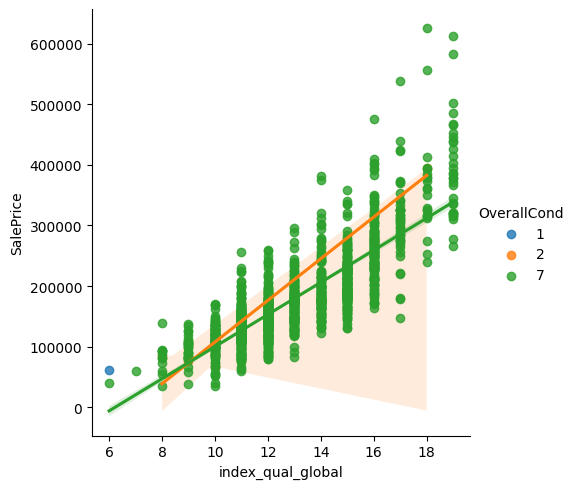

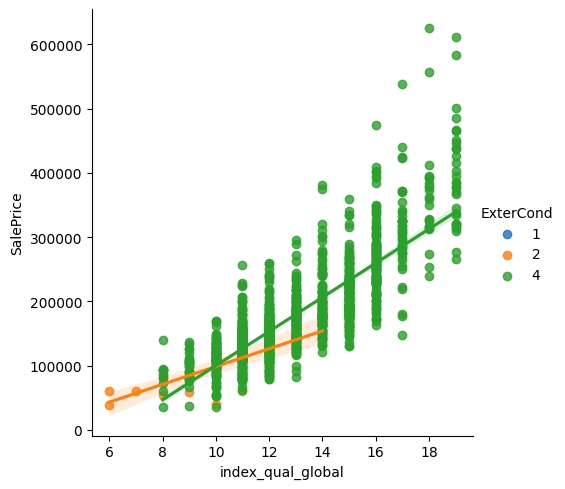

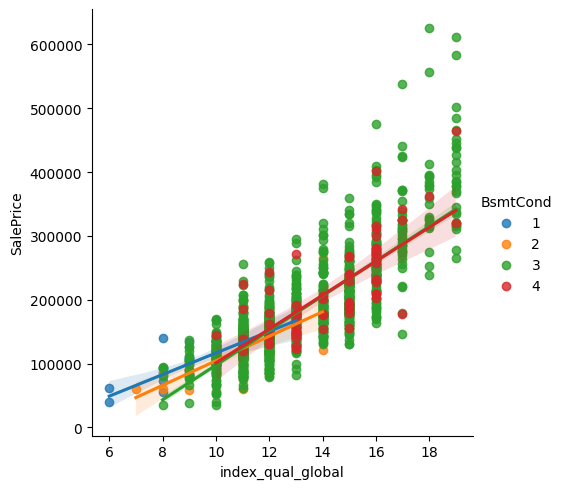

In [176]:
for feature in features:
    sns.lmplot(data=df, x='index_qual_global', y='SalePrice', hue=feature)

Após realizarmos alguns ajustes nas features categóricas de qualidade, os preços tendem a aumentar com o incremento da qualidade ou condição. O indicador de qualidade apresenta uma reta de regressão bem ajustada aos indicadores de qualidade. Agora vamos dar uma olhada nos números dessa nova feature.

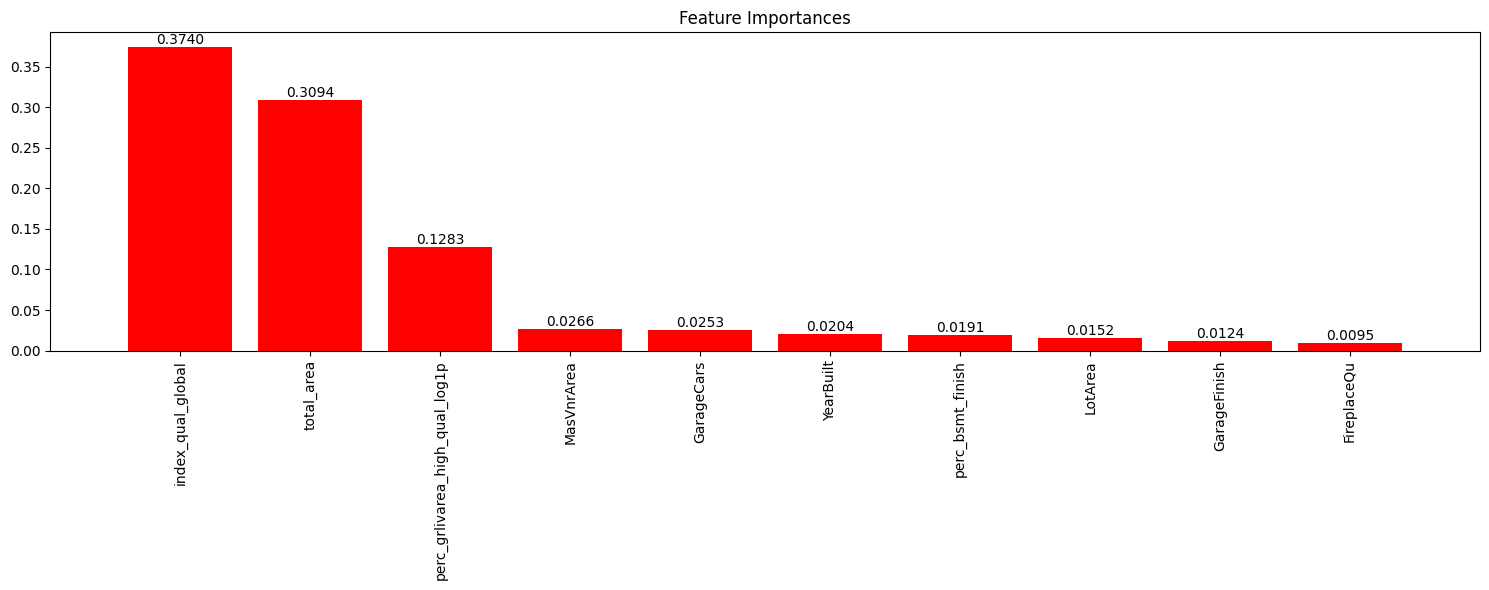

                                MIScore  Pearson  Spearman
index_qual_global                0.6259   0.8197    0.8313
total_area                       0.6617   0.7681    0.8144
MasVnrArea                       0.5606   0.7182    0.8081
perc_grlivarea_high_qual_log1p   0.6115   0.7624    0.8061
GrLivArea_log1p                  0.4876   0.6996    0.7303
GarageArea                       0.3709   0.6509    0.6888
GarageCars                       0.3634   0.6509    0.6888
KitchenQual                      0.3351   0.6660    0.6712
YearBuilt                        0.3690   0.5360    0.6524
GarageYrBlt                      0.2613   0.2698    0.6340


In [177]:
plot_stats_features(df=df, num_features=10, remover_colunas_altamente_correlacionadas=True)

In [178]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1269 0.0129    0.9054
6  HistGradientBoostingRegressor 0.1300 0.0125    0.8974
0          RandomForestRegressor 0.1305 0.0152    0.8991
1            ExtraTreesRegressor 0.1311 0.0142    0.8954
4                  LGBMRegressor 0.1315 0.0134    0.9008
7               BaggingRegressor 0.1338 0.0149    0.8947
5                   XGBRegressor 0.1365 0.0100    0.8862
3              AdaBoostRegressor 0.1793 0.0221    0.8486

##### YearBuilt, YrSold, YearRemodAdd

<Axes: xlabel='YrSold', ylabel='count'>

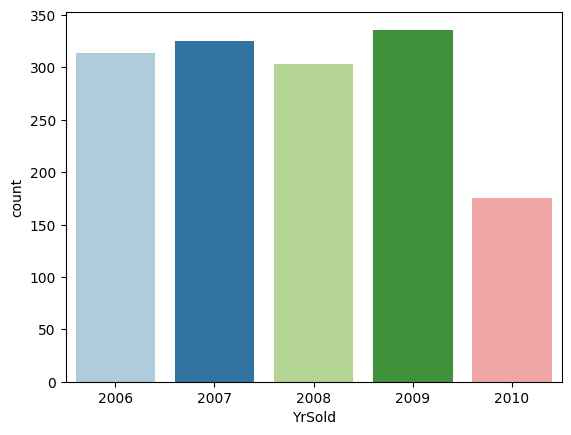

In [179]:
sns.barplot(df.YrSold.value_counts(), palette=palete)

<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

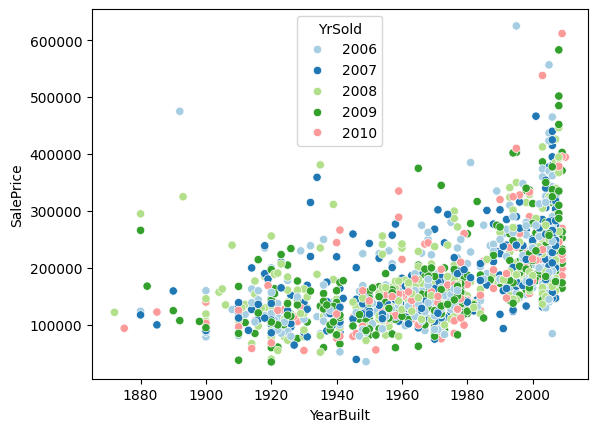

In [180]:
sns.scatterplot(data=df, x='YearBuilt', y='SalePrice', hue='YrSold', palette=palete)

<Axes: xlabel='YrSold', ylabel='SalePrice'>

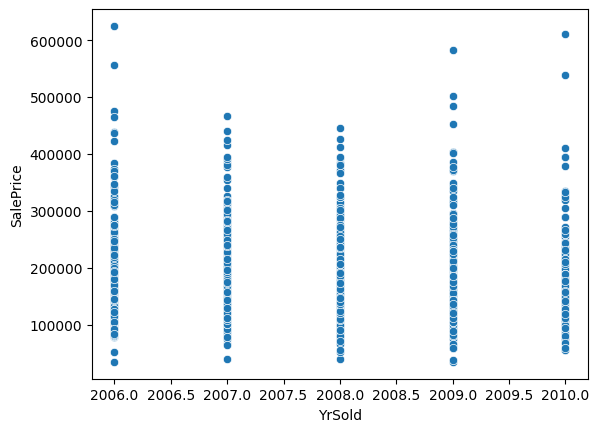

In [181]:
sns.scatterplot(data=df, x='YrSold', y='SalePrice', palette=palete)

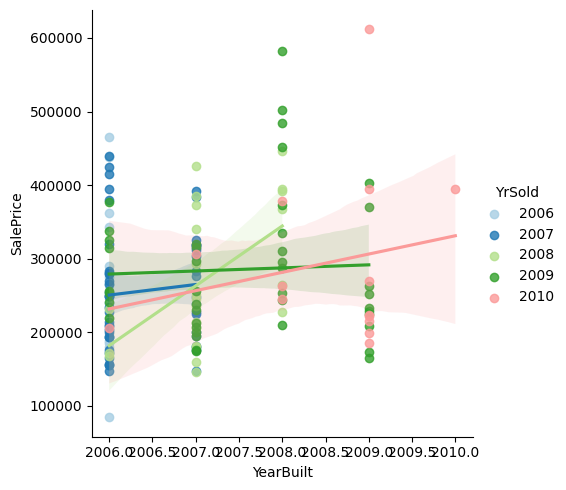

In [182]:
sns.lmplot(data=df[ (df['YearBuilt'] >= 2006) ], x='YearBuilt', y='SalePrice', hue='YrSold', palette=palete)

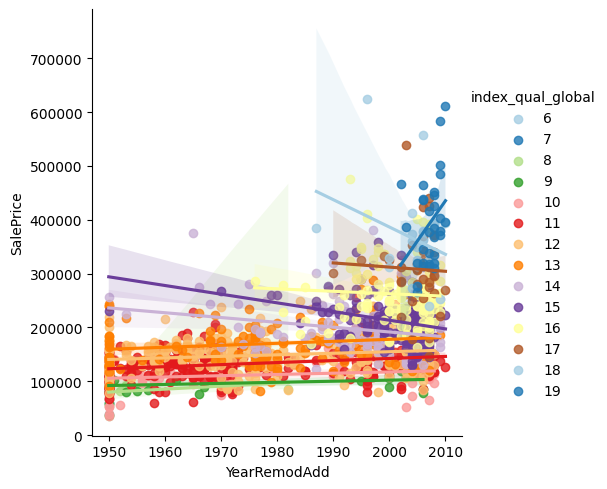

In [183]:
sns.lmplot(data=df, x='YearRemodAdd', y='SalePrice', palette=palete, hue='index_qual_global')

1. Nâo parece haver uma tendência bem delineada entre YearBuilt e YrSold e YearRemodAdd, até mesmo filtrando os imóveis mais novos. Com muita "boa vontade", conseguimos visualizar uma reta ou curva exponencial suave no gráfico YearBuilt X SalePrice. 

2. Tentaremos melhorar a interpretabilidade dessas features criando atributos categóricos utilizando clusters e o método o "gráfico de cotovelo" para selecionar a melhor quantidade de clusters.

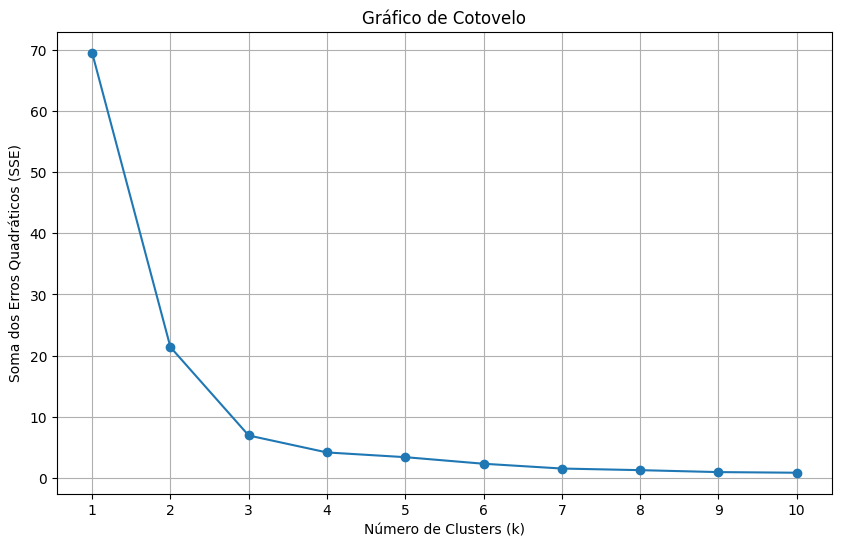

In [184]:
plot_elbow(data=df[['YearBuilt']], max_clusters=10)

In [185]:
temp_cluster01 = df.copy()

temp_cluster01['cluster_year_built'] = KMeans(n_clusters=2, max_iter=10000, n_init=1000).fit_predict(temp_cluster01[['YearBuilt']])

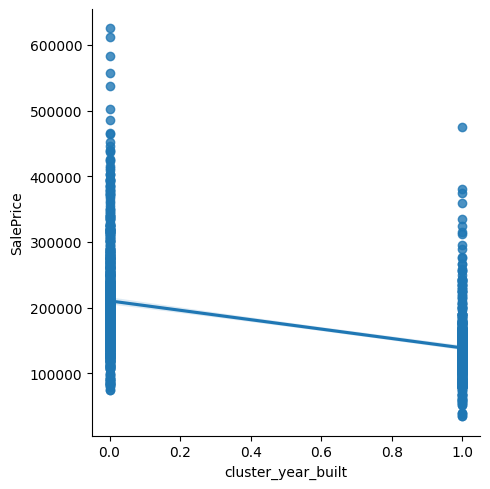

In [186]:
sns.lmplot(temp_cluster01, x='cluster_year_built', y='SalePrice')

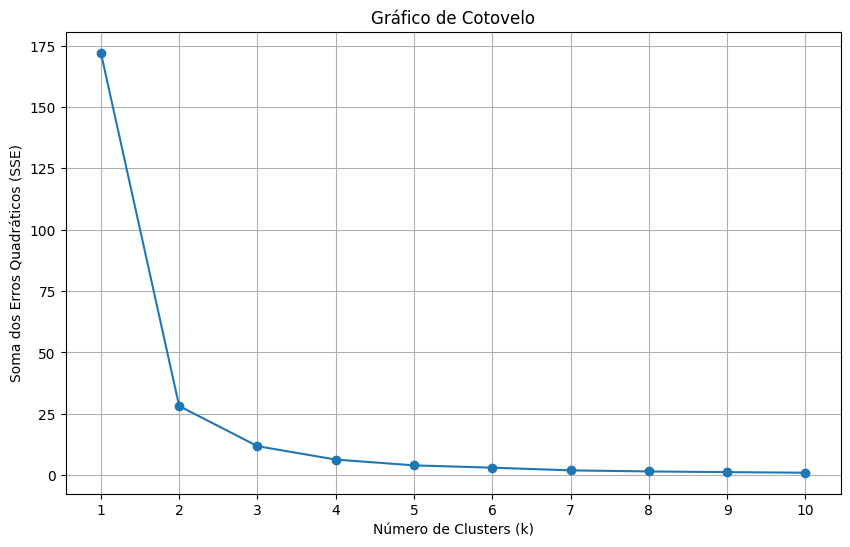

In [187]:
plot_elbow(data=df[['YearRemodAdd']], max_clusters=10)

In [188]:
temp_cluster01['cluster_year_remod'] = KMeans(n_clusters=2, max_iter=10000, n_init=1000).fit_predict(temp_cluster01[['YearBuilt']])

In [189]:
get_best_features_dataframe(X=temp_cluster01[['cluster_year_remod', 'YearRemodAdd', 'cluster_year_built', 'YearBuilt']], y=df['SalePrice'])

MIScore  Pearson  Spearman
YearBuilt            0.3649   0.5360    0.6524
YearRemodAdd         0.2437   0.5229    0.5722
cluster_year_built   0.1745  -0.4675   -0.5468
cluster_year_remod   0.1743  -0.4675   -0.5468

1. O uso de clusters não melhorou a pontuação das variáveis YearBuilt e YearRemodAdd. Por essa razão, não serão utilizadas.
2. Criaremos atributos para a idade do imóvel e idade da reforma.

In [190]:
df['age_house'] = df[['YrSold', 'YearBuilt']].apply(lambda x: x[0] - x[1] if x[0] != x[1] else 0.1, axis=1)
df['age_remode'] = df[['YrSold', 'YearRemodAdd', 'age_house']].apply(lambda x: x[0] - x[1] if (x[0] != x[1] and x[1] > 0) else x[2], axis=1)

get_best_features_dataframe(X=df[['age_house', 'YearRemodAdd', 'age_remode', 'YearBuilt']], y=df['SalePrice'])

MIScore  Pearson  Spearman
YearBuilt      0.3649   0.5360    0.6524
YearRemodAdd   0.2437   0.5229    0.5722
age_remode     0.2628  -0.5282   -0.5857
age_house      0.3397  -0.5362   -0.6500

As features de idade tem pontuações equivalentes às features relacionadas com correlações negativas, o que dá a entender que o quanto maior for a idade, menor o preço.

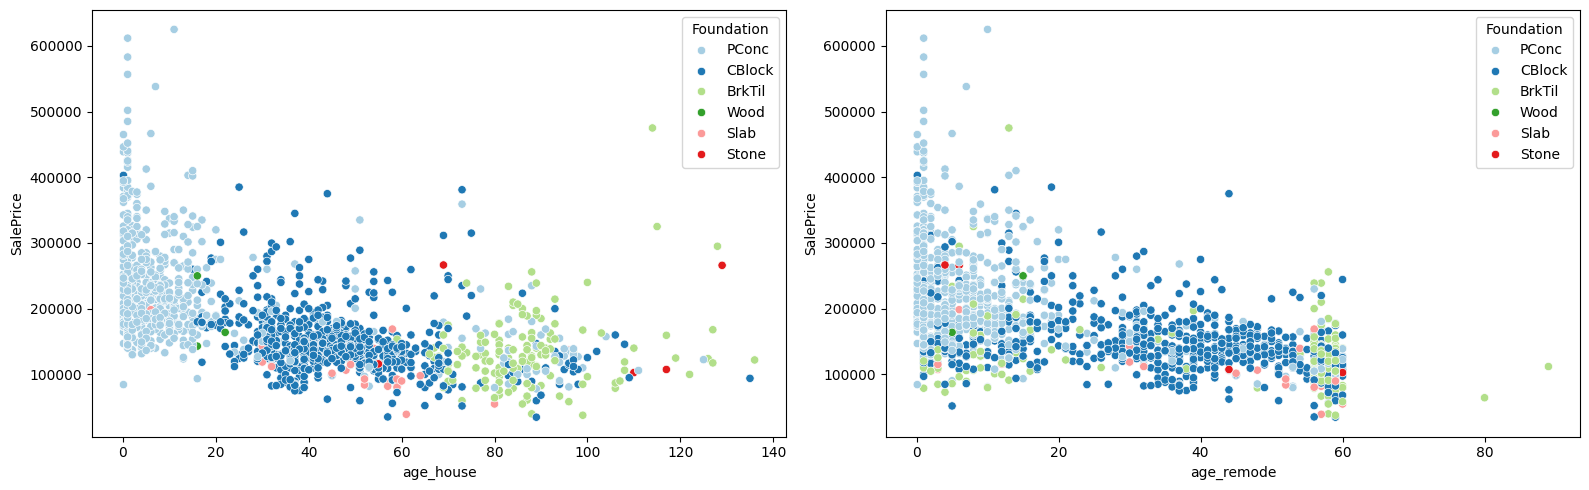

In [191]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.scatterplot(data=df, x='age_house', y='SalePrice', hue='Foundation', palette=palete, ax=axes[0])
sns.scatterplot(data=df, x='age_remode', y='SalePrice', hue='Foundation', palette=palete, ax=axes[1])
plt.tight_layout()
plt.show()

Interessante! A idade das casas guarda relação com o tipo de material utilizado, mas ainda não sei o que fazer com essa informação rsrsrs. Até o momento, nennhuma variável foi processada via One Hot Encoding. Meu palpite é que Foundation irá melhorar a performance do modelo.

In [192]:
df['index_qual_area'] = (np.sqrt(df['total_area']) / df['age_house']) * df['OverallQual']
df['index_qual_area_remod'] = (np.sqrt(df['total_area']) / df['age_remode']) * df['OverallQual']

adicionar_caracteristicas_fortemente_correlacionadas('age_house')
adicionar_caracteristicas_fortemente_correlacionadas('age_remode')

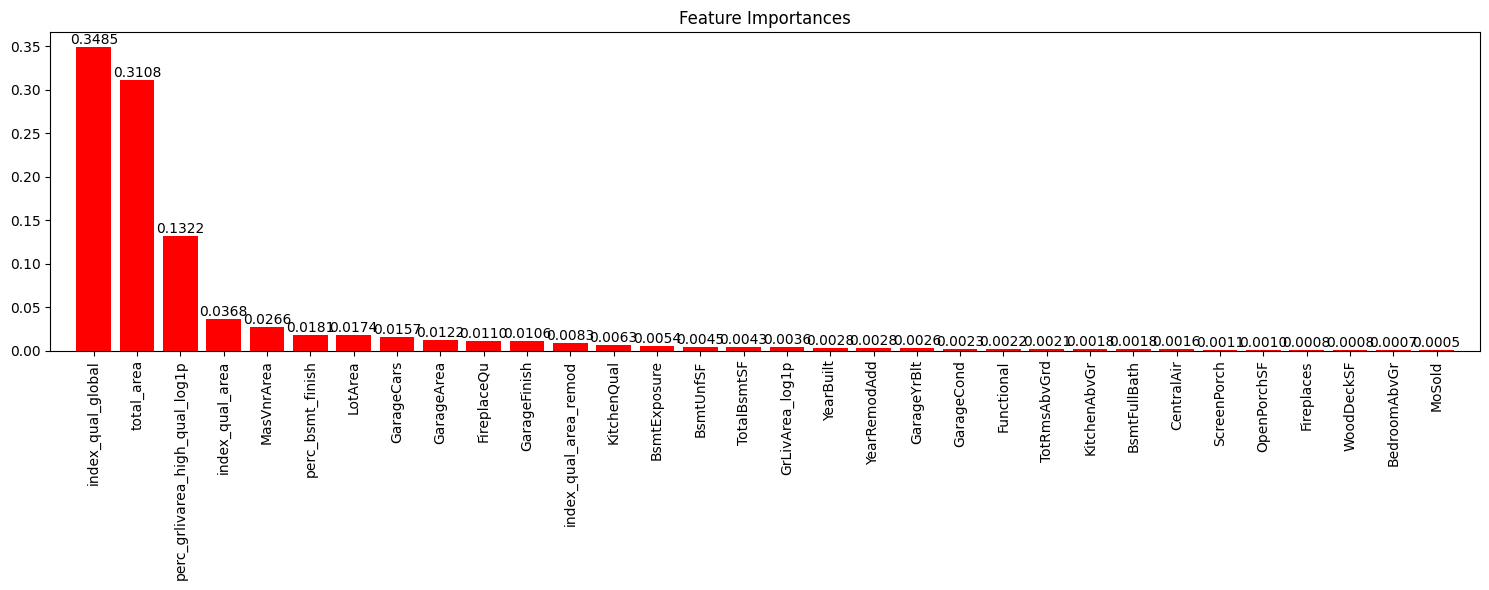

                                MIScore  Pearson  Spearman
index_qual_global                0.6354   0.8197    0.8313
total_area                       0.6598   0.7681    0.8144
MasVnrArea                       0.5825   0.7182    0.8081
perc_grlivarea_high_qual_log1p   0.6116   0.7624    0.8061
GrLivArea_log1p                  0.4887   0.6996    0.7303
index_qual_area                  0.4102   0.3262    0.7256
GarageArea                       0.3711   0.6509    0.6888
GarageCars                       0.3656   0.6509    0.6888
KitchenQual                      0.3232   0.6660    0.6712
index_qual_area_remod            0.3316   0.3303    0.6596
YearBuilt                        0.3597   0.5360    0.6524
GarageYrBlt                      0.2591   0.2698    0.6340
GarageCond                       0.2573   0.2699    0.6340
FullBath                         0.2520   0.5583    0.6334
GarageFinish                     0.2768   0.5584    0.6332
TotalBsmtSF                      0.3604   0.6388    0.59

In [193]:
plot_stats_features(df=df, num_features=32, remover_colunas_altamente_correlacionadas=True)

In [194]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS - 32 Features ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1240 0.0123    0.9074
4                  LGBMRegressor 0.1253 0.0127    0.8994
1            ExtraTreesRegressor 0.1255 0.0155    0.9032
6  HistGradientBoostingRegressor 0.1274 0.0129    0.9012
0          RandomForestRegressor 0.1290 0.0141    0.8997
5                   XGBRegressor 0.1316 0.0108    0.8901
7               BaggingRegressor 0.1322 0.0125    0.8934
3              AdaBoostRegressor 0.1751 0.0214    0.8422

##### GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond 

A primeira coisa que iremos fazer é analisar as correlações entre os atributos. Nosso objetivo é criar novos atributos e remover atributos que sejam altamente correlacionados para reduzir riscos de inserirmos ou multicolinearidade entre as features.

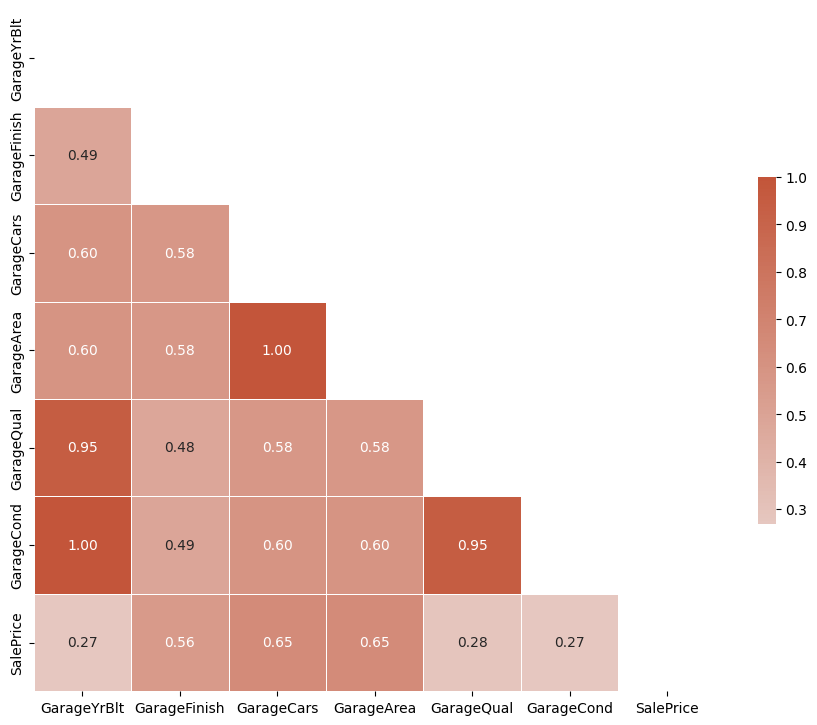

In [195]:
garage_cols = ['GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'SalePrice']

corr = df[garage_cols].corr()
plot_heatmap(corr)


Primeiramente, observamos que há correlação muito forte entre GarageArea e GarageCars, como também entre GarageQual e GarageCond. Iremos unir essas features. Caso a nova feature tenha MI Score superior, removeremos as features originais.

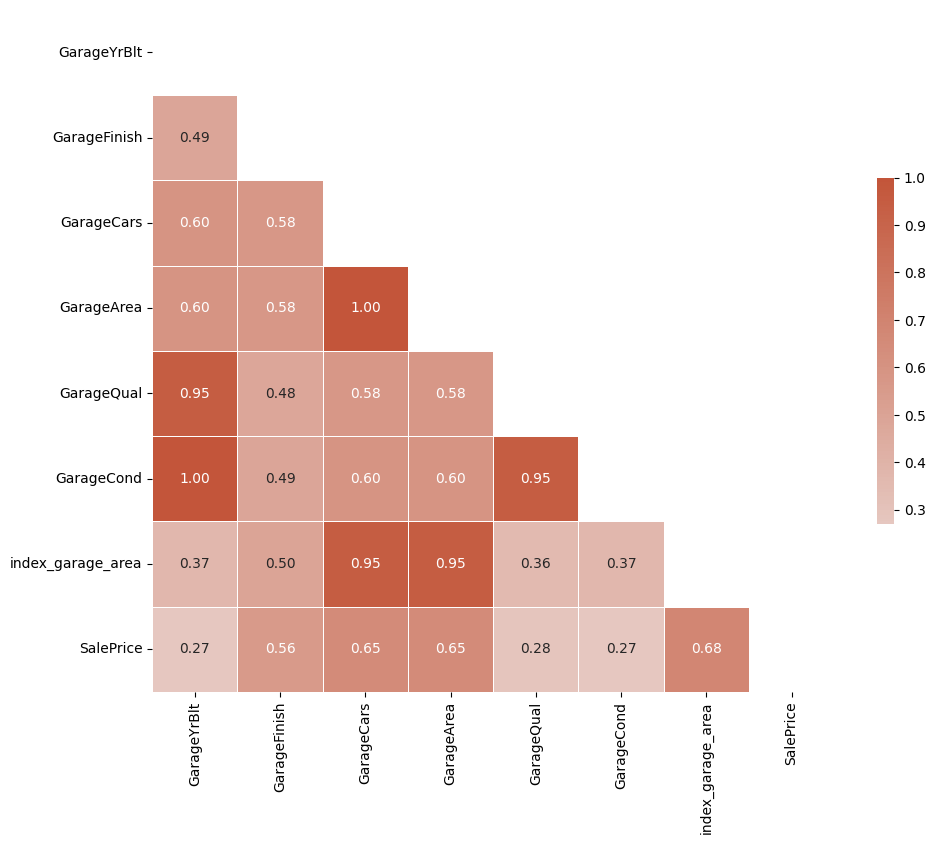

In [196]:
df['index_garage_area'] = np.nan_to_num(df.GarageArea * df.GarageCars * df.GarageCond)


garage_cols = ['GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'index_garage_area', 'SalePrice']
plot_heatmap(df[garage_cols].corr())

In [197]:
adicionar_caracteristicas_fortemente_correlacionadas('GarageArea')
adicionar_caracteristicas_fortemente_correlacionadas('GarageCars')
adicionar_caracteristicas_fortemente_correlacionadas('GarageCond')

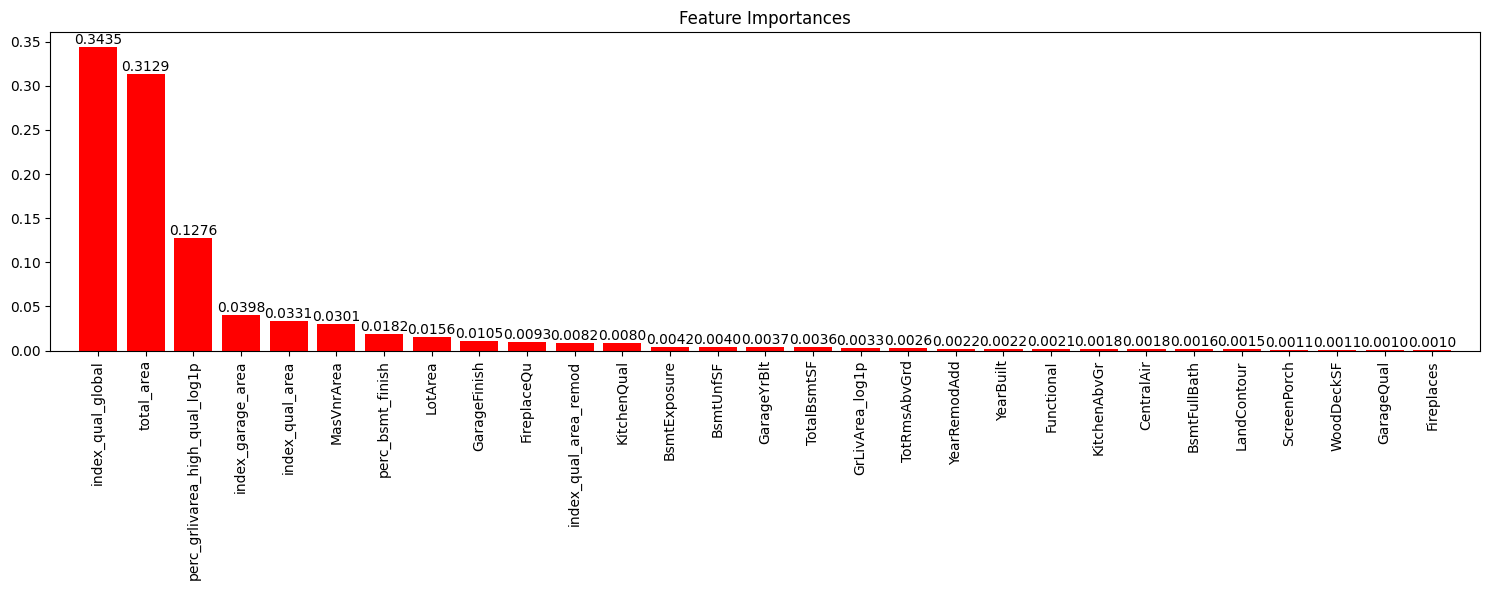

                                MIScore  Pearson  Spearman
index_qual_global                0.6149   0.8197    0.8313
total_area                       0.6603   0.7681    0.8144
MasVnrArea                       0.5668   0.7182    0.8081
perc_grlivarea_high_qual_log1p   0.6114   0.7624    0.8061
GrLivArea_log1p                  0.4870   0.6996    0.7303
index_qual_area                  0.4137   0.3262    0.7256
index_garage_area                0.4372   0.6837    0.7116
KitchenQual                      0.3279   0.6660    0.6712
index_qual_area_remod            0.3347   0.3303    0.6596
YearBuilt                        0.3582   0.5360    0.6524
GarageYrBlt                      0.2636   0.2698    0.6340
FullBath                         0.2498   0.5583    0.6334
GarageFinish                     0.2671   0.5584    0.6332
TotalBsmtSF                      0.3636   0.6388    0.5996
YearRemodAdd                     0.2489   0.5229    0.5722
FireplaceQu                      0.2139   0.5284    0.53

In [198]:
plot_stats_features(df=df, num_features=29, remover_colunas_altamente_correlacionadas=True)

In [199]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS (29 Features) ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1231 0.0133    0.9075
4                  LGBMRegressor 0.1248 0.0114    0.8989
6  HistGradientBoostingRegressor 0.1251 0.0119    0.9004
1            ExtraTreesRegressor 0.1270 0.0155    0.9019
0          RandomForestRegressor 0.1292 0.0144    0.9003
5                   XGBRegressor 0.1297 0.0111    0.8867
7               BaggingRegressor 0.1329 0.0142    0.8963
3              AdaBoostRegressor 0.1743 0.0227    0.8467

##### BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, TotRmsAbvGrd

In [200]:
rooms = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']

df['gr_liv_area_per_rooms_abgr'] = df.GrLivArea / df.TotRmsAbvGrd
df['bedrooms_per_totalrooms'] = df.BedroomAbvGr / df.TotRmsAbvGrd
df['total_bath_rooms'] = (df.BsmtFullBath * 2) + df.BsmtHalfBath + (df.FullBath * 2) + df.HalfBath
df['total_full_half_bathroom_ponderados'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']

adicionar_caracteristicas_fortemente_correlacionadas('TotalBsmtSF')

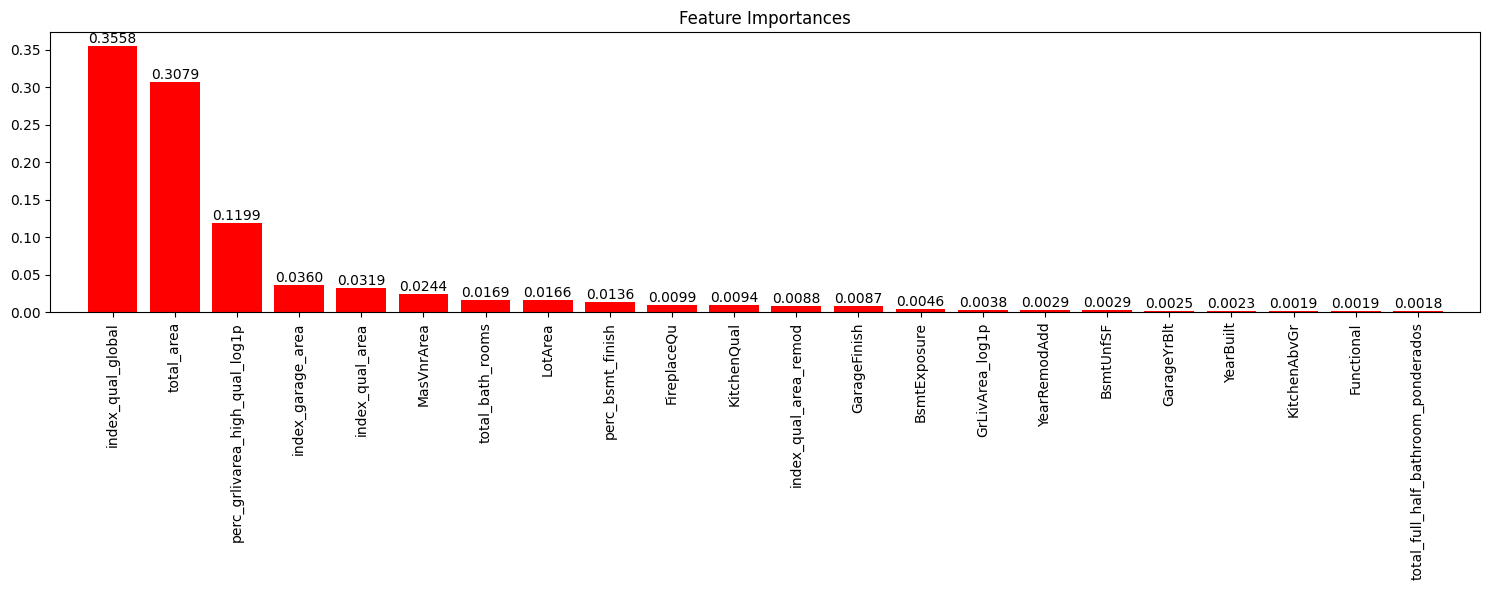

                                     MIScore  Pearson  Spearman
index_qual_global                     0.6257   0.8197    0.8313
total_area                            0.6588   0.7681    0.8144
MasVnrArea                            0.5743   0.7182    0.8081
perc_grlivarea_high_qual_log1p        0.6127   0.7624    0.8061
GrLivArea_log1p                       0.4873   0.6996    0.7303
index_qual_area                       0.4132   0.3262    0.7256
index_garage_area                     0.4341   0.6837    0.7116
total_bath_rooms                      0.3499   0.6360    0.7023
total_full_half_bathroom_ponderados   0.3465   0.6360    0.7023
KitchenQual                           0.3222   0.6660    0.6712
index_qual_area_remod                 0.3348   0.3303    0.6596
YearBuilt                             0.3606   0.5360    0.6524
GarageYrBlt                           0.2561   0.2698    0.6340
FullBath                              0.2695   0.5583    0.6334
GarageFinish                          0.

In [201]:
plot_stats_features(df=df, remover_colunas_altamente_correlacionadas=True, num_features=22)

In [202]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS 22 features ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1223 0.0123    0.9118
6  HistGradientBoostingRegressor 0.1257 0.0124    0.9052
4                  LGBMRegressor 0.1260 0.0133    0.9038
0          RandomForestRegressor 0.1273 0.0143    0.9083
1            ExtraTreesRegressor 0.1276 0.0143    0.9090
5                   XGBRegressor 0.1286 0.0100    0.8983
7               BaggingRegressor 0.1289 0.0163    0.8965
3              AdaBoostRegressor 0.1718 0.0200    0.8531

##### LotArea e LotFrontage

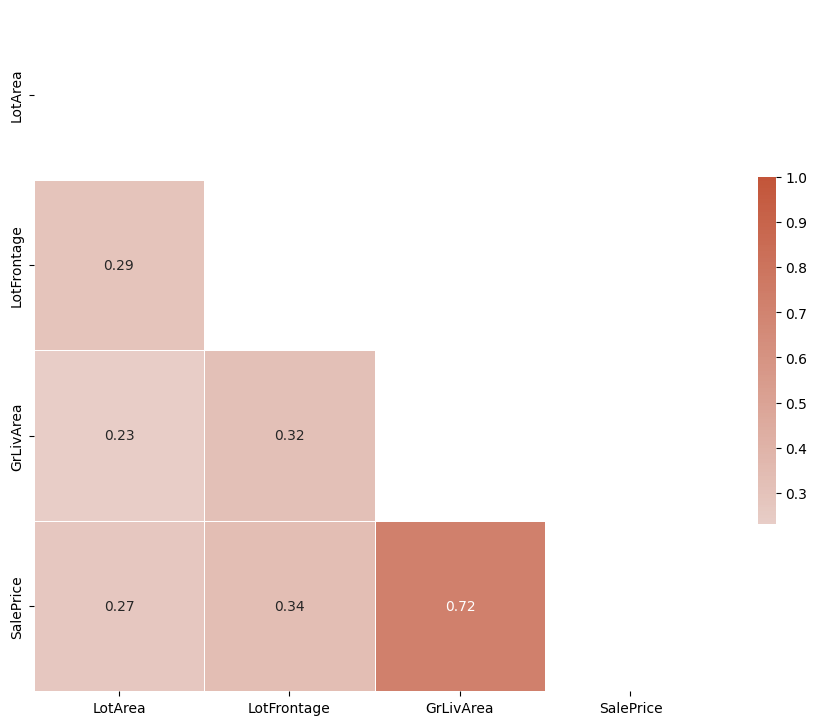

In [203]:
plot_heatmap(df[['LotArea', 'LotFrontage', 'GrLivArea', 'SalePrice']].corr())

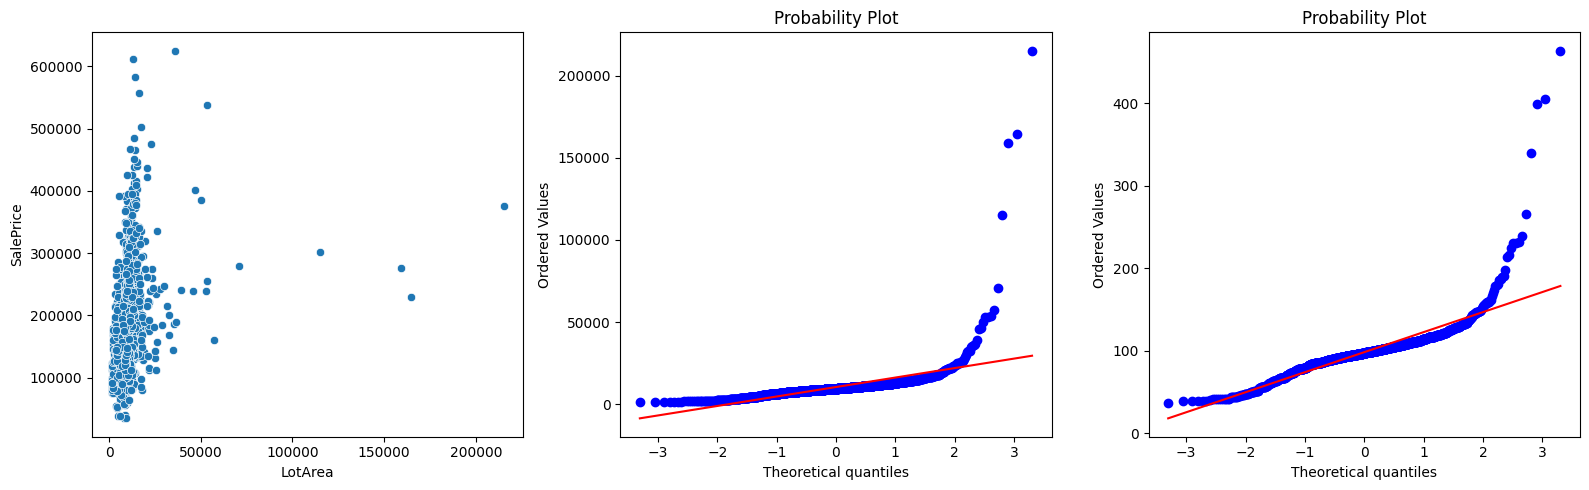

In [204]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
sns.scatterplot(data=df, x='LotArea', y='SalePrice', ax=axes[0])
stats.probplot(df['LotArea'], dist=stats.norm, plot=axes[1])
stats.probplot(np.sqrt(df['LotArea']), dist=stats.norm, plot=axes[2])
plt.tight_layout()
plt.show()


In [205]:
outliers = df[df.LotArea > 100000]
df.iloc[outliers.index]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street  LotShape  \
249  250          50       RL      75.0000   159000   Pave         2   
313  314          20       RL     150.0000   215245   Pave         1   
336  337          20       RL      86.0000    14157   Pave         3   
711  712          50  C (all)      66.0000     8712   Pave         4   

     LandContour  Utilities  LotConfig  LandSlope Neighborhood Condition1  \
249            1          4          5          1      ClearCr       Norm   
313            1          4          1          1       Timber       Norm   
336            2          4          3          3      StoneBr       Norm   
711            2          4          1          2       IDOTRR       Norm   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
249       Norm     1Fam     1.5Fin            6            7       1958   
313       Norm     1Fam     1Story            7            7       1965   
336       Norm     1Fam     1Story            9            7       2005   
711       Norm     1Fam     1.5Fin            4            7       1900   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  MasVnrType  \
249          2006     Gable  CompShg     Wd Sdng     HdBoard           0   
313          1965       Hip  CompShg     BrkFace     BrkFace           3   
336          2006       Hip  CompShg     VinylSd     VinylSd           2   
711          1950     Gable  CompShg     MetalSd     MetalSd           3   

     MasVnrArea  ExterQual  ExterCond Foundation  BsmtQual  BsmtCond  \
249      4.6478          4          4     CBlock         4         3   
313      4.6701          3          4     CBlock         4         3   
336      5.8485          4          4      PConc         5         3   
711      2.7086          3          4      Stone         3         3   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
249             4          Rec         697          Unf           0   
313             4          ALQ        1236          Rec         820   
336             4          GLQ        1249          Unf           0   
711             2          Unf           0          Unf           0   

     BsmtUnfSF  TotalBsmtSF Heating  HeatingQC  CentralAir  Electrical  \
249        747         1444    GasA          4           1           5   
313         80         2136    GasW          3           1           5   
336        673         1922    GasA          5           1           5   
711        859          859    GasA          4           1           5   

     GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
249       2144             0             1         2         0             4   
313       2036             2             0         2         0             3   
336       1922             1             0         2         0             3   
711       1178             0             0         1         0             2   

     KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  \
249             1            4             7           8           2   
313             1            3             8           8           2   
336             1            4             8           8           1   
711             1            3             7           8           0   

     FireplaceQu GarageType  GarageYrBlt  GarageFinish  GarageCars  \
249            3     Attchd    1958.0000             3           2   
313            4     Attchd    1965.0000             2           2   
336            4     Attchd    2005.0000             3           3   
711            0     Detchd    1964.0000             2           1   

     GarageArea  GarageQual  GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  \
249           2           3        1958           3           0           98   
313           2           3        1965           3           0            0   
336           3           3        2005           3         1

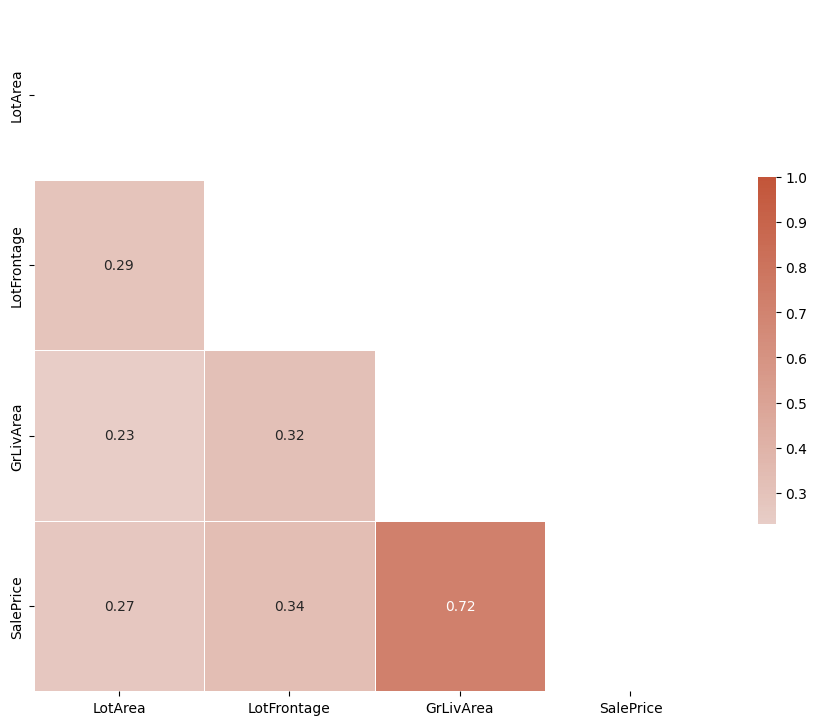

In [206]:
plot_heatmap(df[['LotArea', 'LotFrontage', 'GrLivArea', 'SalePrice']].corr())

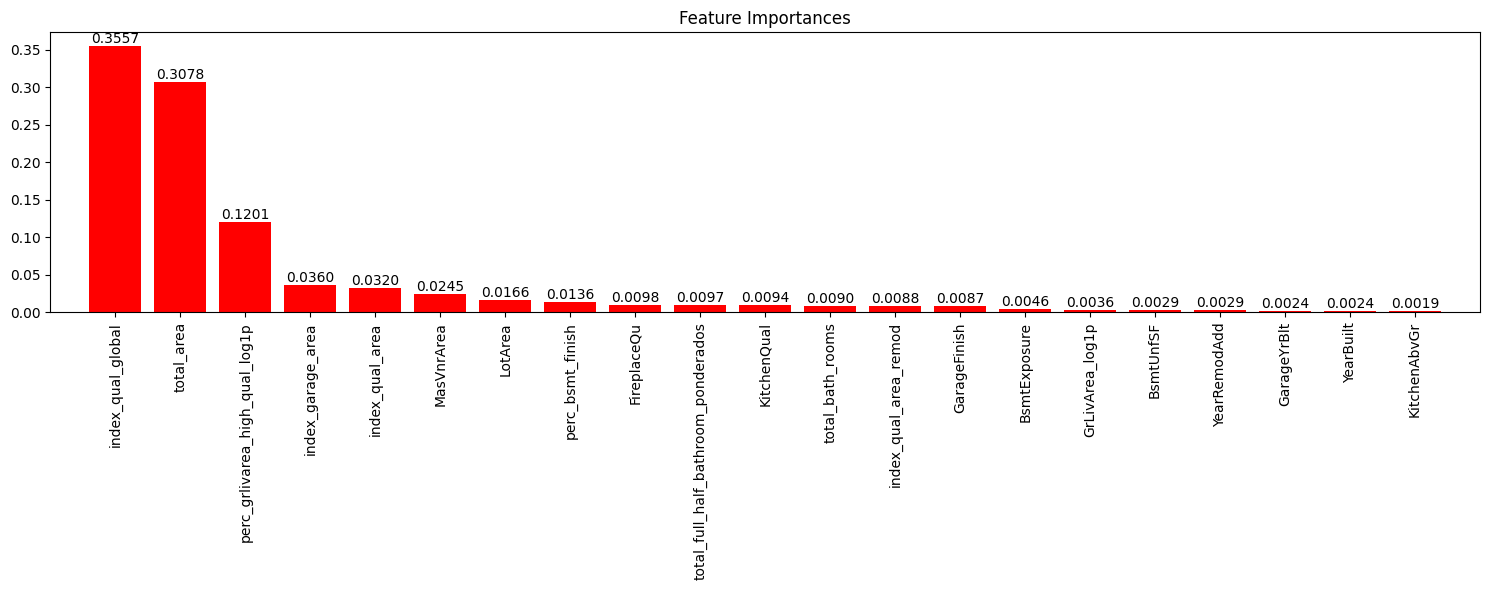

                                     MIScore  Pearson  Spearman
index_qual_global                     0.6257   0.8197    0.8313
total_area                            0.6588   0.7681    0.8144
MasVnrArea                            0.5743   0.7182    0.8081
perc_grlivarea_high_qual_log1p        0.6127   0.7624    0.8061
GrLivArea_log1p                       0.4873   0.6996    0.7303
index_qual_area                       0.4132   0.3262    0.7256
index_garage_area                     0.4341   0.6837    0.7116
total_bath_rooms                      0.3499   0.6360    0.7023
total_full_half_bathroom_ponderados   0.3465   0.6360    0.7023
KitchenQual                           0.3222   0.6660    0.6712
index_qual_area_remod                 0.3348   0.3303    0.6596
YearBuilt                             0.3606   0.5360    0.6524
GarageYrBlt                           0.2561   0.2698    0.6340
FullBath                              0.2695   0.5583    0.6334
GarageFinish                          0.

In [207]:
plot_stats_features(df=df, num_features=21, remover_colunas_altamente_correlacionadas=True)

In [208]:
df['total_area_freq'] = df.groupby(by=['index_qual_global'])['total_area'].transform('mean')
df = adicionar_preco_metro_quadrado(dataframe=df, col='Neighborhood')

In [209]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS 21 Features ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1216 0.0133    0.9104
6  HistGradientBoostingRegressor 0.1253 0.0124    0.9042
4                  LGBMRegressor 0.1253 0.0124    0.9062
1            ExtraTreesRegressor 0.1263 0.0142    0.9082
0          RandomForestRegressor 0.1281 0.0151    0.9066
5                   XGBRegressor 0.1284 0.0085    0.9028
7               BaggingRegressor 0.1314 0.0130    0.9019

##### total_area_freq, preço metro quadrado e foundation_count

##### Conditions

In [210]:
dft = get_dataframe(path=PATH_TRAIN)

In [211]:
dft[['Condition1', 'Condition2']].value_counts()


Condition1  Condition2
Norm        Norm          1260
Feedr       Norm            76
Artery      Norm            45
RRAn        Norm            22
PosN        Norm            17
RRAe        Norm            11
PosA        Norm             8
RRAn        Feedr            4
RRNn        Norm             4
Feedr       RRNn             2
PosN        PosN             2
RRNe        Norm             2
Artery      Artery           2
Feedr       RRAn             1
            RRAe             1
            Feedr            1
Artery      PosA             1
RRNn        Feedr            1
Name: count, dtype: int64

In [212]:
dft['conditions'] = dft[['Condition1', 'Condition2']].apply(lambda row: f'{row.Condition1}-{row.Condition2}', axis=1)
dft.conditions.value_counts()

conditions
Norm-Norm        1260
Feedr-Norm         76
Artery-Norm        45
RRAn-Norm          22
PosN-Norm          17
RRAe-Norm          11
PosA-Norm           8
RRNn-Norm           4
RRAn-Feedr          4
Feedr-RRNn          2
Artery-Artery       2
RRNe-Norm           2
PosN-PosN           2
Feedr-Feedr         1
RRNn-Feedr          1
Artery-PosA         1
Feedr-RRAn          1
Feedr-RRAe          1
Name: count, dtype: int64

In [213]:
dft['conditions_count'] = dft.groupby(by=['OverallQual'])['conditions'].transform('count')

In [214]:
dft[['conditions_count', 'SalePrice']].corr(method='spearman')

conditions_count  SalePrice
conditions_count            1.0000    -0.4086
SalePrice                  -0.4086     1.0000

In [215]:
plot_stats_features(df=dft, num_features=45, remover_colunas_altamente_correlacionadas=True)

ValueError: Input X contains NaN.

##### Exterior

In [952]:
dft = get_dataframe(path=PATH_TRAIN)

In [953]:
dft[['Exterior1st', 'Exterior2nd']].value_counts()

Exterior1st  Exterior2nd
VinylSd      VinylSd        502
MetalSd      MetalSd        212
HdBoard      HdBoard        193
Wd Sdng      Wd Sdng        177
Plywood      Plywood         96
CemntBd      CmentBd         59
BrkFace      BrkFace         24
HdBoard      Plywood         23
Stucco       Stucco          20
AsbShng      AsbShng         17
WdShing      Wd Shng         17
BrkFace      Wd Sdng         12
Wd Sdng      Wd Shng          9
             Plywood          8
BrkFace      Plywood          6
WdShing      Plywood          5
VinylSd      Wd Shng          5
Plywood      Brk Cmn          5
MetalSd      HdBoard          3
Wd Sdng      ImStucc          3
Stucco       Wd Shng          3
BrkFace      HdBoard          3
Plywood      ImStucc          3
Wd Sdng      VinylSd          2
VinylSd      Plywood          2
WdShing      HdBoard          2
MetalSd      Wd Sdng          2
Wd Sdng      HdBoard          2
HdBoard      ImStucc          2
Plywood      HdBoard          2
AsbShng      Pl

In [954]:
dft['exteriors'] = dft[['Exterior1st', 'Exterior2nd']].apply(lambda row: f'{row.Exterior1st}-{row.Exterior2nd}', axis=1)

In [955]:
dft['exteriors'] = dft.groupby(by=['OverallQual'])['exteriors'].transform('count')

In [956]:
dft[['exteriors', 'SalePrice']].corr(method='spearman')

exteriors  SalePrice
exteriors     1.0000    -0.4086
SalePrice    -0.4086     1.0000

##### Config, Shape e Slope

In [957]:
dft['shape_slope'] = dft[['LotShape', 'LandSlope']].apply(lambda row: f'{row.LotShape}-{row.LandSlope}', axis=1)
dft['shape_slope_count'] = dft.groupby(by=['LotShape'])['shape_slope'].transform('count')
dft['lotconfig_count'] = dft.groupby(by=['LotConfig'])['LotConfig'].transform('count')


dft[['shape_slope_count', 'SalePrice', 'lotconfig_count']].corr(method='spearman')

shape_slope_count  SalePrice  lotconfig_count
shape_slope_count             1.0000    -0.3211           0.2863
SalePrice                    -0.3211     1.0000          -0.1015
lotconfig_count               0.2863    -0.1015           1.0000

##### BsmtUnfSF

In [958]:
dft[['BsmtUnfSF', 'SalePrice']].corr(method='spearman')

BsmtUnfSF  SalePrice
BsmtUnfSF     1.0000     0.1852
SalePrice     0.1852     1.0000

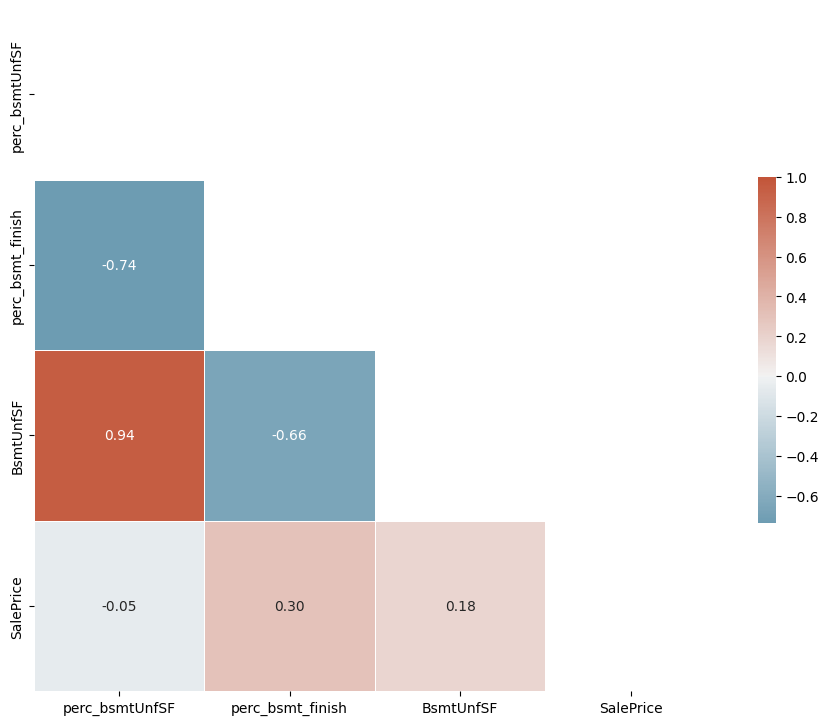

In [959]:
dft['perc_bsmtUnfSF'] = dft['BsmtUnfSF'] / dft['TotalBsmtSF']
plot_heatmap(df[['perc_bsmtUnfSF', 'perc_bsmt_finish', 'BsmtUnfSF', 'SalePrice']].corr(method='spearman'))

##### BsmtExposure

In [960]:
dft['bsmt_exposure_count'] = dft.groupby(by=['BsmtQual'])['BsmtExposure'].transform('count')
dft[['bsmt_exposure_count', 'SalePrice']].corr('spearman')

bsmt_exposure_count  SalePrice
bsmt_exposure_count               1.0000    -0.5622
SalePrice                        -0.5622     1.0000

##### BsmtFinType1 e BsmtFinType2

In [961]:
dft['bsmt_fin_types'] = dft[['BsmtFinType1', 'BsmtFinType2']].apply(lambda row: f'{row.BsmtFinType1}-{row.BsmtFinType2}', axis=1)
dft['bsmt_fin_types_count'] = dft.groupby(by=['BsmtQual'])['bsmt_fin_types'].transform('count')

In [963]:
dft[['bsmt_fin_types_count', 'SalePrice']].corr('spearman')

bsmt_fin_types_count  SalePrice
bsmt_fin_types_count                1.0000    -0.5622
SalePrice                          -0.5622     1.0000

##### Functional

In [1005]:
dft['functional_count'] = dft.groupby(by=['Functional'])['Functional'].transform('count')
dft[['functional_count', 'SalePrice']].corr('spearman')

functional_count  SalePrice
functional_count            1.0000     0.1353
SalePrice                   0.1353     1.0000

<Axes: xlabel='functional_count', ylabel='SalePrice'>

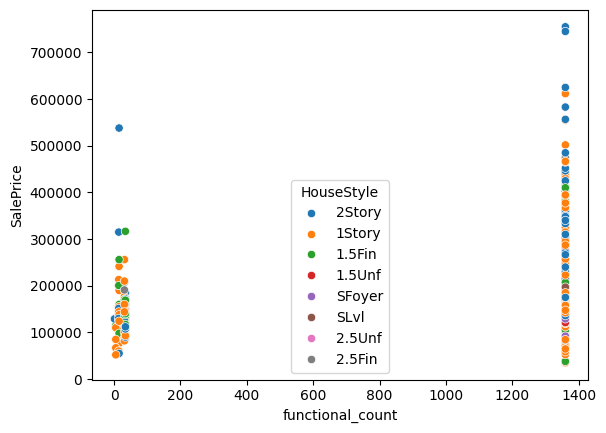

In [1006]:
sns.scatterplot(data=dft, x='functional_count', y='SalePrice', hue='HouseStyle')

In [1564]:
df_preco_metro_quadrado = adicionar_preco_metro_quadrado(dataframe=dft, col='functional_count')
df_preco_metro_quadrado

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL      65.0000     8450   Pave   NaN      Reg   
1        2          20       RL      80.0000     9600   Pave   NaN      Reg   
2        3          60       RL      68.0000    11250   Pave   NaN      IR1   
3        4          70       RL      60.0000     9550   Pave   NaN      IR1   
4        5          60       RL      84.0000    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL      62.0000     7917   Pave   NaN      Reg   
1456  1457          20       RL      85.0000    13175   Pave   NaN      Reg   
1457  1458          70       RL      66.0000     9042   Pave   NaN      Reg   
1458  1459          20       RL      68.0000     9717   Pave   NaN      Reg   
1459  1460          20       RL      75.0000     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
1455         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1456         Lvl    AllPub    Inside       Gtl       NWAmes       Norm   
1457         Lvl    AllPub    Inside       Gtl      Crawfor       Norm   
1458         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1459         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
2          Norm     1Fam     2Story            7            5       2001   
3          Norm     1Fam     2Story            7            5       1915   
4          Norm     1Fam     2Story            8            5       2000   
...         ...      ...        ...          ...          ...        ...   
1455       Norm     1Fam     2Story            6            5       1999   
1456       Norm     1Fam     1Story            6            6       1978   
1457       Norm     1Fam     2Story            7            9       1941   
1458       Norm     1Fam     1Story            5            6       1950   
1459       Norm     1Fam     1Story            5            6       1965   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
1455          2000     Gable  CompShg     VinylSd     VinylSd        NaN   
1456          1988     Gable  CompShg     Plywood     Plywood      Stone   
1457          2006     Gable  CompShg     CemntBd     CmentBd        NaN   
1458          1996       Hip  CompShg     MetalSd     MetalSd        NaN   
1459          1965     Gable  CompShg     HdBoard     HdBoard        NaN   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0       196.0000        Gd        TA      PConc       Gd       TA   
1         0.0000        TA        TA     CBlock       Gd       TA   
2       162.0000        Gd        TA      PConc       Gd       TA   
3         0.0000        TA        TA     BrkTil       TA       Gd   

##### PCA

In [308]:
df, teste = obter_dataframe_processado()

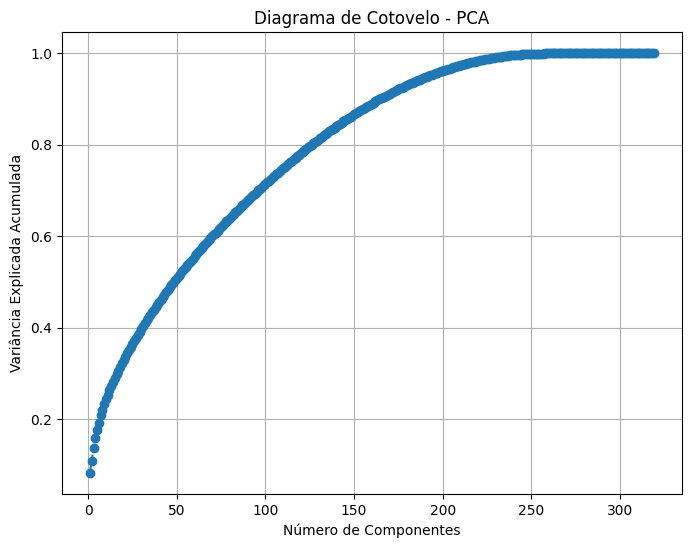

In [312]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Supondo que 'df' seja o DataFrame original e estamos utilizando apenas colunas numéricas
numerical_features = df.select_dtypes(include=['number']).columns
data = df[numerical_features]

# Normalizar os dados antes do PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Aplicando o PCA
pca = PCA()
pca.fit(data_scaled)

# Variância explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Variância explicada acumulada
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plotando o diagrama de cotovelo
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Diagrama de Cotovelo - PCA')
plt.grid(True)
plt.show()

In [313]:
pcat = pca.transform(data_scaled)


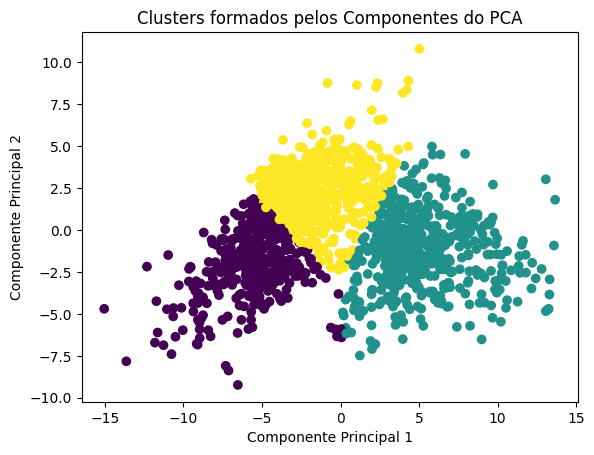

In [317]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Suponha que 'df' seja o DataFrame com as variáveis numéricas
X = df.select_dtypes(include=['number'])

# Normalizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicando o PCA
pca = PCA(n_components=2)  # Reduzimos para 2 componentes para fins de visualização
X_pca = pca.fit_transform(X_scaled)

# Aplicando o K-Means para criar clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Adicionando os clusters ao DataFrame
df['Cluster'] = clusters

# Plotando os clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters formados pelos Componentes do PCA')
plt.show()

## Tunning

#### config

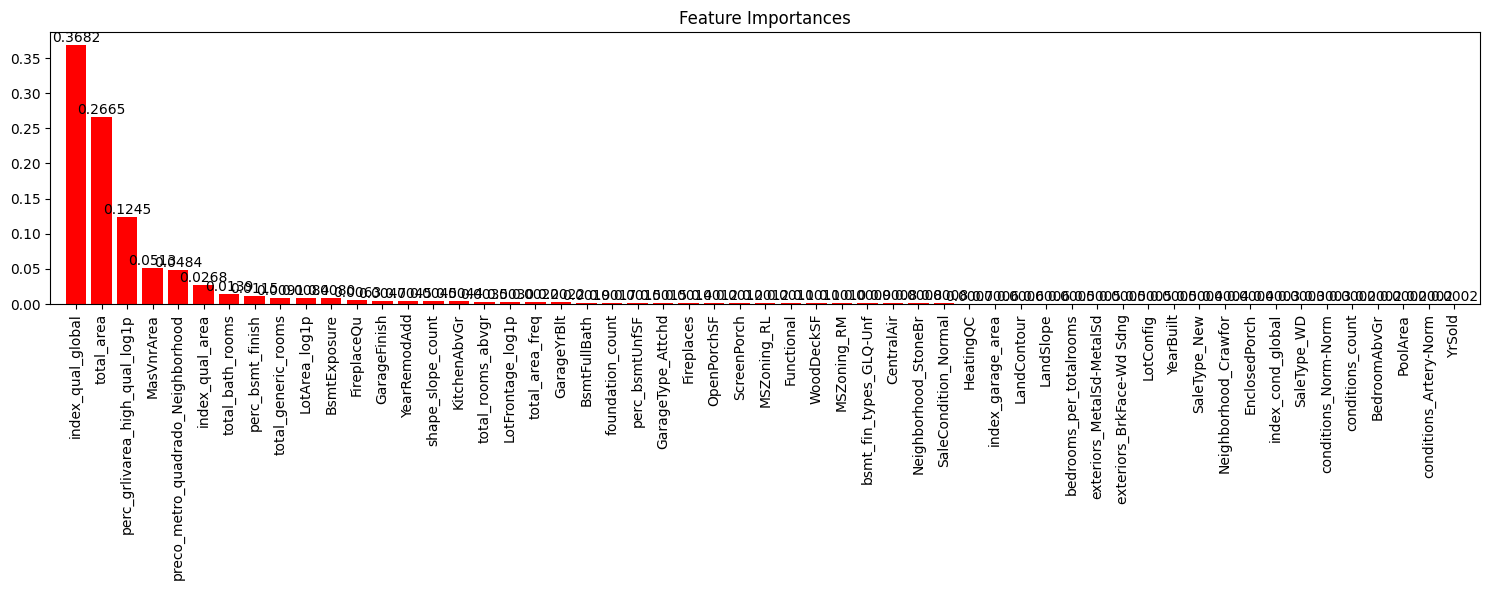

                                   MIScore  Pearson  Spearman
index_qual_global                   0.6463   0.8223    0.8387
total_area                          0.6603   0.7681    0.8144
perc_grlivarea_high_qual_log1p      0.6129   0.7624    0.8061
index_qual_area                     0.4715   0.3445    0.7699
preco_metro_quadrado_Neighborhood   0.5002   0.6904    0.7346
total_generic_rooms                 0.4389   0.7054    0.7325
index_garage_area                   0.4355   0.6837    0.7116
total_bath_rooms                    0.3137   0.6164    0.6902
MasVnrArea                          0.5687   0.7248    0.6555
YearBuilt                           0.3549   0.5360    0.6524
index_cond_global                   0.2642   0.2701    0.6365
GarageYrBlt                         0.2615   0.2698    0.6340
GarageFinish                        0.2640   0.5584    0.6332
total_rooms_abvgr                   0.2994   0.6024    0.6233
YearRemodAdd                        0.2569   0.5229    0.5722
Foundati

In [132]:
df, teste = obter_dataframe_processado()
plot_stats_features(df=df, num_features=55, remover_colunas_altamente_correlacionadas=True)

In [284]:
best_cols = ['index_qual_global',
 'total_area',
 'perc_grlivarea_high_qual_log1p',
 'MasVnrArea',
 'preco_metro_quadrado_Neighborhood',
 'index_qual_area',
 'total_bath_rooms',
 'perc_bsmt_finish',
 'total_area_freq',
 'total_generic_rooms',
 'LotArea_log1p',
 'FireplaceQu',
 'BsmtExposure',
 'GarageFinish',
 'conditions_count',
 'YearRemodAdd',
 'total_rooms_abvgr',
 'index_cond_global',
 'LotFrontage_log1p',
 'KitchenAbvGr',
 'GarageType_Attchd',
 'foundation_count',
 'bsmt_fin_types_GLQ-Unf',
 'Fireplaces',
 'diff_gr_liv_area_lot_area',
 'YearBuilt',
 'ScreenPorch',
 'CentralAir',
 'Functional',
 'Neighborhood_StoneBr',
 'WoodDeckSF',
 'MSZoning_RM',
 'SaleCondition_Normal',
 'MSZoning_RL',
 'HeatingQC',
 'exteriors_BrkFace-Wd Sdng',
 'perc_bsmtUnfSF',
 'OpenPorchSF',
 'Neighborhood_Crawfor',
 'bedrooms_per_totalrooms',
 'LotConfig',
 'index_garage_area',
 'conditions_Norm-Norm',
 'BedroomAbvGr',
 'BsmtFullBath',
 'GarageYrBlt',
 'Neighborhood_Timber',
 'EnclosedPorch',
 'LandContour',
 '3SsnPorch',
 'SaleType_New',
 'conditions_Artery-Norm',
 'PoolArea',
 'SaleCondition_Partial']

### GradientBoostingRegressor

In [280]:
best_cols = ['index_qual_global',
 'total_area',
 'perc_grlivarea_high_qual_log1p',
 'MasVnrArea',
 'preco_metro_quadrado_Neighborhood',
 'index_qual_area',
 'total_bath_rooms',
 'perc_bsmt_finish',
 'total_area_freq',
 'total_generic_rooms',
 'LotArea_log1p',
 'FireplaceQu',
 'BsmtExposure',
 'GarageFinish',
 'conditions_count',
 'YearRemodAdd',
 'total_rooms_abvgr',
 'index_cond_global',
 'LotFrontage_log1p',
 'KitchenAbvGr',
 'GarageType_Attchd',
 'foundation_count',
 'bsmt_fin_types_GLQ-Unf',
 'Fireplaces',
 'diff_gr_liv_area_lot_area',
 'YearBuilt',
 'ScreenPorch',
 'CentralAir',
 'Functional',
 'Neighborhood_StoneBr',
 'WoodDeckSF',
 'MSZoning_RM',
 'SaleCondition_Normal',
 'MSZoning_RL',
 'HeatingQC',
 'exteriors_BrkFace-Wd Sdng',
 'perc_bsmtUnfSF',
 'OpenPorchSF',
 'Neighborhood_Crawfor',
 'bedrooms_per_totalrooms',
 'LotConfig',
 'index_garage_area',
 'conditions_Norm-Norm',
 'BedroomAbvGr',
 'BsmtFullBath',
 'GarageYrBlt',
 'Neighborhood_Timber',
 'EnclosedPorch',
 'LandContour',
 '3SsnPorch',
 'SaleType_New',
 'conditions_Artery-Norm',
 'PoolArea',
 'SaleCondition_Partial']

In [290]:
df, teste = obter_dataframe_processado()


# Função de avaliação utilizando log_rmse com validação cruzada estratificada
def gb_evaluate(trial):
    # Sugerir parâmetros com base no espaço de busca
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.01),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8),
        'subsample': trial.suggest_uniform('subsample', 0.2, 0.5)
    }
    
    # Inicializar o modelo com os parâmetros
    model = GradientBoostingRegressor(**params)

    # Definir o StratifiedKFold para a validação cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=90)
    log_rmse_scores = []

    for train_index, test_index in skf.split(df[best_cols], df['GarageQual']):
        X_train_cv, X_valid_cv = df.iloc[train_index][best_cols], df.iloc[test_index][best_cols]
        y_train_cv, y_valid_cv = df.iloc[train_index].SalePrice_log1p, df.iloc[test_index].SalePrice_log1p
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_valid_cv)
        log_rmse_scores.append(log_rmse(y_valid_cv, y_pred_cv))
    
    # Retorna a média do log_rmse
    return np.mean(log_rmse_scores)

# Criar estudo Optuna
study = optuna.create_study(direction="minimize")
study.optimize(gb_evaluate, n_trials=30)

# Obter os melhores parâmetros
print(study.best_params)


[I 2024-09-12 21:16:48,190] A new study created in memory with name: no-name-02c06f50-d1df-4797-a8b9-aa058a18ef45
[I 2024-09-12 21:17:04,365] Trial 0 finished with value: 0.026986895082650154 and parameters: {'learning_rate': 0.00028452378431275186, 'n_estimators': 871, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.3329715299983379}. Best is trial 0 with value: 0.026986895082650154.
[I 2024-09-12 21:17:14,918] Trial 1 finished with value: 0.01768730818581112 and parameters: {'learning_rate': 0.0017095557780767356, 'n_estimators': 497, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.33694707486070785}. Best is trial 1 with value: 0.01768730818581112.
[I 2024-09-12 21:17:35,711] Trial 2 finished with value: 0.011269906855667143 and parameters: {'learning_rate': 0.0027062380223937406, 'n_estimators': 729, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.3899422772784149}. Best is trial 2 with value:

{'learning_rate': 0.009926064118579277, 'n_estimators': 1041, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.24385971536473275}


In [291]:
tunned_gbr = [
    {'random_state': 0, 'learning_rate': 0.009417451151623664, 'n_estimators': 1209, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.4074474052540213},
    {'random_state': 0, 'learning_rate': 0.009815323256152812, 'n_estimators': 627, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.36611868644990486},
    {'random_state': 0, 'learning_rate': 0.006473961765973521, 'n_estimators': 1213, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.3753641776864616},
    {'random_state': 0, 'learning_rate': 0.008947351155636996, 'n_estimators': 1091, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.2054549768091251},
    {'random_state': 0, 'learning_rate': 0.00965152897531624, 'n_estimators': 851, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.34325179964120933}
    {'learning_rate': 0.009926064118579277, 'n_estimators': 1041, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.24385971536473275}

]

### HistGradientBoostingRegressor

In [182]:
# Função de avaliação utilizando log_rmse
def gb_evaluate(trial):
    # Sugerir valores de hiperparâmetros com base no trial
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
        'max_bins': trial.suggest_int('max_bins', 2, 255),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 4.0)
    }
    
    # Inicializar o modelo com os parâmetros
    model = HistGradientBoostingRegressor(**params)

    # Definir o StratifiedKFold para a validação cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=90)
    log_rmse_scores = []

    for train_index, test_index in skf.split(df[best_cols], df['BsmtQual']):
        X_train_cv, X_valid_cv = df.iloc[train_index][best_cols], df.iloc[test_index][best_cols]
        y_train_cv, y_valid_cv = df.iloc[train_index].SalePrice_log1p, df.iloc[test_index].SalePrice_log1p
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_valid_cv)
        log_rmse_scores.append(log_rmse(y_valid_cv, y_pred_cv))
    
    # Retorna a média do log_rmse
    return np.mean(log_rmse_scores)

# Função que roda a otimização
def optimize():
    study = optuna.create_study(direction='minimize')  # Queremos minimizar o log_rmse
    study.optimize(gb_evaluate, n_trials=30)  # Número de tentativas de otimização

    # Melhor resultado
    print(f"Melhores parâmetros: {study.best_params}")
    print(f"Melhor log_rmse: {study.best_value}")

    return study

# Executar a otimização
study = optimize()

# Obter os melhores parâmetros após a otimização
best_params = study.best_params
print(best_params)

[I 2024-09-11 16:18:43,313] A new study created in memory with name: no-name-3bc234c5-5c8b-49df-a909-5f0d60ece54a
[I 2024-09-11 16:18:52,274] Trial 0 finished with value: 0.0104322691897514 and parameters: {'learning_rate': 0.029108695143471284, 'max_iter': 888, 'max_depth': 9, 'min_samples_leaf': 10, 'max_bins': 199, 'l2_regularization': 1.195217517723647}. Best is trial 0 with value: 0.0104322691897514.
[I 2024-09-11 16:18:57,041] Trial 1 finished with value: 0.01004857900188683 and parameters: {'learning_rate': 0.023850797470708056, 'max_iter': 990, 'max_depth': 4, 'min_samples_leaf': 6, 'max_bins': 223, 'l2_regularization': 3.5339126347577294}. Best is trial 1 with value: 0.01004857900188683.
[I 2024-09-11 16:18:58,682] Trial 2 finished with value: 0.009927681660250676 and parameters: {'learning_rate': 0.02899157421292373, 'max_iter': 496, 'max_depth': 3, 'min_samples_leaf': 9, 'max_bins': 161, 'l2_regularization': 1.0792483384538287}. Best is trial 2 with value: 0.0099276816602506

Melhores parâmetros: {'learning_rate': 0.03256392676513413, 'max_iter': 561, 'max_depth': 3, 'min_samples_leaf': 4, 'max_bins': 196, 'l2_regularization': 2.501688679286233}
Melhor log_rmse: 0.009834035885534541
{'learning_rate': 0.03256392676513413, 'max_iter': 561, 'max_depth': 3, 'min_samples_leaf': 4, 'max_bins': 196, 'l2_regularization': 2.501688679286233}


In [183]:
tunned_hgbr = [
    {'random_state': 0, 'learning_rate': 0.025730747961930683, 'max_iter': 358, 'max_depth': 3, 'min_samples_leaf': 4, 'max_bins': 221, 'l2_regularization': 1.3711585226213248},
    {'random_state': 0, 'learning_rate': 0.07706997866754527, 'max_iter': 546, 'max_depth': 2, 'min_samples_leaf': 2, 'max_bins': 247, 'l2_regularization': 2.642650259243635},
    {'random_state': 0, 'learning_rate': 0.08512460591372646, 'max_iter': 647, 'max_depth': 2, 'min_samples_leaf': 8, 'max_bins': 75, 'l2_regularization': 3.27018345417753},
    {'random_state': 0, 'learning_rate': 0.07003509124922215, 'max_iter': 748, 'max_depth': 2, 'min_samples_leaf': 7, 'max_bins': 136, 'l2_regularization': 3.8669248960174114},
    {'random_state': 0, 'learning_rate': 0.03256392676513413, 'max_iter': 561, 'max_depth': 3, 'min_samples_leaf': 4, 'max_bins': 196, 'l2_regularization': 2.501688679286233}
]

### XGBRegressor

In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Função de avaliação utilizando log_rmse
def gb_evaluate(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01),
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 0.5),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'objective': 'reg:squarederror',  
        'nthread': -1,
        'scale_pos_weight': 1,
        'seed': 7
    }

    # Inicializar o modelo com os parâmetros
    model = XGBRegressor(**params)

    # Definir o StratifiedKFold para a validação cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=90)
    log_rmse_scores = []

    for train_index, test_index in skf.split(df[best_cols], df['BsmtQual']):
        X_train_cv, X_valid_cv = df.iloc[train_index][best_cols], df.iloc[test_index][best_cols]
        y_train_cv, y_valid_cv = df.iloc[train_index].SalePrice_log1p, df.iloc[test_index].SalePrice_log1p
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_valid_cv)
        log_rmse_scores.append(log_rmse(y_valid_cv, y_pred_cv))
    
    # Retorna a média do log_rmse
    return np.mean(log_rmse_scores)

# Função que roda a otimização
def optimize():
    study = optuna.create_study(direction='minimize')  # Queremos minimizar o log_rmse
    study.optimize(gb_evaluate, n_trials=40)  # Número de tentativas de otimização

    # Melhor resultado
    print(f"Melhores parâmetros: {study.best_params}")
    print(f"Melhor log_rmse: {study.best_value}")

    return study

# Executar a otimização
study = optimize()

# Obter os melhores parâmetros após a otimização
best_params = study.best_params
print(best_params)

In [285]:
tunned_xgbr = [
    {'random_state': 0, 'learning_rate': 0.00800543120232191, 'n_estimators': 2722, 'max_depth': 4, 'min_child_weight': 0.0018123437946986221, 'gamma': 0.008216328868431249, 'subsample': 0.6076639372149405, 'colsample_bytree': 0.6646594233445756},
    {'random_state': 0, 'learning_rate': 0.006615447778408275, 'n_estimators': 2856, 'max_depth': 4, 'min_child_weight': 0.35303438946586474, 'gamma': 0.016456282780779714, 'subsample': 0.679577330735415, 'colsample_bytree': 0.7368712813561247},
    {'random_state': 0, 'learning_rate': 0.004321005131545092, 'n_estimators': 3560, 'max_depth': 3, 'min_child_weight': 0.00108880330794752, 'gamma': 0.022413354760999926, 'subsample': 0.6807350794212111, 'colsample_bytree': 0.5921031509743773},
    {'random_state': 0, 'learning_rate': 0.00899330468390837, 'n_estimators': 4345, 'max_depth': 3, 'min_child_weight': 0.3138183532755724, 'gamma': 0.010174486271137404, 'subsample': 0.6208946469384112, 'colsample_bytree': 0.6352067025624579},
    {'random_state': 0, 'learning_rate': 0.004793188725851163, 'n_estimators': 3075, 'max_depth': 4, 'min_child_weight': 0.3480211675801235, 'gamma': 0.0049187405681855555, 'subsample': 0.51143231174259, 'colsample_bytree': 0.5068120022835744}
]


### RandomForestRegressor

In [262]:
from sklearn.ensemble import RandomForestRegressor

def rf_evaluate(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5) 
    }
    
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)

   # Definir o StratifiedKFold para a validação cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=90)
    log_rmse_scores = []

    for train_index, test_index in skf.split(df[best_cols], df['BsmtQual']):
        X_train_cv, X_valid_cv = df.iloc[train_index][best_cols], df.iloc[test_index][best_cols]
        y_train_cv, y_valid_cv = df.iloc[train_index].SalePrice_log1p, df.iloc[test_index].SalePrice_log1p
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_valid_cv)
        log_rmse_scores.append(log_rmse(y_valid_cv, y_pred_cv))
    
    # Retorna a média do log_rmse
    return np.mean(log_rmse_scores)


# Função que roda a otimização
def optimize():
    study = optuna.create_study(direction='minimize')  
    study.optimize(rf_evaluate, n_trials=30)  
    return study

# Executar a otimização
study = optimize()

# Obter os melhores parâmetros após a otimização
best_params = study.best_params
print(best_params)

[I 2024-09-12 13:35:54,863] A new study created in memory with name: no-name-a8c61330-5be4-40a5-8f68-a1ad6830cb41
[I 2024-09-12 13:36:05,422] Trial 0 finished with value: 0.010982004549841658 and parameters: {'n_estimators': 985, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.010982004549841658.
[I 2024-09-12 13:36:14,483] Trial 1 finished with value: 0.01108018206142345 and parameters: {'n_estimators': 867, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.010982004549841658.
[I 2024-09-12 13:36:20,354] Trial 2 finished with value: 0.010905318212044693 and parameters: {'n_estimators': 502, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.010905318212044693.
[I 2024-09-12 13:36:29,766] Trial 3 finished with value: 0.010779577523442163 and parameters: {'n_estimators': 583, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is tria

{'n_estimators': 761, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1}


In [265]:
rfr_params = [
    {'n_estimators': 319, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1},
    {'n_estimators': 480, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'n_estimators': 922, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1},
    {'n_estimators': 887, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2},
    {'n_estimators': 761, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1}
]

### ExtraTreesRegressor

In [231]:
df, teste = obter_dataframe_processado()

def rf_evaluate(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 45, 55),
        'max_depth': trial.suggest_int('max_depth', 12, 17),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 4),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4)
    }

    model = ExtraTreesRegressor(**params, random_state=42, n_jobs=-1)

    log_rmse_scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=90)

    # Usar a nova categorização de SalePrice_log1p para o split
    for train_index, test_index in skf.split(df[best_cols], df['index_qual_global']):
        X_train_cv, X_valid_cv = df.iloc[train_index][best_cols], df.iloc[test_index][best_cols]
        y_train_cv, y_valid_cv = df.iloc[train_index].SalePrice_log1p, df.iloc[test_index].SalePrice_log1p
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_valid_cv)
        log_rmse_scores.append(log_rmse(y_valid_cv, y_pred_cv))
    
    return np.mean(log_rmse_scores)

# Criar estudo Optuna
study = optuna.create_study(direction="minimize")
study.optimize(rf_evaluate, n_trials=50)

# Obter os melhores parâmetros
print(study.best_params)


[I 2024-09-12 09:29:06,080] A new study created in memory with name: no-name-6fdd38d6-07e6-4aa1-b172-176bac6aa5e6
[I 2024-09-12 09:29:06,911] Trial 0 finished with value: 0.010649609157305435 and parameters: {'n_estimators': 50, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.010649609157305435.
[I 2024-09-12 09:29:07,479] Trial 1 finished with value: 0.01074047068146219 and parameters: {'n_estimators': 49, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.010649609157305435.
[I 2024-09-12 09:29:08,075] Trial 2 finished with value: 0.0107085575918645 and parameters: {'n_estimators': 54, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.010649609157305435.
[I 2024-09-12 09:29:08,781] Trial 3 finished with value: 0.010573708395766452 and parameters: {'n_estimators': 54, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 3 wit

{'n_estimators': 48, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1}


### LGBMRegressor

In [1422]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Função de avaliação utilizando log_rmse
def gb_evaluate(trial):
    # Definir o espaço de busca dos parâmetros
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'max_bin': trial.suggest_int('max_bin', 100, 255),
        'num_leaves': trial.suggest_int('num_leaves', 2, 6),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8),
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 7),
        'bagging_seed': trial.suggest_int('bagging_seed', 4, 8),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'objective': 'regression',
        'feature_fraction_seed': 7,
        'verbose': -1
    }

    # Inicializar o modelo com os parâmetros
    model = LGBMRegressor(**params)

    # Definir o StratifiedKFold para a validação cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=90)
    log_rmse_scores = []

    for train_index, test_index in skf.split(df[best_cols], df['total_bath_rooms']):
        X_train_cv, X_valid_cv = df.iloc[train_index][best_cols], df.iloc[test_index][best_cols]
        y_train_cv, y_valid_cv = df.iloc[train_index].SalePrice_log1p, df.iloc[test_index].SalePrice_log1p
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_valid_cv)
        log_rmse_scores.append(log_rmse(y_valid_cv, y_pred_cv))

    # Retorna a média do log_rmse
    return np.mean(log_rmse_scores)

# Criar o estudo Optuna e executar a otimização
study = optuna.create_study(direction='minimize')
study.optimize(gb_evaluate, n_trials=40)

# Exibir os melhores parâmetros
print(study.best_params)

[I 2024-09-11 00:37:13,387] A new study created in memory with name: no-name-be59b956-3157-48f0-a021-975bb15a04f5
[I 2024-09-11 00:37:16,164] Trial 0 finished with value: 0.010109975288283612 and parameters: {'learning_rate': 0.024697645600612925, 'n_estimators': 3161, 'max_depth': 5, 'max_bin': 188, 'num_leaves': 4, 'bagging_fraction': 0.5305080593608882, 'bagging_freq': 4, 'bagging_seed': 4, 'feature_fraction': 0.9770163772043855}. Best is trial 0 with value: 0.010109975288283612.
[I 2024-09-11 00:37:20,942] Trial 1 finished with value: 0.009944697768328022 and parameters: {'learning_rate': 0.011481258249819323, 'n_estimators': 4575, 'max_depth': 4, 'max_bin': 220, 'num_leaves': 5, 'bagging_fraction': 0.7184802886622352, 'bagging_freq': 4, 'bagging_seed': 5, 'feature_fraction': 0.13574364921872645}. Best is trial 1 with value: 0.009944697768328022.
[I 2024-09-11 00:37:22,798] Trial 2 finished with value: 0.010158367137144863 and parameters: {'learning_rate': 0.022257095190735883, 'n_

{'learning_rate': 0.018870216352739895, 'n_estimators': 1815, 'max_depth': 3, 'max_bin': 137, 'num_leaves': 5, 'bagging_fraction': 0.5502136278196607, 'bagging_freq': 4, 'bagging_seed': 8, 'feature_fraction': 0.4879930356728012}


In [1423]:
tunned_lgbm = [
    {'random_state': 0, 'learning_rate': 0.011709060846299099, 'n_estimators': 2219, 'max_depth': 5, 'max_bin': 113, 'num_leaves': 5, 'bagging_fraction': 0.7688950060728934, 'bagging_freq': 3, 'bagging_seed': 8, 'feature_fraction': 0.46813566632557685},
    {'random_state': 0, 'learning_rate': 0.0039894316263581935, 'n_estimators': 3968, 'max_depth': 5, 'max_bin': 223, 'num_leaves': 6, 'bagging_fraction': 0.5725153154127821, 'bagging_freq': 4, 'bagging_seed': 6, 'feature_fraction': 0.8319369260191065},
    {'random_state': 0, 'learning_rate': 0.0054105455279709145, 'n_estimators': 3053, 'max_depth': 3, 'max_bin': 206, 'num_leaves': 6, 'bagging_fraction': 0.7668733632965083, 'bagging_freq': 6, 'bagging_seed': 6, 'feature_fraction': 0.5208221266175973},
    {'random_state': 0, 'learning_rate': 0.018870216352739895, 'n_estimators': 1815, 'max_depth': 3, 'max_bin': 137, 'num_leaves': 5, 'bagging_fraction': 0.5502136278196607, 'bagging_freq': 4, 'bagging_seed': 8, 'feature_fraction': 0.4879930356728012}
]

### RidgeCV

In [387]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]


def evaluate(trial): 
    params = {
        'alphas': alphas
    }
    
    model = RidgeCV(**params)
    
    # Definir o StratifiedKFold para a validação cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=90)
    log_rmse_scores = []

    for train_index, test_index in skf.split(df[best_cols], df['BsmtQual']):
        X_train_cv, X_valid_cv = df.iloc[train_index][best_cols], df.iloc[test_index][best_cols]
        y_train_cv, y_valid_cv = df.iloc[train_index].SalePrice_log1p, df.iloc[test_index].SalePrice_log1p
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_valid_cv)
        log_rmse_scores.append(log_rmse(y_valid_cv, y_pred_cv))
    
    # Retorna a média do log_rmse
    return np.mean(log_rmse_scores)

# Criar estudo Optuna
study = optuna.create_study(direction="minimize")
study.optimize(evaluate, n_trials=30)

# Obter os melhores parâmetros
print(study.best_params)

|   iter    |  target   |  alphas   |
-------------------------------------
| 1         | -0.009078 | 37.45     |
| 2         | -0.009253 | 95.07     |
| 3         | -0.009199 | 73.2      |
| 4         | -0.00916  | 59.87     |
| 5         | -0.008959 | 15.6      |
| 6         | -0.008959 | 15.6      |
| 7         | -0.008886 | 5.808     |
| 8         | -0.009233 | 86.62     |
| 9         | -0.00916  | 60.11     |
| 10        | -0.009192 | 70.81     |
| 11        | -0.008999 | 0.001173  |
| 12        | -0.008913 | 9.431     |
| 13        | -0.00902  | 25.56     |
| 14        | -0.008892 | 6.766     |
| 15        | -0.008877 | 4.433     |
| 16        | -0.009115 | 46.95     |
| 17        | -0.008875 | 3.738     |
| 18        | -0.00899  | 20.31     |
| 19        | -0.008874 | 3.285     |
| 20        | -0.00905  | 31.31     |
| 21        | -0.008873 | 3.033     |
| 22        | -0.008873 | 2.934     |
| 23        | -0.008873 | 3.109     |
| 24        | -0.008873 | 3.082     |
| 25        

In [ ]:
d_ridge_cv = {
    'alphas': np.float64(4.004912915065631)
}

# Inicializando o modelo com os parâmetros ajustados
clf = RidgeCV(**d_ridge_cv)

# Ajustando o modelo com os dados de treino
clf.fit(df[feature_importance_cols], df.SalePrice_log1p)

pred = clf.predict(teste[feature_importance_cols])
avaliar_predicao_pelo_gabarito(ypred=np.expm1(pred))

# 0.12373

0.12347


0.12347

### LassoCV

In [ ]:
df, teste = obter_dataframe_processado()
df[best_cols] = StandardScaler().fit_transform(df[best_cols])

# Ajuste a função de avaliação
def ts_evaluate(alphas_min, alphas_max, max_iter, tol):
    # Transforme o valor de alphas em um array-like
    alphas_array = np.logspace(np.log10(alphas_min), np.log10(alphas_max), num=10)
    
    params = {
        'alphas': alphas_array,
        'max_iter': int(max_iter),
        'tol': tol,
        'random_state': 42
    }
    
    model = LassoCV(**params)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=90)
    log_rmse_scores = []

    for train_index, test_index in skf.split(df[best_cols], df['index_qual_global']):
        X_train_cv, X_valid_cv = df.iloc[train_index][best_cols], df.iloc[test_index][best_cols]
        y_train_cv, y_valid_cv = df.iloc[train_index].SalePrice_log1p, df.iloc[test_index].SalePrice_log1p
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_valid_cv)
        log_rmse_scores.append(log_rmse(y_valid_cv, y_pred_cv))

    # Retorna a média do log_rmse
    return np.mean(log_rmse_scores)

# Definição dos intervalos para o otimizador
param_bounds = {
    'alphas_min': (1e-5, 1e-1),        # Valor mínimo para o intervalo de alphas.
    'alphas_max': (1e-4, 1e-0),         # Valor máximo para o intervalo de alphas.
    'max_iter': (1000, 15000),         # Intervalo para o número máximo de iterações.
    'tol': (1e-5, 1e-1),               # Intervalo para a precisão da solução (tolerância de convergência).
}

# Criação do otimizador Bayesiano
ts_optimizer = BayesianOptimization(
    f=ts_evaluate,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

# Maximização da função
ts_optimizer.maximize(
    init_points=10,
    n_iter=30
)

# Impressão dos melhores parâmetros encontrados
print(ts_optimizer.max)


### HuberRegressor

In [389]:
dfl = df.copy()
dfl[feature_importance_cols] = StandardScaler().fit_transform(dfl[feature_importance_cols])


def ts_evaluate(epsilon, alpha, max_iter, tol): 
    params = {
        'epsilon': epsilon,
        'alpha': alpha,
        'max_iter': int(max_iter),
        'tol': tol    }
    
    model = HuberRegressor(**params)
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    log_rmse_scores = []
    
    for train_index, test_index in kf.split(dfl[feature_importance_cols]):
        X_train_cv, X_valid_cv = dfl.iloc[train_index][feature_importance_cols], dfl.iloc[test_index][feature_importance_cols]
        y_train_cv, y_valid_cv = dfl.iloc[train_index].SalePrice_log1p, dfl.iloc[test_index].SalePrice_log1p
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_valid_cv)
        log_rmse_scores.append(log_rmse(y_valid_cv, y_pred_cv))
    
    return -np.mean(log_rmse_scores)

param_bounds = {
    'epsilon': (1.0, 2.5),     # Controle de sensibilidade a outliers, variando entre 1.0 e 2.5
    'alpha': (1e-6, 1.0),      # Força de regularização, variando em uma escala logarítmica
    'max_iter': (500, 10000),    # Número máximo de iterações, variando de 50 a 1000
    'tol': (1e-6, 1e-1)        # Critério de tolerância para parada, variando de 1e-5 a 1e-1
}


ts_optimizer = BayesianOptimization(
    f=ts_evaluate,
    pbounds=param_bounds,
    verbose=2
)

ts_optimizer.maximize(
    init_points=10,
    n_iter=50
)

print(ts_optimizer.max)

|   iter    |  target   |   alpha   |  epsilon  | max_iter  |    tol    |
-------------------------------------------------------------------------
| 1         | -0.008939 | 0.8606    | 1.583     | 1.945e+03 | 0.07752   |
| 2         | -0.008939 | 0.2831    | 1.601     | 3.776e+03 | 0.04674   |
| 3         | -0.008964 | 0.2852    | 1.076     | 4.522e+03 | 0.05468   |
| 4         | -0.008922 | 0.9279    | 2.422     | 2.321e+03 | 0.09165   |
| 5         | -0.008922 | 0.269     | 2.384     | 5.258e+03 | 0.05212   |
| 6         | -0.008932 | 0.6186    | 1.261     | 6.289e+03 | 0.03133   |
| 7         | -0.008922 | 0.2088    | 2.293     | 9.81e+03  | 0.04033   |
| 8         | -0.008941 | 0.7949    | 1.162     | 6.712e+03 | 0.09921   |
| 9         | -0.008939 | 0.3977    | 1.686     | 1.46e+03  | 0.04743   |
| 10        | -0.008922 | 0.4192    | 2.356     | 3.434e+03 | 0.08478   |
| 11        | -0.008932 | 0.5826    | 1.3       | 9.809e+03 | 0.01272   |
| 12        | -0.008921 | 0.8983    | 

### SGDRegressor

In [390]:
from bayes_opt import BayesianOptimization
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np

# Copiando o DataFrame e escalando os valores
dfl = df.copy()
dfl[feature_importance_cols] = StandardScaler().fit_transform(dfl[feature_importance_cols])

def ts_evaluate(alpha, l1_ratio, max_iter, tol, epsilon, eta0, power_t, penalty, learning_rate, early_stopping, validation_fraction, shuffle, average):
    # Convertendo os parâmetros categóricos a partir dos valores numéricos fornecidos
    penalty_options = ['l2', 'l1', 'elasticnet']
    learning_rate_options = ['constant', 'optimal', 'invscaling', 'adaptive']

    params = {
        'alpha': alpha,
        'l1_ratio': l1_ratio,
        'max_iter': int(max_iter),
        'tol': tol,
        'epsilon': epsilon,
        'eta0': eta0,
        'power_t': power_t,
        'penalty': penalty_options[int(penalty)],  # Convertendo numérico para string
        'learning_rate': learning_rate_options[int(learning_rate)],  # Convertendo numérico para string
        'early_stopping': bool(int(early_stopping)),
        'validation_fraction': validation_fraction,
        'shuffle': bool(int(shuffle)),
        'average': bool(int(average))
    }
    
    model = SGDRegressor(**params)
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    log_rmse_scores = []
    
    for train_index, test_index in kf.split(dfl[feature_importance_cols]):
        X_train_cv, X_valid_cv = dfl.iloc[train_index][feature_importance_cols], dfl.iloc[test_index][feature_importance_cols]
        y_train_cv, y_valid_cv = dfl.iloc[train_index].SalePrice_log1p, dfl.iloc[test_index].SalePrice_log1p
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_valid_cv)
        log_rmse_scores.append(log_rmse(y_valid_cv, y_pred_cv))
    
    return -np.mean(log_rmse_scores)

# Ajuste nos limites dos parâmetros
param_bounds = {
    'alpha': (1e-6, 1e-1),
    'l1_ratio': (0, 0.3),
    'max_iter': (500, 2000),
    'tol': (1e-5, 1e-2),
    'shuffle': (0, 1),  # Usando 0 ou 1 para representar False e True
    'epsilon': (1e-2, 0.15),
    'penalty': (0, 2),  # Usando índices numéricos para as opções
    'learning_rate': (0, 3),  # Usando índices numéricos para as opções
    'eta0': (1e-3, 0.02),
    'power_t': (0.1, 0.3),
    'validation_fraction': (0.05, 0.25),
    'early_stopping': (0, 1),  # Usando 0 ou 1 para representar False e True
    'average': (0, 1)  # Usando 0 ou 1 para representar False e True
}

ts_optimizer = BayesianOptimization(
    f=ts_evaluate,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

ts_optimizer.maximize(
    init_points=10,
    n_iter=40
)

print(ts_optimizer.max)

|   iter    |  target   |   alpha   |  average  | early_... |  epsilon  |   eta0    | l1_ratio  | learni... | max_iter  |  penalty  |  power_t  |  shuffle  |    tol    | valida... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.01099  | 0.03745   | 0.9507    | 0.732     | 0.09381   | 0.003964  | 0.0468    | 0.1743    | 1.799e+03 | 1.202     | 0.2416    | 0.02058   | 0.009699  | 0.2165    |
| 2         | -16.12    | 0.02123   | 0.1818    | 0.1834    | 0.05259   | 0.01097   | 0.1296    | 0.8737    | 1.418e+03 | 0.279     | 0.1584    | 0.3664    | 0.004566  | 0.207     |
| 3         | -20.05    | 0.01997   | 0.5142    | 0.5924    | 0.0165    | 0.01254   | 0.05116   | 0.1952    | 1.923e+03 | 1.931     | 0.2617    | 0.3046    | 0.0009857 | 0.1868    |
| 4         | -19.78    | 0.04402   | 0.122     | 0.4952    | 0.01481   | 0.01828   | 0.07

### Catboost

In [152]:
import optuna

df, teste = obter_dataframe_processado()

def gb_evaluate(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True)
    
    # Definir o StratifiedKFold para a validação cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=90)
    log_rmse_scores = []

    for train_index, test_index in skf.split(df[best_cols], df['BsmtQual']):
        X_train_cv, X_valid_cv = df.iloc[train_index][best_cols], df.iloc[test_index][best_cols]
        y_train_cv, y_valid_cv = df.iloc[train_index].SalePrice_log1p, df.iloc[test_index].SalePrice_log1p
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_valid_cv)
        log_rmse_scores.append(log_rmse(y_valid_cv, y_pred_cv))

    # Retorna a média do log_rmse
    return np.mean(log_rmse_scores)

# Criar o estudo Optuna e executar a otimização
study = optuna.create_study(direction='minimize')
study.optimize(gb_evaluate, n_trials=30)

# Exibir os melhores parâmetros
print(study.best_params)

[I 2024-09-11 14:25:09,006] A new study created in memory with name: no-name-46d28031-92ad-4c51-a087-1508bda1e723
[I 2024-09-11 14:26:54,649] Trial 0 finished with value: 0.01085642642321066 and parameters: {'learning_rate': 0.09968694362700145, 'depth': 10, 'subsample': 0.09322474703032037, 'colsample_bylevel': 0.9683491504473138, 'min_data_in_leaf': 84}. Best is trial 0 with value: 0.01085642642321066.
[I 2024-09-11 14:27:08,588] Trial 1 finished with value: 0.009696402183411213 and parameters: {'learning_rate': 0.03361504881260284, 'depth': 7, 'subsample': 0.9077411243001225, 'colsample_bylevel': 0.6485512858962841, 'min_data_in_leaf': 6}. Best is trial 1 with value: 0.009696402183411213.
[I 2024-09-11 14:27:13,228] Trial 2 finished with value: 0.016279953129192195 and parameters: {'learning_rate': 0.0014952703482111927, 'depth': 4, 'subsample': 0.130131217920931, 'colsample_bylevel': 0.8412522764927852, 'min_data_in_leaf': 28}. Best is trial 1 with value: 0.009696402183411213.
[I 2

{'learning_rate': 0.030988877911311028, 'depth': 5, 'subsample': 0.6817080896816116, 'colsample_bylevel': 0.27328037836598496, 'min_data_in_leaf': 61}


In [158]:
tunned_catboost = [
    {'random_state': 0, 'learning_rate': 0.014854864314613326, 'depth': 5, 'subsample': 0.6011402508011136, 'colsample_bylevel': 0.8009879694122359, 'min_data_in_leaf': 62, 'verbose': False},
    {'random_state': 0, 'learning_rate': 0.036755018418984806, 'depth': 6, 'subsample': 0.423282726057292, 'colsample_bylevel': 0.7313775255926062, 'min_data_in_leaf': 14, 'verbose': False},
    {'random_state': 0, 'learning_rate': 0.05595211738796543, 'depth': 5, 'subsample': 0.4028686609443779, 'colsample_bylevel': 0.162328644844245, 'min_data_in_leaf': 19, 'verbose': False},
    {'random_state': 0, 'learning_rate': 0.02446162419943816, 'depth': 5, 'subsample': 0.6477665468049623, 'colsample_bylevel': 0.6513900674965495, 'min_data_in_leaf': 85, 'verbose': False},
    {'random_state': 0, 'learning_rate': 0.030988877911311028, 'depth': 5, 'subsample': 0.6817080896816116, 'colsample_bylevel': 0.27328037836598496, 'min_data_in_leaf': 61, 'verbose': False}
]

### BayesianRidge

In [392]:
import optuna
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
import numpy as np

# Supondo que 'obter_dataframe_processado' seja uma função definida para obter os dados.
df, teste = obter_dataframe_processado()

dfl = df.copy()
testel = teste.copy()

dfl[feature_importance_cols] = StandardScaler().fit_transform(dfl[feature_importance_cols])
testel[feature_importance_cols] = StandardScaler().fit_transform(testel[feature_importance_cols])

def objective(trial):
    # Definindo os intervalos para os hiperparâmetros
    params = {
        'tol': trial.suggest_float('tol', 0.0005, 0.005),
        'alpha_1': trial.suggest_float('alpha_1', 1e-8, 1e-4, log=True),
        'alpha_2': trial.suggest_float('alpha_2', 1e-8, 1e-4, log=True),
        'lambda_1': trial.suggest_float('lambda_1', 1e-8, 1e-4, log=True),
        'lambda_2': trial.suggest_float('lambda_2', 1e-8, 1e-4, log=True)
    }

    # Instanciando o modelo com os parâmetros sugeridos
    model = BayesianRidge(**params, verbose=False)
    
    # Definindo o número máximo de iterações
    model.n_iter = trial.suggest_int('n_iter', 200, 400)

    # Treinando o modelo
    model.fit(dfl[feature_importance_cols], dfl['SalePrice_log1p'])
    
    # Fazendo predições
    predictions = model.predict(testel[feature_importance_cols])
    
    # Avaliando as predições
    score = avaliar_predicao_pelo_gabarito(np.expm1(predictions))
    
    return score

# Criando o estudo e otimizando
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Exibindo o melhor resultado
print(study.best_params)

[I 2024-09-06 22:33:09,910] A new study created in memory with name: no-name-d633abca-b6ba-46c9-b580-b60bbeffb144
[I 2024-09-06 22:33:10,068] Trial 0 finished with value: 0.12697 and parameters: {'tol': 0.002118114464382861, 'alpha_1': 8.988495533528243e-07, 'alpha_2': 1.8159324257619883e-05, 'lambda_1': 3.6711372005990715e-07, 'lambda_2': 9.534263262111449e-05, 'n_iter': 385}. Best is trial 0 with value: 0.12697.
[I 2024-09-06 22:33:10,262] Trial 1 finished with value: 0.12697 and parameters: {'tol': 0.004148623361457531, 'alpha_1': 1.3533181822141728e-05, 'alpha_2': 2.119829828620742e-07, 'lambda_1': 1.2582567099765314e-07, 'lambda_2': 4.088846071549585e-05, 'n_iter': 320}. Best is trial 0 with value: 0.12697.
[I 2024-09-06 22:33:10,465] Trial 2 finished with value: 0.12697 and parameters: {'tol': 0.0034458944744296073, 'alpha_1': 1.818748879178314e-08, 'alpha_2': 6.15868548318251e-06, 'lambda_1': 1.122422405666897e-06, 'lambda_2': 7.176999767805593e-05, 'n_iter': 218}. Best is trial

{'tol': 0.0041088727070702205, 'alpha_1': 3.640934269890464e-08, 'alpha_2': 6.408378406250209e-06, 'lambda_1': 1.165253909572848e-07, 'lambda_2': 7.926763868215832e-05, 'n_iter': 312}


### DecisionTree

In [393]:
import optuna
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

df, teste = obter_dataframe_processado()

def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 5, 30),  
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.49),  # Ajuste para intervalo válido
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),  # Removido 'auto'
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 90)
    }

    model = DecisionTreeRegressor(**params)
    
    model.fit(df[feature_importance_cols], df['SalePrice_log1p'])
    predictions = model.predict(teste[feature_importance_cols])
    
    score = avaliar_predicao_pelo_gabarito(np.expm1(predictions))
    
    return score

# Criando o estudo e otimizando
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Exibindo o melhor resultado
print(study.best_params)

[I 2024-09-06 22:33:18,917] A new study created in memory with name: no-name-a43ac68f-9666-421c-be4c-ff36964e42f2
[I 2024-09-06 22:33:18,930] Trial 0 finished with value: 0.31164 and parameters: {'max_depth': 5, 'min_samples_leaf': 20, 'min_weight_fraction_leaf': 0.4418472238163478, 'max_features': None, 'max_leaf_nodes': 35}. Best is trial 0 with value: 0.31164.
[I 2024-09-06 22:33:18,949] Trial 1 finished with value: 0.19965 and parameters: {'max_depth': 14, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.06173892307435024, 'max_features': None, 'max_leaf_nodes': 48}. Best is trial 1 with value: 0.19965.
[I 2024-09-06 22:33:18,959] Trial 2 finished with value: 0.32658 and parameters: {'max_depth': 13, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.35384428111167826, 'max_features': 'sqrt', 'max_leaf_nodes': 70}. Best is trial 1 with value: 0.19965.
[I 2024-09-06 22:33:18,969] Trial 3 finished with value: 0.33221 and parameters: {'max_depth': 29, 'min_samples_leaf': 8, 'mi

{'max_depth': 21, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.017374525964306265, 'max_features': None, 'max_leaf_nodes': 20}


### ElasticNetCV

In [394]:
import optuna
from sklearn.linear_model import ElasticNetCV
import numpy as np

df, teste = obter_dataframe_processado()

dfl = df.copy()
dfl[feature_importance_cols] = StandardScaler().fit_transform(dfl[feature_importance_cols])

testel = teste.copy()
testel[feature_importance_cols] = StandardScaler().fit_transform(testel[feature_importance_cols])

e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

def objective(trial):
    # Selecionando valores de e_alphas e e_l1ratio usando Optuna
    alpha = trial.suggest_categorical("alpha", e_alphas)
    l1_ratio = trial.suggest_categorical("l1_ratio", e_l1ratio)
    
    # Definindo os parâmetros do ElasticNetCV
    params = {
        "alphas": [alpha],  # ElasticNetCV espera uma lista de alphas
        "l1_ratio": l1_ratio,
        "cv": 5  # Folds de validação cruzada, pode ser ajustado conforme necessário
    }

    # Criando e treinando o modelo
    model = ElasticNetCV(**params)
    model.fit(dfl[feature_importance_cols], dfl['SalePrice_log1p'])
    
    # Fazendo previsões
    predictions = model.predict(testel[feature_importance_cols])
    
    # Avaliando o modelo
    score = avaliar_predicao_pelo_gabarito(np.expm1(predictions))
    
    return score

# Criando o estudo e otimizando
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Exibindo o melhor resultado
print(study.best_params)

[I 2024-09-06 22:33:21,488] A new study created in memory with name: no-name-5f1f9866-9cc5-43f0-8c2e-725ac7fc1da3
[I 2024-09-06 22:33:21,557] Trial 0 finished with value: 0.12637 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.85}. Best is trial 0 with value: 0.12637.
[I 2024-09-06 22:33:21,604] Trial 1 finished with value: 0.12614 and parameters: {'alpha': 0.0007, 'l1_ratio': 0.99}. Best is trial 1 with value: 0.12614.
[I 2024-09-06 22:33:21,654] Trial 2 finished with value: 0.12595 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.8}. Best is trial 2 with value: 0.12595.
[I 2024-09-06 22:33:21,713] Trial 3 finished with value: 0.12602 and parameters: {'alpha': 0.0006, 'l1_ratio': 0.85}. Best is trial 2 with value: 0.12595.
[I 2024-09-06 22:33:21,807] Trial 4 finished with value: 0.12632 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.99}. Best is trial 2 with value: 0.12595.
[I 2024-09-06 22:33:21,890] Trial 5 finished with value: 0.1261 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.

{'alpha': 0.0004, 'l1_ratio': 0.9}


## Stacking

In [275]:
# Hiperparâmetros após o tuning.

gradient_boosting_tuned_params = {
    'learning_rate': 0.007406466743566183, 
    'max_depth': int(6.406274997225766), 
    'min_samples_leaf': int(2.3353806369678125), 
    'min_samples_split': int(3.042071937742018), 
    'n_estimators': int(1139.9569745004937),
    'subsample': 0.4625246657502223,
    'random_state': 90
}

hist_gradient_boosting_tuned_params = {
    'l2_regularization': 2.54380922392375, 
    'learning_rate': 0.05, 
    'max_bins': int(80.05704530585548), 
    'max_depth': int(3.2017931326543816), 
    'max_iter': int(336.86244854985324), 
    'min_samples_leaf': int(2.776221852279745),
    # 'random_state': 0
}

xgboosting_tuned_params = {
    'colsample_bytree': 0.8, 
    'gamma': 0.0, 
    'learning_rate': 0.01, 
    'max_depth': int(3), 
    'min_child_weight': 0.5, 
    'n_estimators': int(4748.480389838292), 
    'subsample': 0.5
}

# lgbm_tuned_params = {
#     'objective': 'regression', 
#     'num_leaves': 4, 
#     'learning_rate': 0.01, 
#     'n_estimators': 5000, 
#     'max_bin': 200, 
#     'bagging_fraction': 0.75, 
#     'bagging_freq': 5, 
#     'bagging_seed': 7, 
#     'feature_fraction': 0.2, 
#     'feature_fraction_seed': 7, 
#     'verbose': -1,
#     'random_state': 0
# }

lgbm_tuned_params = {
    'objective': 'regression', 
    'num_leaves': 4, 
    'learning_rate': 0.01, 
    'n_estimators': 5000, 
    'max_bin': 200, 
    'bagging_fraction': 0.75, 
    'bagging_freq': 5, 
    'bagging_seed': 7, 
    'feature_fraction': 0.2, 
    'feature_fraction_seed': 7, 
    'verbose': -1,
    'random_state': 0
}


random_forest_tuned_params = {
    'max_depth': int(16.029517462315894), 
    'max_features': 0.26947408014408947, 
    'min_samples_leaf': int(1.808179201888477), 
    'min_samples_split': int(8.456386690064937), 
    'n_estimators': int(510.9601718798669), 
    'random_state': 0
}

extra_tree_tuned_params = {
    'bootstrap':False, 
    'max_depth': int(15.400082284308462),
    'min_samples_leaf': int(2.3611235494914222), 
    'min_samples_split': int(3.5297561124723), 
    'n_estimators': int(50.0),
    'random_state': 0
}

huber_tuned_params = {
    'alpha': 0.6498056810515247, 
    'epsilon': 2.0947014603876006, 
    'max_iter': int(9270.71704869783), 
    'tol': 0.0006706990915293857,
    # 'random_state': 0
}

ridge_cv_params = {
    'alphas': np.float64(4.004912915065631)
}

lasso_cv_tuned_params = {
    'alphas': np.logspace(np.log10(1e-5), np.log10(0.024742197960539634), num=10), 
    'max_iter': int(9507.490266650739), 
    'tol': 1e-5
}

catboost_tuned_params = {
    'learning_rate': 0.06075549589825773,
    'depth': 2,
    'subsample': 0.5282998152710567,
    'colsample_bylevel': 0.22596602742547472,
    'min_data_in_leaf': 46,
    'random_seed': 0,
}

bayasian_ridge_tuned_params = {
    'tol': 0.0019271128050649547, 
    'alpha_1': 1.741164892387995e-08, 
    'alpha_2': 1.0139248824460276e-05,
    'lambda_1': 2.0737193914833648e-08, 
    'lambda_2': 4.13336008347749e-05, 
    'max_iter': 232
}

decision_tree_tuned_params = {
    'max_depth': 6, 
    'min_samples_leaf': 19, 
    'min_weight_fraction_leaf': 0.011044985510330813, 
    'max_features': 'log2', 
    'max_leaf_nodes': 17
}

sdg_tunned_params = {
    'alpha': 0.0986988632325403, 
    'average': int(0.0), 
    'early_stopping': False, 
    'epsilon': 0.14990832193668263, 
    'penalty': 'l2', 
    'power_t': 0.3, 
    'shuffle': True, 
    'tol': 0.01, 
    'validation_fraction': 0.25
}

elastic_net_tunned_params = {
    'alphas': [0.0005], 
    'l1_ratio': 0.9
}


In [ ]:
# Preparando os dados
df, teste = obter_dataframe_processado()
scaler = StandardScaler()

# Definindo os modelos base
base_models = [
    ('gbr', GradientBoostingRegressor(**gradient_boosting_tuned_params)),
    ('xgb', XGBRegressor(**xgboosting_tuned_params)),
    ('et', ExtraTreesRegressor(**extra_tree_tuned_params)), 
    ('catboost', CatBoostRegressor(**catboost_tuned_params, verbose=False)),
    ('lgbm', LGBMRegressor(verbose=-1)), 
    ('ridgecv', RidgeCV(**ridge_cv_params)), 
    ('elasticnetcv', Pipeline([('scaler', scaler), ('elasticnetcv', ElasticNetCV())])),
    ('random_forest', RandomForestRegressor(**random_forest_tuned_params)), 
    # ('bayesianridge', Pipeline([('scaler', scaler), ('bayesianridge', BayesianRidge())])),
    # ('sgd', Pipeline([('scaler', scaler), ('sgd', SGDRegressor())])),
    # ('linear_svr', LinearSVR()), 
    # ('hgb', HistGradientBoostingRegressor(**hist_gradient_boosting_tuned_params)), 
    # ('lassocv', Pipeline([('scaler', scaler), ('lassocv', LassoCV(**lasso_cv_tuned_params))])),
    # ('svr', Pipeline([('scaler', scaler), ('svr', SVR())])),
    # ('mlp', Pipeline([('scaler', scaler), ('mlp', MLPRegressor())])),
]

# Criando o Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5,
)

# Treinando o modelo de Stacking
stacking_regressor.fit(df[best_cols], df['SalePrice_log1p'])

# Previsões
y_pred_stack01 = stacking_regressor.predict(teste[feature_importance_cols])
avaliar_predicao_pelo_gabarito(ypred=np.expm1(y_pred_stack01))

# 0.11762 
# 0.11785


In [ ]:
d = {'Id': teste['Id'], 'SalePrice': np.expm1(y_pred_stack01)}
submit = pd.DataFrame.from_dict(d)
submit.to_csv('prediction.csv', index=False)

## Stacking02

In [276]:
# Parâmetros ajustados para omitir saídas verbose
gbr01_params = {'random_state': 92, 'learning_rate': 0.009417451151623664, 'n_estimators': 1209, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.4074474052540213}
gbr02_params = {'random_state': 10, 'learning_rate': 0.009815323256152812, 'n_estimators': 627, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.36611868644990486}
gbr03_params = {'random_state': 43, 'learning_rate': 0.006473961765973521, 'n_estimators': 1213, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.3753641776864616}
gbr04_params = {'random_state': 80, 'learning_rate': 0.008947351155636996, 'n_estimators': 1091, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.2054549768091251}
gbr05_params = {'random_state': 71, 'learning_rate': 0.00965152897531624, 'n_estimators': 851, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.34325179964120933}
gbr06_params = {'random_state': 38, 'learning_rate': 0.009926064118579277, 'n_estimators': 1041, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.24385971536473275, 'random_state': 0}

xgbr01_params = {'random_state': 71, 'learning_rate': 0.00800543120232191, 'n_estimators': 2722, 'max_depth': 4, 'min_child_weight': 0.0018123437946986221, 'gamma': 0.008216328868431249, 'subsample': 0.6076639372149405, 'colsample_bytree': 0.6646594233445756, 'verbosity': 0}
xgbr02_params = {'random_state': 71, 'learning_rate': 0.006615447778408275, 'n_estimators': 2856, 'max_depth': 4, 'min_child_weight': 0.35303438946586474, 'gamma': 0.016456282780779714, 'subsample': 0.679577330735415, 'colsample_bytree': 0.7368712813561247, 'verbosity': 0}
xgbr03_params = {'random_state': 39, 'learning_rate': 0.004321005131545092, 'n_estimators': 3560, 'max_depth': 3, 'min_child_weight': 0.00108880330794752, 'gamma': 0.022413354760999926, 'subsample': 0.6807350794212111, 'colsample_bytree': 0.5921031509743773, 'verbosity': 0}
xgbr04_params = {'random_state': 7, 'learning_rate': 0.00899330468390837, 'n_estimators': 4345, 'max_depth': 3, 'min_child_weight': 0.3138183532755724, 'gamma': 0.010174486271137404, 'subsample': 0.6208946469384112, 'colsample_bytree': 0.6352067025624579, 'verbosity': 0}
xgbr05_params = {'random_state': 37, 'learning_rate': 0.004793188725851163, 'n_estimators': 3075, 'max_depth': 4, 'min_child_weight': 0.3480211675801235, 'gamma': 0.0049187405681855555, 'subsample': 0.51143231174259, 'colsample_bytree': 0.5068120022835744, 'verbosity': 0}

lgbm01_params = {'random_state': 18, 'learning_rate': 0.011709060846299099, 'n_estimators': 2219, 'max_depth': 5, 'max_bin': 113, 'num_leaves': 5, 'bagging_fraction': 0.7688950060728934, 'bagging_freq': 3, 'bagging_seed': 8, 'feature_fraction': 0.46813566632557685, 'verbose': -1}
lgbm02_params = {'random_state': 48, 'learning_rate': 0.0039894316263581935, 'n_estimators': 3968, 'max_depth': 5, 'max_bin': 223, 'num_leaves': 6, 'bagging_fraction': 0.5725153154127821, 'bagging_freq': 4, 'bagging_seed': 6, 'feature_fraction': 0.8319369260191065, 'verbose': -1}
lgbm03_params = {'random_state': 70, 'learning_rate': 0.0054105455279709145, 'n_estimators': 3053, 'max_depth': 3, 'max_bin': 206, 'num_leaves': 6, 'bagging_fraction': 0.7668733632965083, 'bagging_freq': 6, 'bagging_seed': 6, 'feature_fraction': 0.5208221266175973, 'verbose': -1}
lgbm04_params = {'random_state': 14, 'learning_rate': 0.018870216352739895, 'n_estimators': 1815, 'max_depth': 3, 'max_bin': 137, 'num_leaves': 5, 'bagging_fraction': 0.5502136278196607, 'bagging_freq': 4, 'bagging_seed': 8, 'feature_fraction': 0.4879930356728012, 'verbose': -1}

catboost01_params = {'random_state': 55, 'learning_rate': 0.014854864314613326, 'depth': 5, 'subsample': 0.6011402508011136, 'colsample_bylevel': 0.8009879694122359, 'min_data_in_leaf': 62, 'verbose': 0}
catboost02_params = {'random_state': 89, 'learning_rate': 0.036755018418984806, 'depth': 6, 'subsample': 0.423282726057292, 'colsample_bylevel': 0.7313775255926062, 'min_data_in_leaf': 14, 'verbose': 0}
catboost03_params = {'random_state': 96, 'learning_rate': 0.05595211738796543, 'depth': 5, 'subsample': 0.4028686609443779, 'colsample_bylevel': 0.162328644844245, 'min_data_in_leaf': 19, 'verbose': 0}
catboost04_params = {'random_state': 3, 'learning_rate': 0.02446162419943816, 'depth': 5, 'subsample': 0.6477665468049623, 'colsample_bylevel': 0.6513900674965495, 'min_data_in_leaf': 85, 'verbose': 0}
catboost05_params = {'random_state': 30, 'learning_rate': 0.030988877911311028, 'depth': 5, 'subsample': 0.6817080896816116, 'colsample_bylevel': 0.27328037836598496, 'min_data_in_leaf': 61, 'verbose': 0}

# hgbr01_params = {'random_state': 0, 'learning_rate': 0.025730747961930683, 'max_iter': 358, 'max_depth': 3, 'min_samples_leaf': 4, 'max_bins': 221, 'l2_regularization': 1.3711585226213248}
hgbr02_params = {'random_state': 0, 'learning_rate': 0.07706997866754527, 'max_iter': 546, 'max_depth': 2, 'min_samples_leaf': 2, 'max_bins': 247, 'l2_regularization': 2.642650259243635, 'verbose': 0}
# hgbr03_params = {'random_state': 0, 'learning_rate': 0.08512460591372646, 'max_iter': 647, 'max_depth': 2, 'min_samples_leaf': 8, 'max_bins': 75, 'l2_regularization': 3.27018345417753}
# hgbr04_params = {'random_state': 0, 'learning_rate': 0.07003509124922215, 'max_iter': 748, 'max_depth': 2, 'min_samples_leaf': 7, 'max_bins': 136, 'l2_regularization': 3.8669248960174114}
hgbr05_params = {'random_state': 0, 'learning_rate': 0.03256392676513413, 'max_iter': 561, 'max_depth': 3, 'min_samples_leaf': 4, 'max_bins': 196, 'l2_regularization': 2.501688679286233}

extra_tree_params = {'n_estimators': 48, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1}
extra_tree02_params = {'random_state': 13, 'n_estimators': 48, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1}



In [ ]:
# Preparando os dados
df, teste = obter_dataframe_processado()
scaler = StandardScaler()

# Definindo os modelos base
base_models = [
    ('gbr01', GradientBoostingRegressor(**gbr01_params)),
    ('gbr02', GradientBoostingRegressor(**gbr02_params)),
    ('gbr03', GradientBoostingRegressor(**gbr03_params)),    
    ('gbr04', GradientBoostingRegressor(**gbr04_params)),
    ('gbr05', GradientBoostingRegressor(**gbr05_params)),
    ('gbr06', GradientBoostingRegressor(**gbr06_params)),

    ('xgbr01', XGBRegressor(**xgbr01_params)),
    ('xgbr02', XGBRegressor(**xgbr02_params)),
    ('xgbr03', XGBRegressor(**xgbr03_params)),
    ('xgbr04', XGBRegressor(**xgbr04_params)),
    ('xgbr05', XGBRegressor(**xgbr05_params)),
    
    ('lgbm01', LGBMRegressor(**lgbm01_params)),
    ('lgbm02', LGBMRegressor(**lgbm02_params)),
    ('lgbm03', LGBMRegressor(**lgbm03_params)),
    ('lgbm04', LGBMRegressor(**lgbm04_params)),

    ('catboost01', CatBoostRegressor(**catboost01_params)),
    ('catboost02', CatBoostRegressor(**catboost02_params)),
    ('catboost03', CatBoostRegressor(**catboost03_params)),
    ('catboost04', CatBoostRegressor(**catboost04_params)),
    ('catboost05', CatBoostRegressor(**catboost05_params)),
    
    ('elasticnetcv', Pipeline([('scaler', scaler), ('elasticnetcv', ElasticNetCV())])),
    ('ridge', RidgeCV()),
    ('random_forest', RandomForestRegressor(**random_forest_tuned_params)), 
    ('linear_svr', LinearSVR()), 
    ('extra_tree01', ExtraTreesRegressor(**extra_tree_tuned_params)),
    ('extra_tree02', ExtraTreesRegressor()),
    ('lassocv', Pipeline([('scaler', scaler), ('lassocv', LassoCV())])),
    ('linear_reg', Pipeline([('scaler', scaler), ('linear_reg', LinearRegression())])),
]

# Criando o Stacking Regressor
stacking_regressor02 = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5,
)

# Treinando o modelo de Stacking
stacking_regressor02.fit(df[best_cols], df['SalePrice_log1p'])

# Previsões
y_pred_stack02 = stacking_regressor02.predict(teste[best_cols])

# 0.11630

## Submit

In [285]:
# pred = clf.predict(teste[feature_importance_cols])

d = {'Id': teste['Id'], 'SalePrice': np.expm1(y_pred_stack02)}
submit = pd.DataFrame.from_dict(d)
submit.to_csv('prediction.csv', index=False)